<a href="https://colab.research.google.com/github/kimjaehwankimjaehwan/Production-and-Operations-Management/blob/main/Bullwhip_Effect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

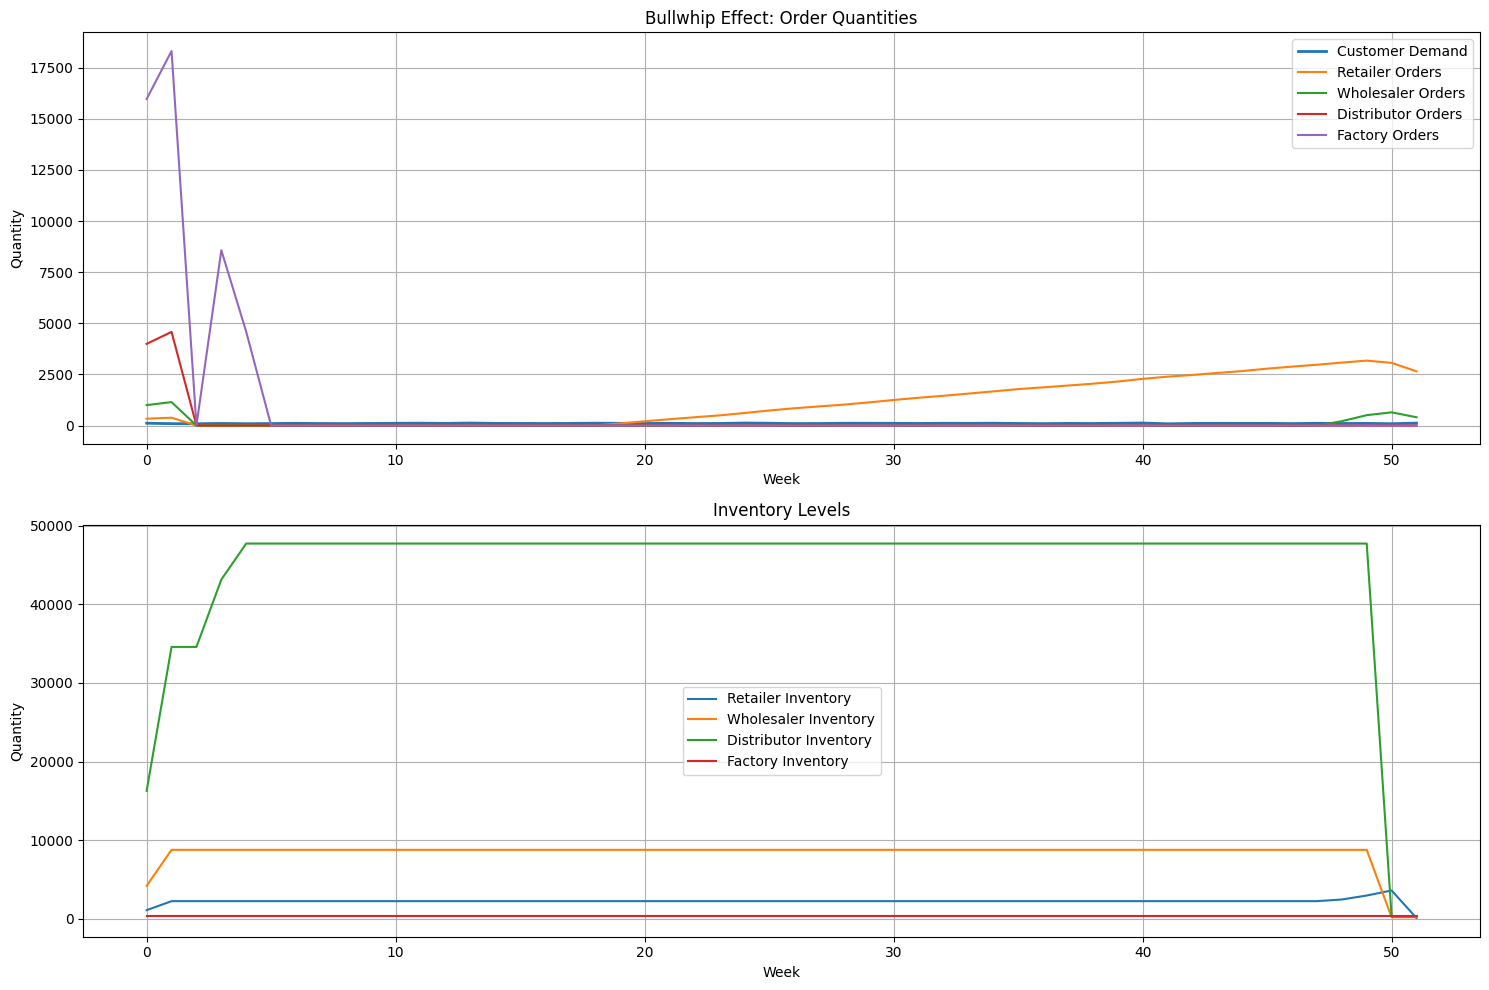


Variability Analysis:
Customer Demand Std Dev: 8.79
Retailer Order Std Dev: 1104.82 (Amplification: 125.72x)
Wholesaler Order Std Dev: 235.78 (Amplification: 26.83x)
Distributor Order Std Dev: 826.19 (Amplification: 94.01x)
Factory Order Std Dev: 3512.84 (Amplification: 399.73x)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

class SupplyChainActor:
    def __init__(self, name, lead_time, safety_stock, order_delay=1):
        self.name = name
        self.lead_time = lead_time
        self.safety_stock = safety_stock
        self.order_delay = order_delay

        # 재고 및 주문 관련 변수 초기화
        self.inventory = safety_stock
        self.backlog = 0
        self.incoming_orders = []
        self.outgoing_orders = []
        self.received_shipments = []

        # 이동평균을 위한 주문 이력
        self.order_history = deque(maxlen=4)  # 4주 이동평균

    def place_order(self, demand):
        # 이동평균 계산을 위한 주문 이력 업데이트
        self.order_history.append(demand)

        # 이동평균 기반 수요 예측
        if len(self.order_history) < 4:
            forecasted_demand = demand
        else:
            forecasted_demand = np.mean(self.order_history)

        # 필요 재고량 계산
        required_inventory = (forecasted_demand * (self.lead_time + self.order_delay)
                            + self.safety_stock)

        # 주문량 계산
        order_quantity = max(0, required_inventory - self.inventory + self.backlog)

        self.outgoing_orders.append(order_quantity)
        return order_quantity

    def receive_shipment(self, shipment):
        self.received_shipments.append(shipment)
        self.inventory += shipment

    def fulfill_orders(self, demand):
        # 실제 출하량 계산
        fulfilled = min(demand + self.backlog, self.inventory)

        # 재고 및 미출하량 업데이트
        self.inventory -= fulfilled
        self.backlog = demand + self.backlog - fulfilled

        return fulfilled

class SupplyChain:
    def __init__(self):
        # 공급망 구성원 초기화
        self.retailer = SupplyChainActor("Retailer", lead_time=2, safety_stock=100)
        self.wholesaler = SupplyChainActor("Wholesaler", lead_time=2, safety_stock=200)
        self.distributor = SupplyChainActor("Distributor", lead_time=3, safety_stock=300)
        self.factory = SupplyChainActor("Factory", lead_time=3, safety_stock=400)

        # 시뮬레이션 결과 저장
        self.customer_demand_history = []
        self.actors = [self.retailer, self.wholesaler, self.distributor, self.factory]

    def simulate(self, weeks, base_demand=100, demand_variation=10):
        for week in range(weeks):
            # 고객 수요 생성 (기본 수요 ± 변동)
            customer_demand = max(0, base_demand + np.random.normal(0, demand_variation))
            self.customer_demand_history.append(customer_demand)

            # 각 구성원의 주문 및 배송 처리
            retailer_order = self.retailer.place_order(customer_demand)
            wholesaler_order = self.wholesaler.place_order(retailer_order)
            distributor_order = self.distributor.place_order(wholesaler_order)
            factory_order = self.factory.place_order(distributor_order)

            # 배송 처리 (리드타임 고려)
            if len(self.factory.outgoing_orders) >= self.factory.lead_time:
                factory_shipment = self.factory.outgoing_orders[-self.factory.lead_time]
                self.distributor.receive_shipment(factory_shipment)

            if len(self.distributor.outgoing_orders) >= self.distributor.lead_time:
                distributor_shipment = self.distributor.outgoing_orders[-self.distributor.lead_time]
                self.wholesaler.receive_shipment(distributor_shipment)

            if len(self.wholesaler.outgoing_orders) >= self.wholesaler.lead_time:
                wholesaler_shipment = self.wholesaler.outgoing_orders[-self.wholesaler.lead_time]
                self.retailer.receive_shipment(wholesaler_shipment)

            # 주문 이행
            self.retailer.fulfill_orders(customer_demand)

    def plot_results(self):
        plt.figure(figsize=(15, 10))

        # 주문량 그래프
        plt.subplot(2, 1, 1)
        plt.plot(self.customer_demand_history, label='Customer Demand', linewidth=2)
        for actor in self.actors:
            plt.plot(actor.outgoing_orders, label=f'{actor.name} Orders')
        plt.title('Bullwhip Effect: Order Quantities')
        plt.xlabel('Week')
        plt.ylabel('Quantity')
        plt.legend()
        plt.grid(True)

        # 재고 수준 그래프
        plt.subplot(2, 1, 2)
        for actor in self.actors:
            inventory_history = [actor.safety_stock] * len(self.customer_demand_history)
            for i in range(len(actor.received_shipments)):
                inventory_history[i] = actor.safety_stock + sum(actor.received_shipments[:i+1])
            plt.plot(inventory_history, label=f'{actor.name} Inventory')
        plt.title('Inventory Levels')
        plt.xlabel('Week')
        plt.ylabel('Quantity')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

        # 변동성 분석
        print("\nVariability Analysis:")
        base_std = np.std(self.customer_demand_history)
        print(f"Customer Demand Std Dev: {base_std:.2f}")
        for actor in self.actors:
            actor_std = np.std(actor.outgoing_orders)
            amplification = actor_std / base_std
            print(f"{actor.name} Order Std Dev: {actor_std:.2f} (Amplification: {amplification:.2f}x)")

# 시뮬레이션 실행
supply_chain = SupplyChain()
supply_chain.simulate(weeks=52)  # 1년(52주) 시뮬레이션
supply_chain.plot_results()


Running simulation: base scenario, normal demand, simple ordering

Quarter 1 Performance:
Customer Demand: 97.55
Orders: R=292.66, W=877.97, D=3511.89, F=14047.54
Stockouts: 0

Quarter 2 Performance:
Customer Demand: 132.69
Orders: R=0.00, W=0.00, D=0.00, F=0.00
Stockouts: 0

Quarter 3 Performance:
Customer Demand: 125.67
Orders: R=1225.14, W=0.00, D=0.00, F=0.00
Stockouts: 1

Quarter 4 Performance:
Customer Demand: 120.44
Orders: R=2599.16, W=695.54, D=0.00, F=0.00
Stockouts: 1

Simulation completed: 52 weeks
Average demand: 101.78
Demand variation: 20.70


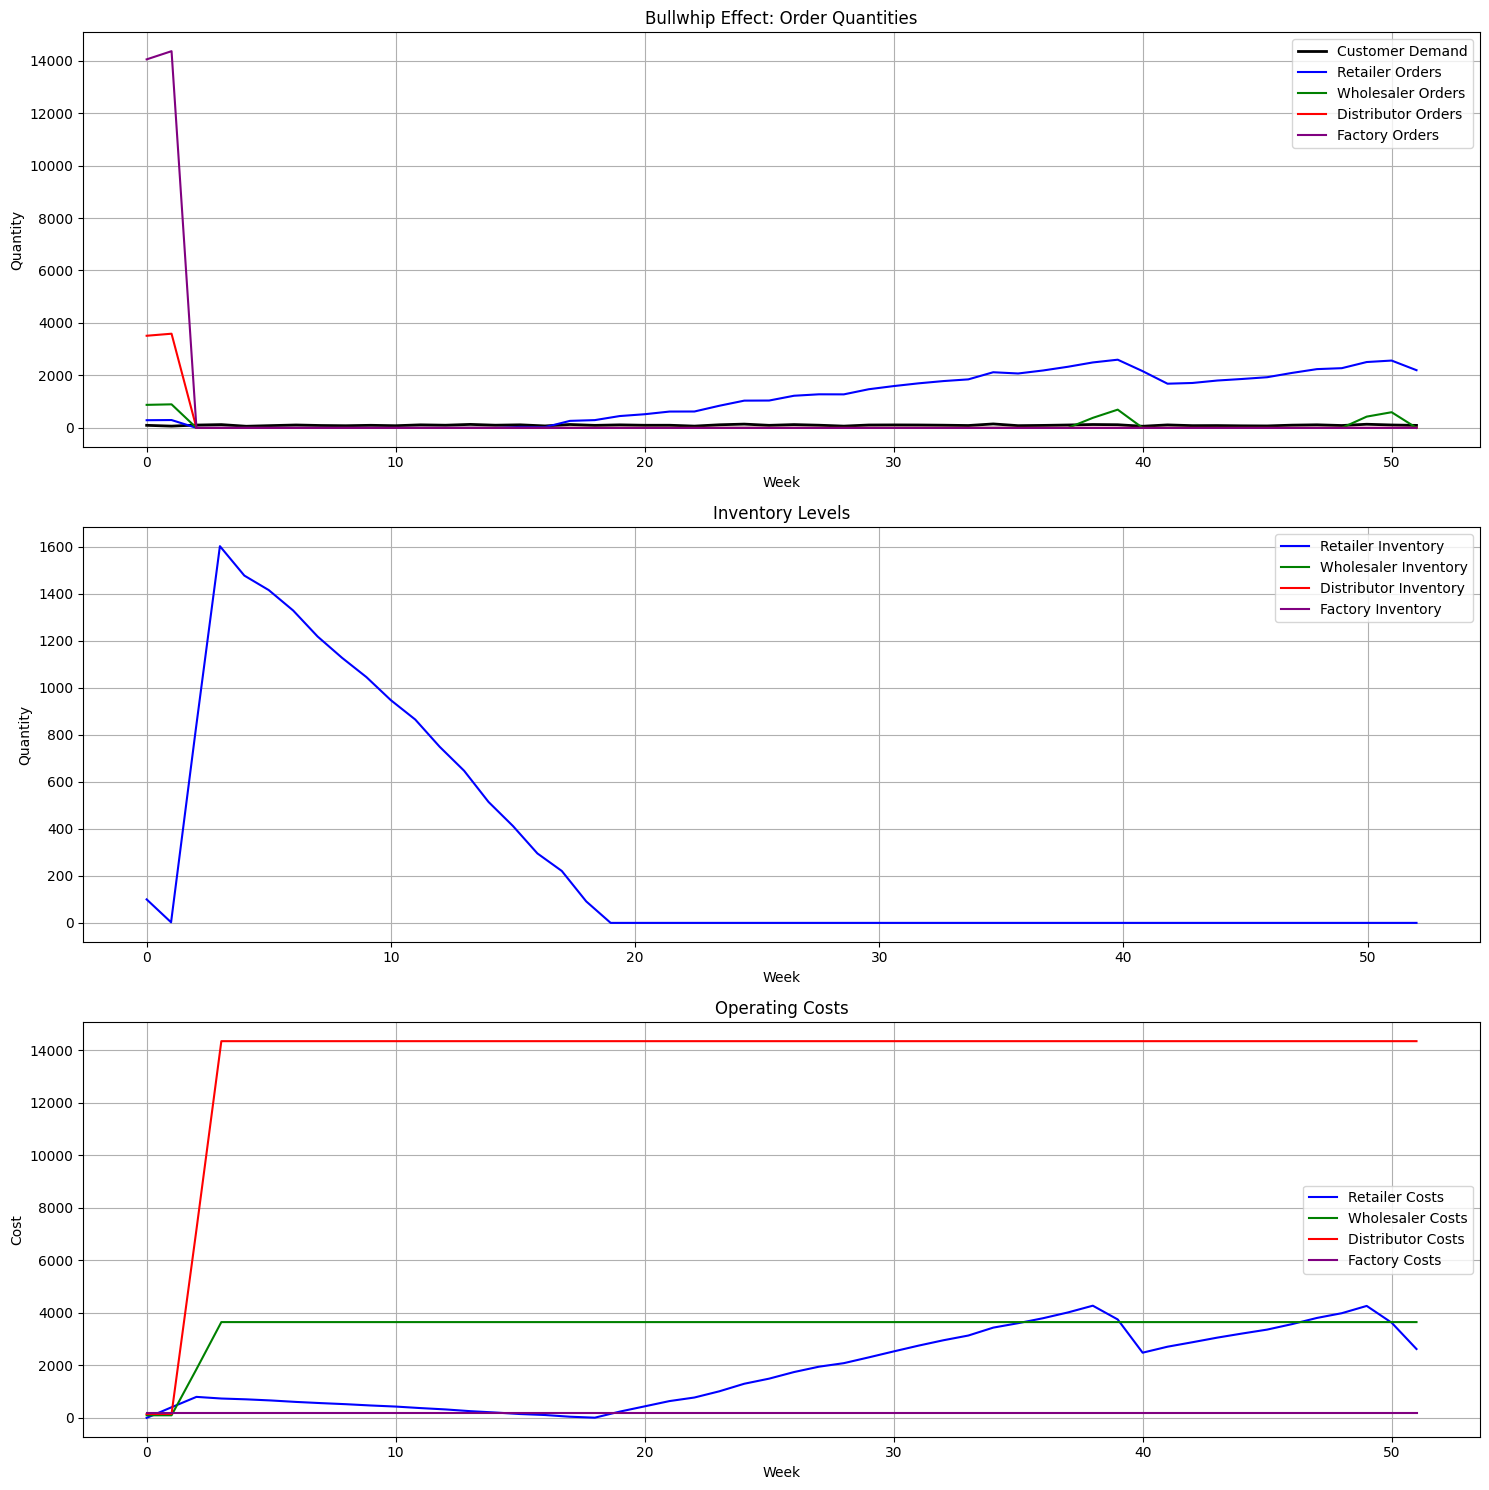


Running simulation: base scenario, normal demand, moving_average ordering

Quarter 1 Performance:
Customer Demand: 61.37
Orders: R=184.12, W=552.35, D=2209.40, F=8837.62
Stockouts: 0

Quarter 2 Performance:
Customer Demand: 75.92
Orders: R=0.00, W=0.00, D=0.00, F=0.00
Stockouts: 0

Quarter 3 Performance:
Customer Demand: 108.15
Orders: R=1068.37, W=0.00, D=0.00, F=0.00
Stockouts: 1

Quarter 4 Performance:
Customer Demand: 112.41
Orders: R=2507.00, W=89.04, D=0.00, F=0.00
Stockouts: 1

Simulation completed: 52 weeks
Average demand: 100.29
Demand variation: 18.74


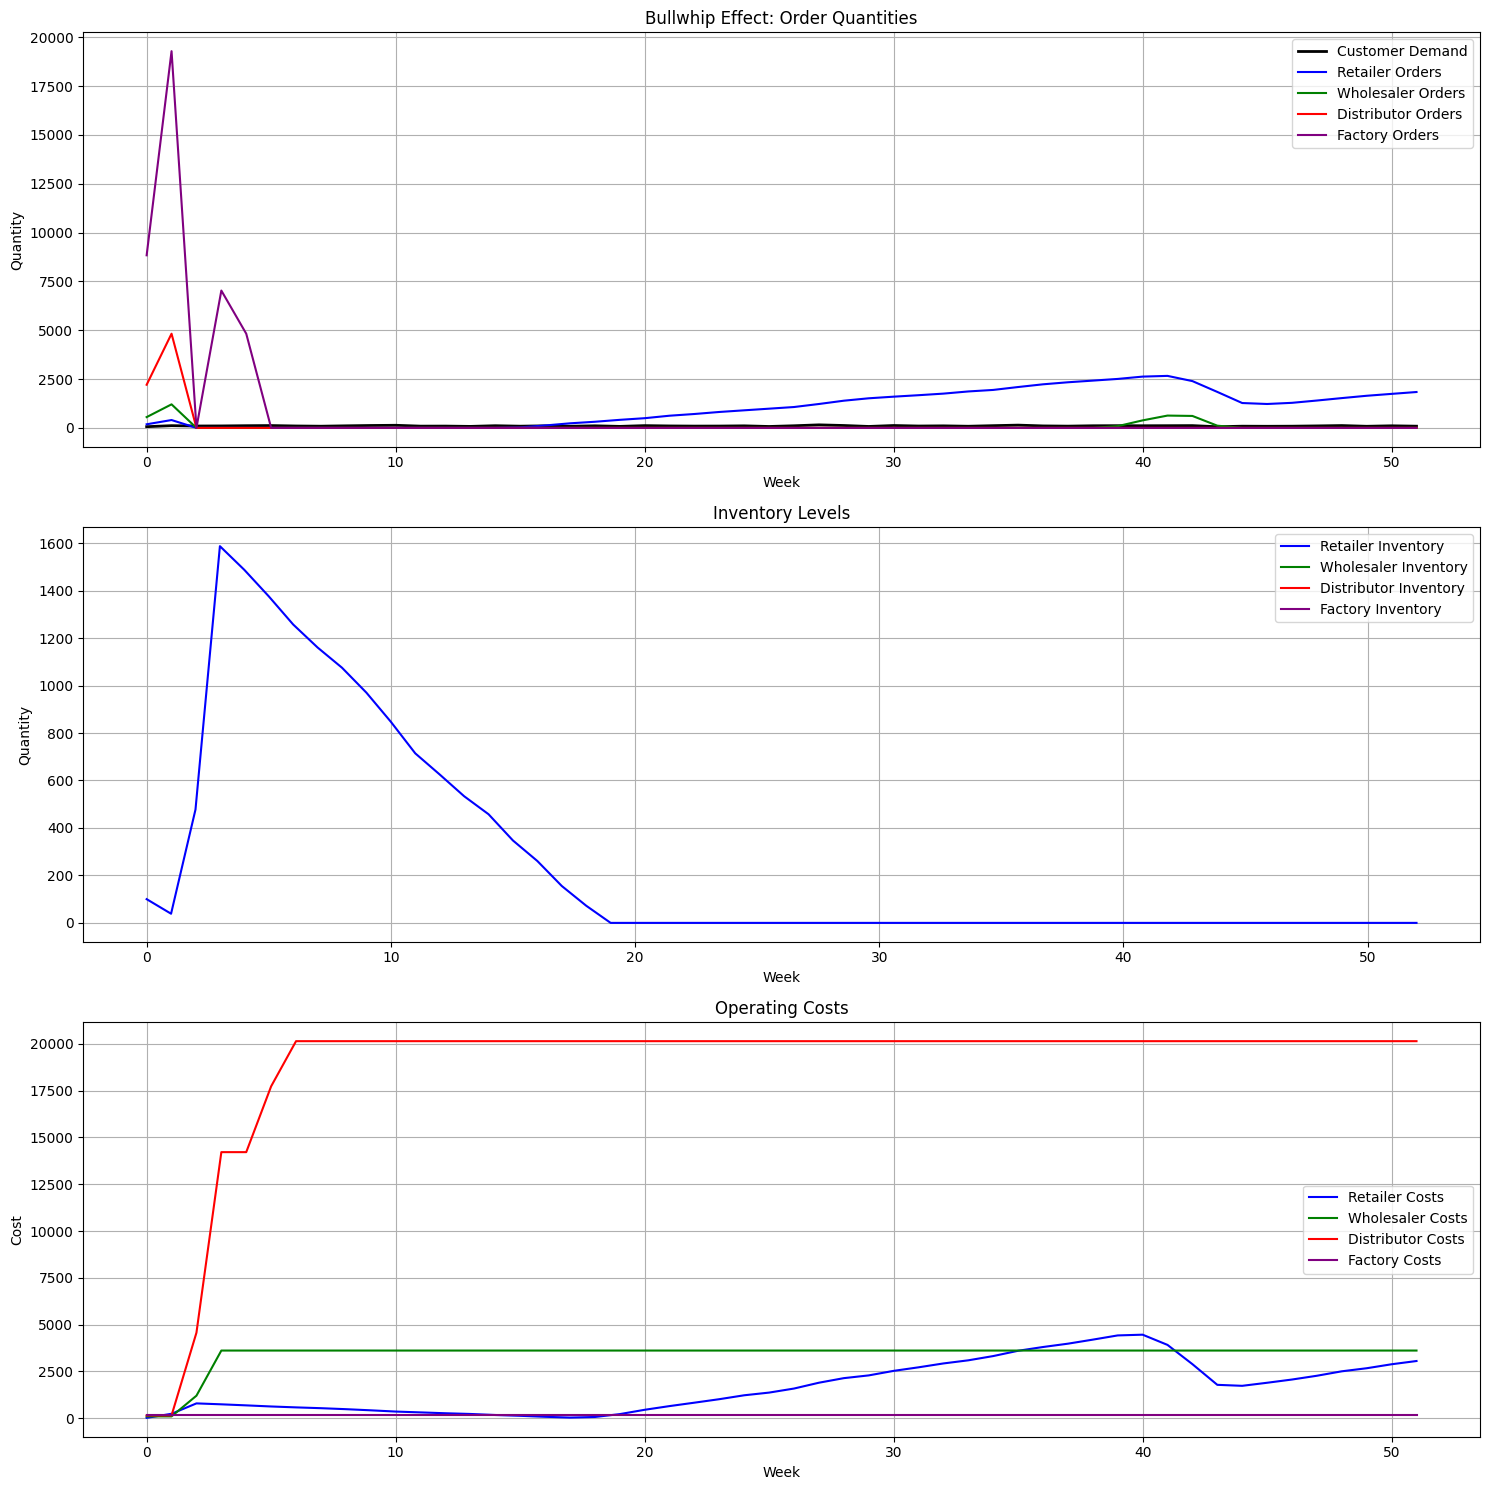


Running simulation: base scenario, normal demand, exponential_smoothing ordering

Quarter 1 Performance:
Customer Demand: 75.93
Orders: R=227.79, W=683.36, D=2733.44, F=10933.77
Stockouts: 0

Quarter 2 Performance:
Customer Demand: 122.13
Orders: R=0.00, W=0.00, D=0.00, F=0.00
Stockouts: 0

Quarter 3 Performance:
Customer Demand: 73.52
Orders: R=711.03, W=0.00, D=0.00, F=0.00
Stockouts: 1

Quarter 4 Performance:
Customer Demand: 115.18
Orders: R=1974.20, W=0.00, D=0.00, F=0.00
Stockouts: 1

Simulation completed: 52 weeks
Average demand: 95.83
Demand variation: 18.10


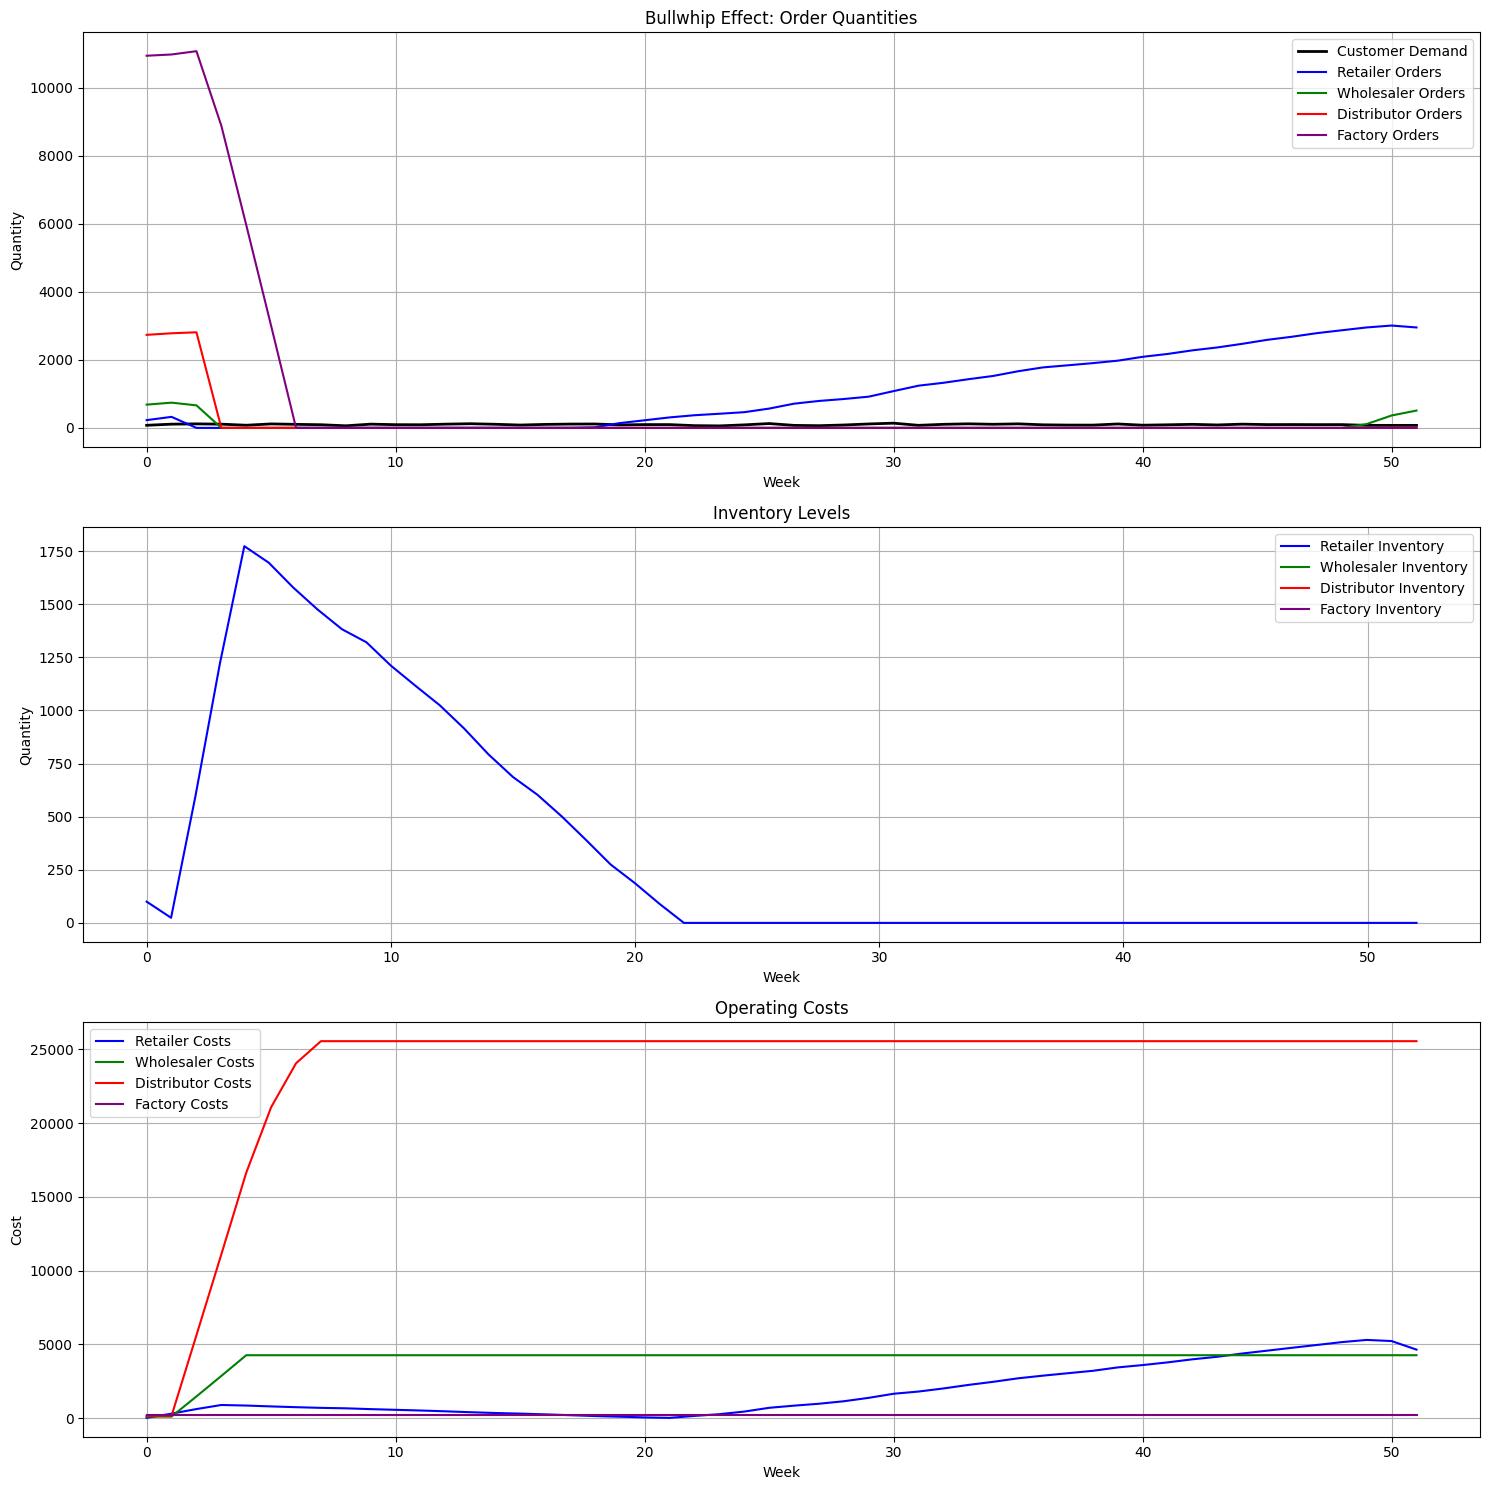


Running simulation: base scenario, seasonal demand, simple ordering

Quarter 1 Performance:
Customer Demand: 127.80
Orders: R=383.39, W=1150.17, D=4600.69, F=18402.76
Stockouts: 1

Quarter 2 Performance:
Customer Demand: 146.42
Orders: R=0.00, W=0.00, D=0.00, F=0.00
Stockouts: 0

Quarter 3 Performance:
Customer Demand: 108.84
Orders: R=916.78, W=0.00, D=0.00, F=0.00
Stockouts: 1

Quarter 4 Performance:
Customer Demand: 69.71
Orders: R=1964.63, W=0.00, D=0.00, F=0.00
Stockouts: 1

Simulation completed: 52 weeks
Average demand: 100.89
Demand variation: 23.89


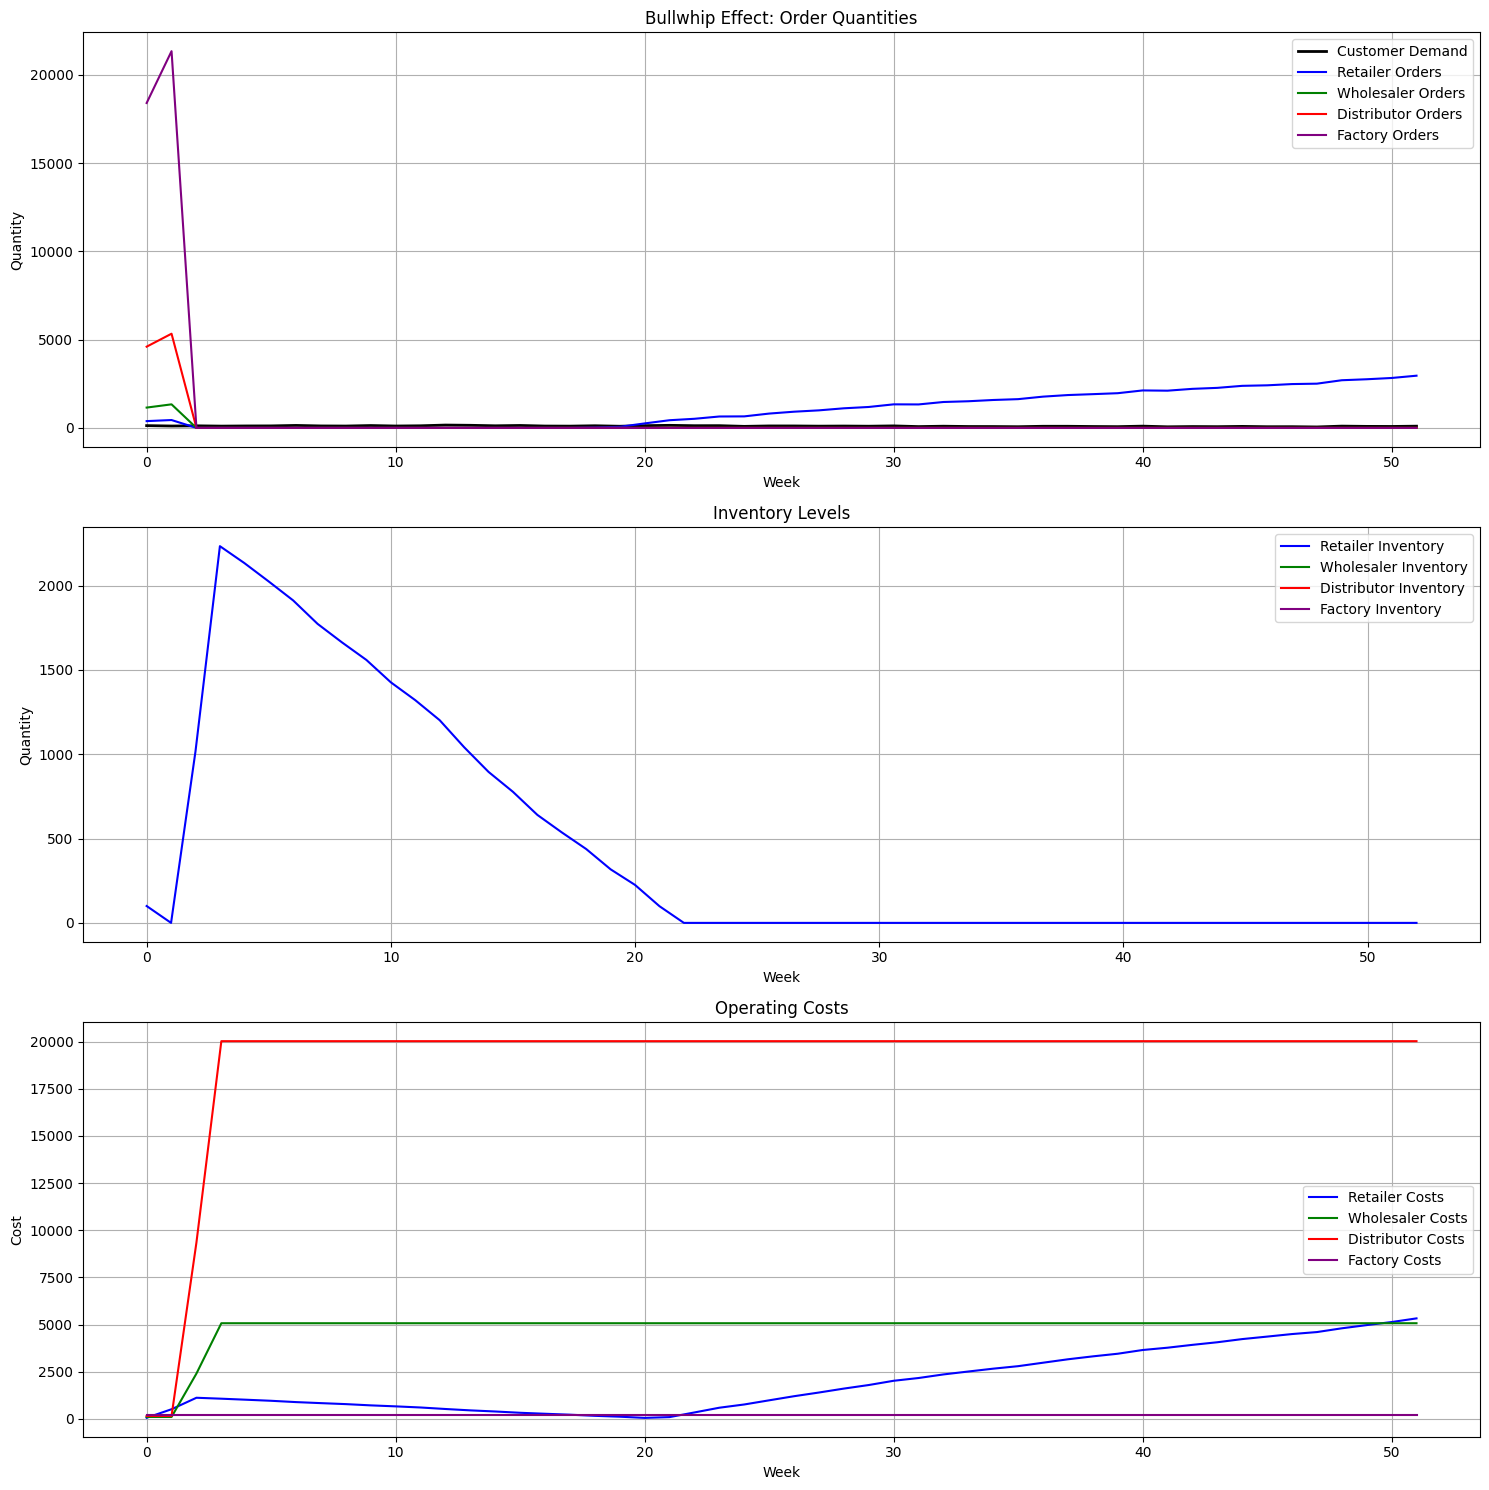


Running simulation: base scenario, seasonal demand, moving_average ordering

Quarter 1 Performance:
Customer Demand: 94.52
Orders: R=283.55, W=850.64, D=3402.55, F=13610.18
Stockouts: 0

Quarter 2 Performance:
Customer Demand: 134.94
Orders: R=116.05, W=0.00, D=0.00, F=0.00
Stockouts: 0

Quarter 3 Performance:
Customer Demand: 93.84
Orders: R=1531.71, W=0.00, D=0.00, F=0.00
Stockouts: 1

Quarter 4 Performance:
Customer Demand: 68.77
Orders: R=1169.56, W=0.00, D=0.00, F=0.00
Stockouts: 1

Simulation completed: 52 weeks
Average demand: 101.24
Demand variation: 26.25


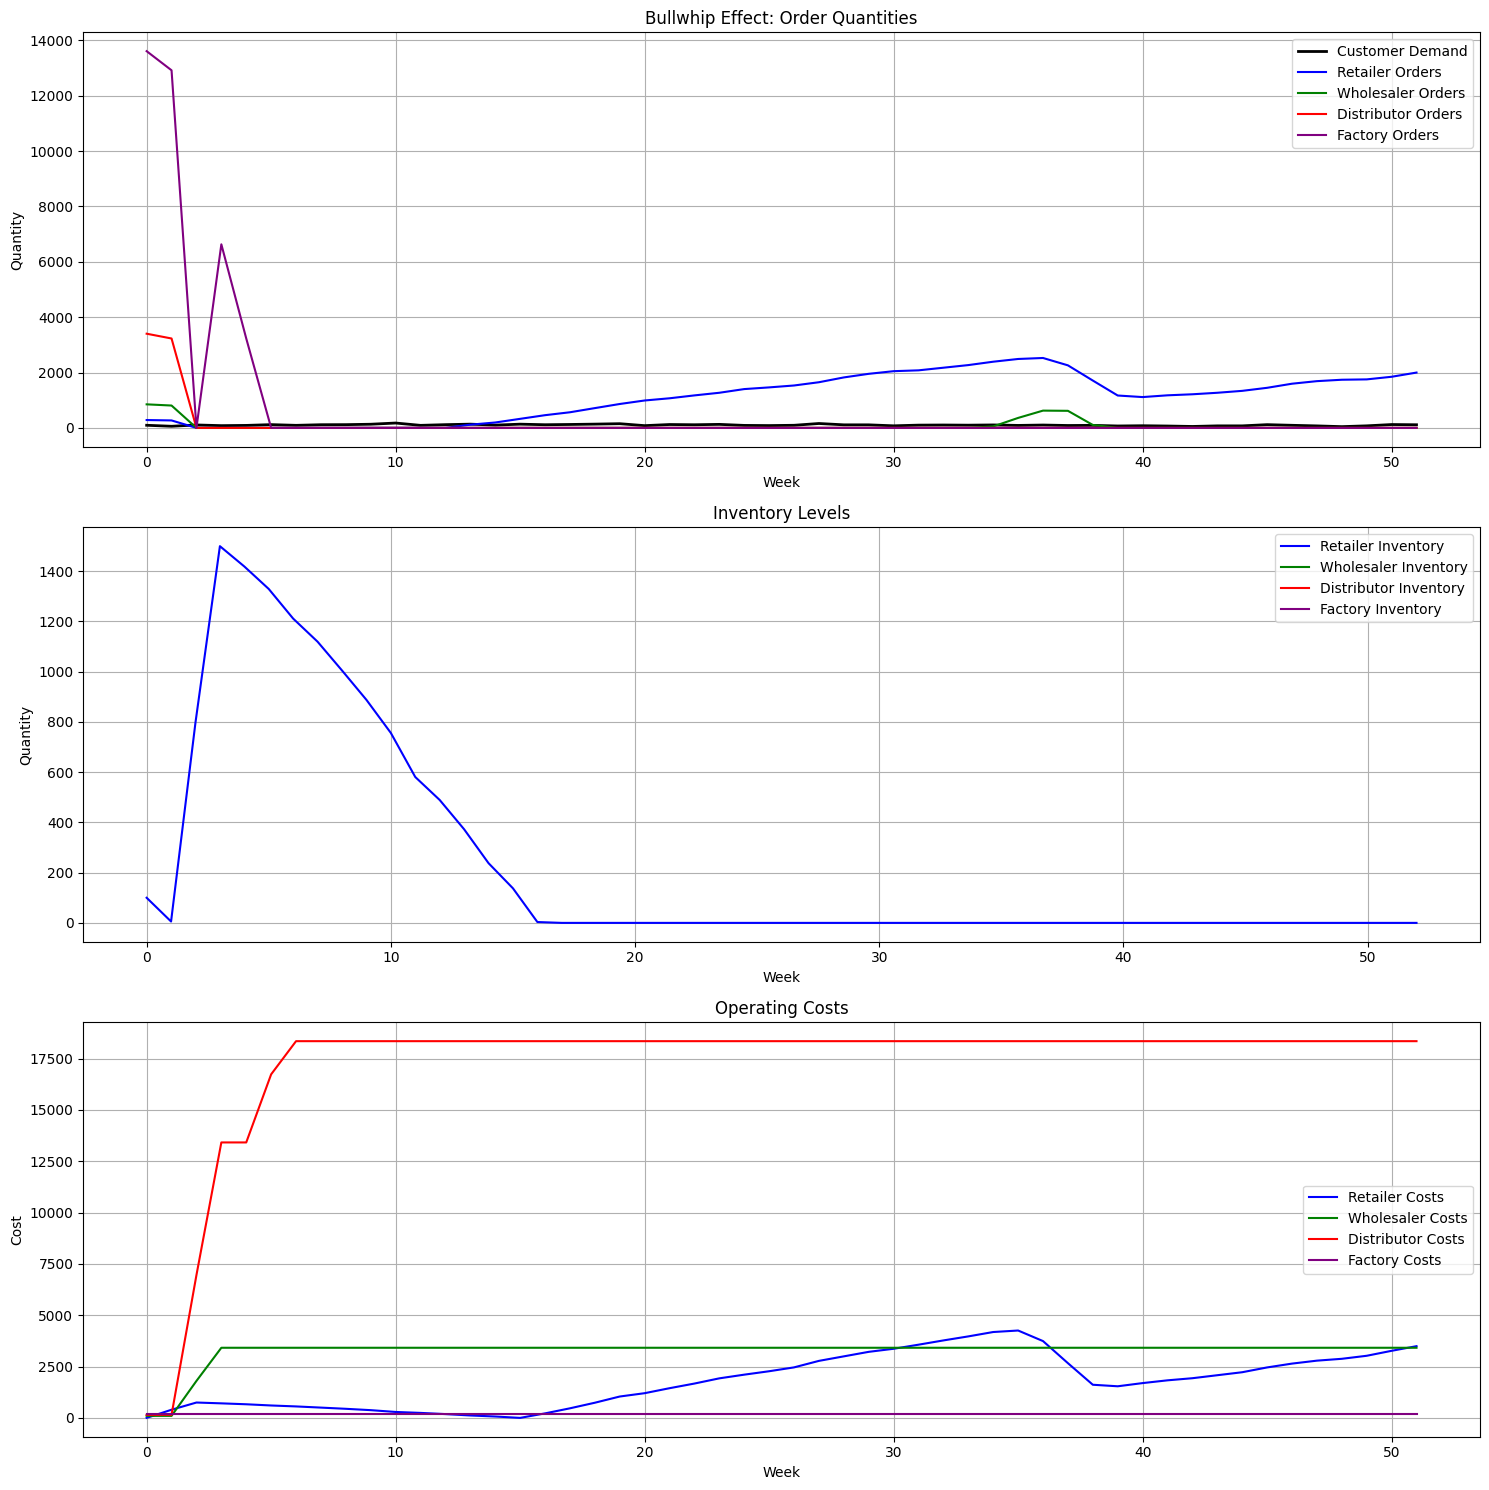


Running simulation: base scenario, seasonal demand, exponential_smoothing ordering

Quarter 1 Performance:
Customer Demand: 119.77
Orders: R=359.31, W=1077.92, D=4311.70, F=17246.79
Stockouts: 1

Quarter 2 Performance:
Customer Demand: 140.79
Orders: R=0.00, W=0.00, D=0.00, F=0.00
Stockouts: 0

Quarter 3 Performance:
Customer Demand: 83.19
Orders: R=235.07, W=0.00, D=0.00, F=0.00
Stockouts: 0

Quarter 4 Performance:
Customer Demand: 64.86
Orders: R=1203.18, W=0.00, D=0.00, F=0.00
Stockouts: 1

Simulation completed: 52 weeks
Average demand: 99.53
Demand variation: 25.95


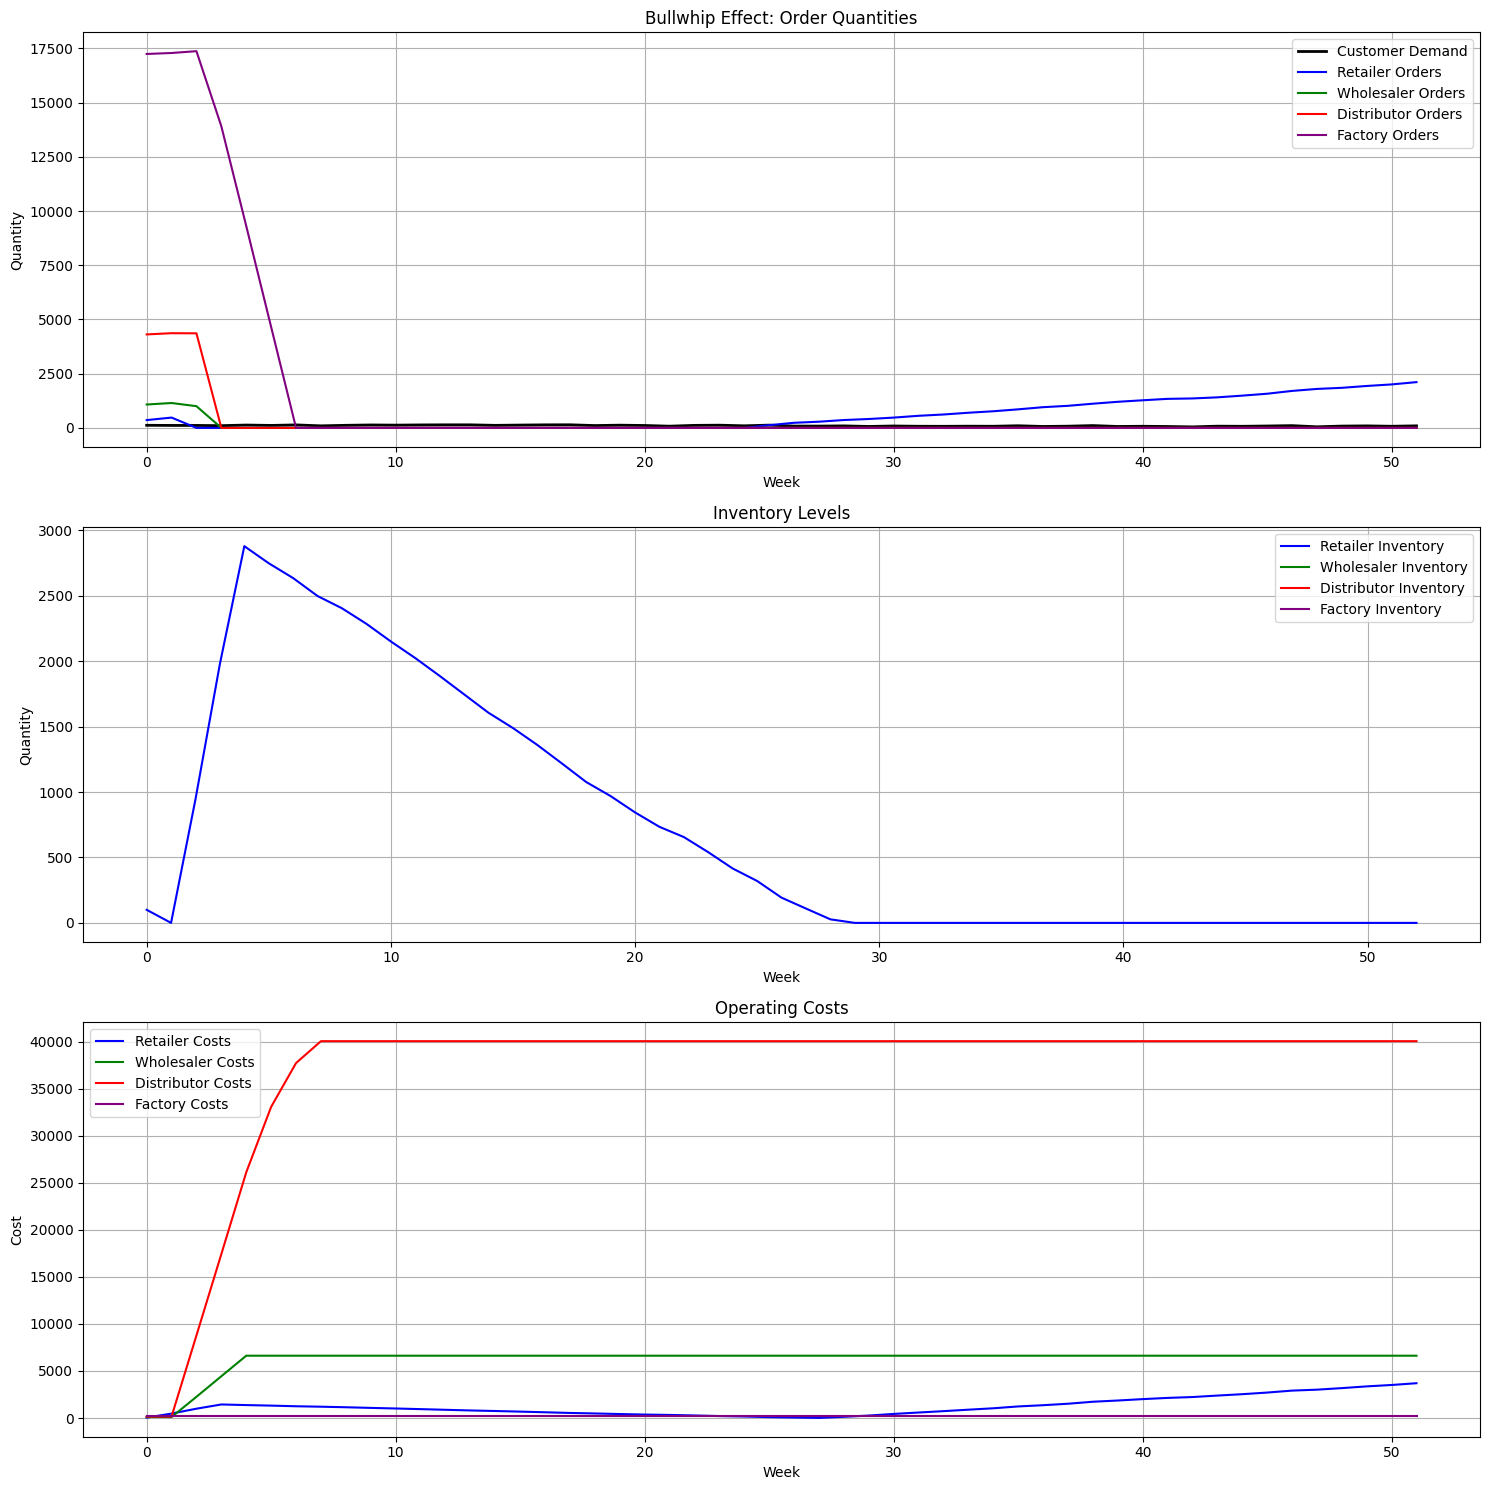


Running simulation: base scenario, trend demand, simple ordering

Quarter 1 Performance:
Customer Demand: 75.14
Orders: R=225.43, W=676.28, D=2705.13, F=10820.51
Stockouts: 0

Quarter 2 Performance:
Customer Demand: 79.03
Orders: R=0.00, W=0.00, D=0.00, F=0.00
Stockouts: 0

Quarter 3 Performance:
Customer Demand: 133.68
Orders: R=1412.69, W=0.00, D=0.00, F=0.00
Stockouts: 1

Quarter 4 Performance:
Customer Demand: 127.48
Orders: R=1691.92, W=0.00, D=0.00, F=0.00
Stockouts: 1

Simulation completed: 52 weeks
Average demand: 124.17
Demand variation: 25.94


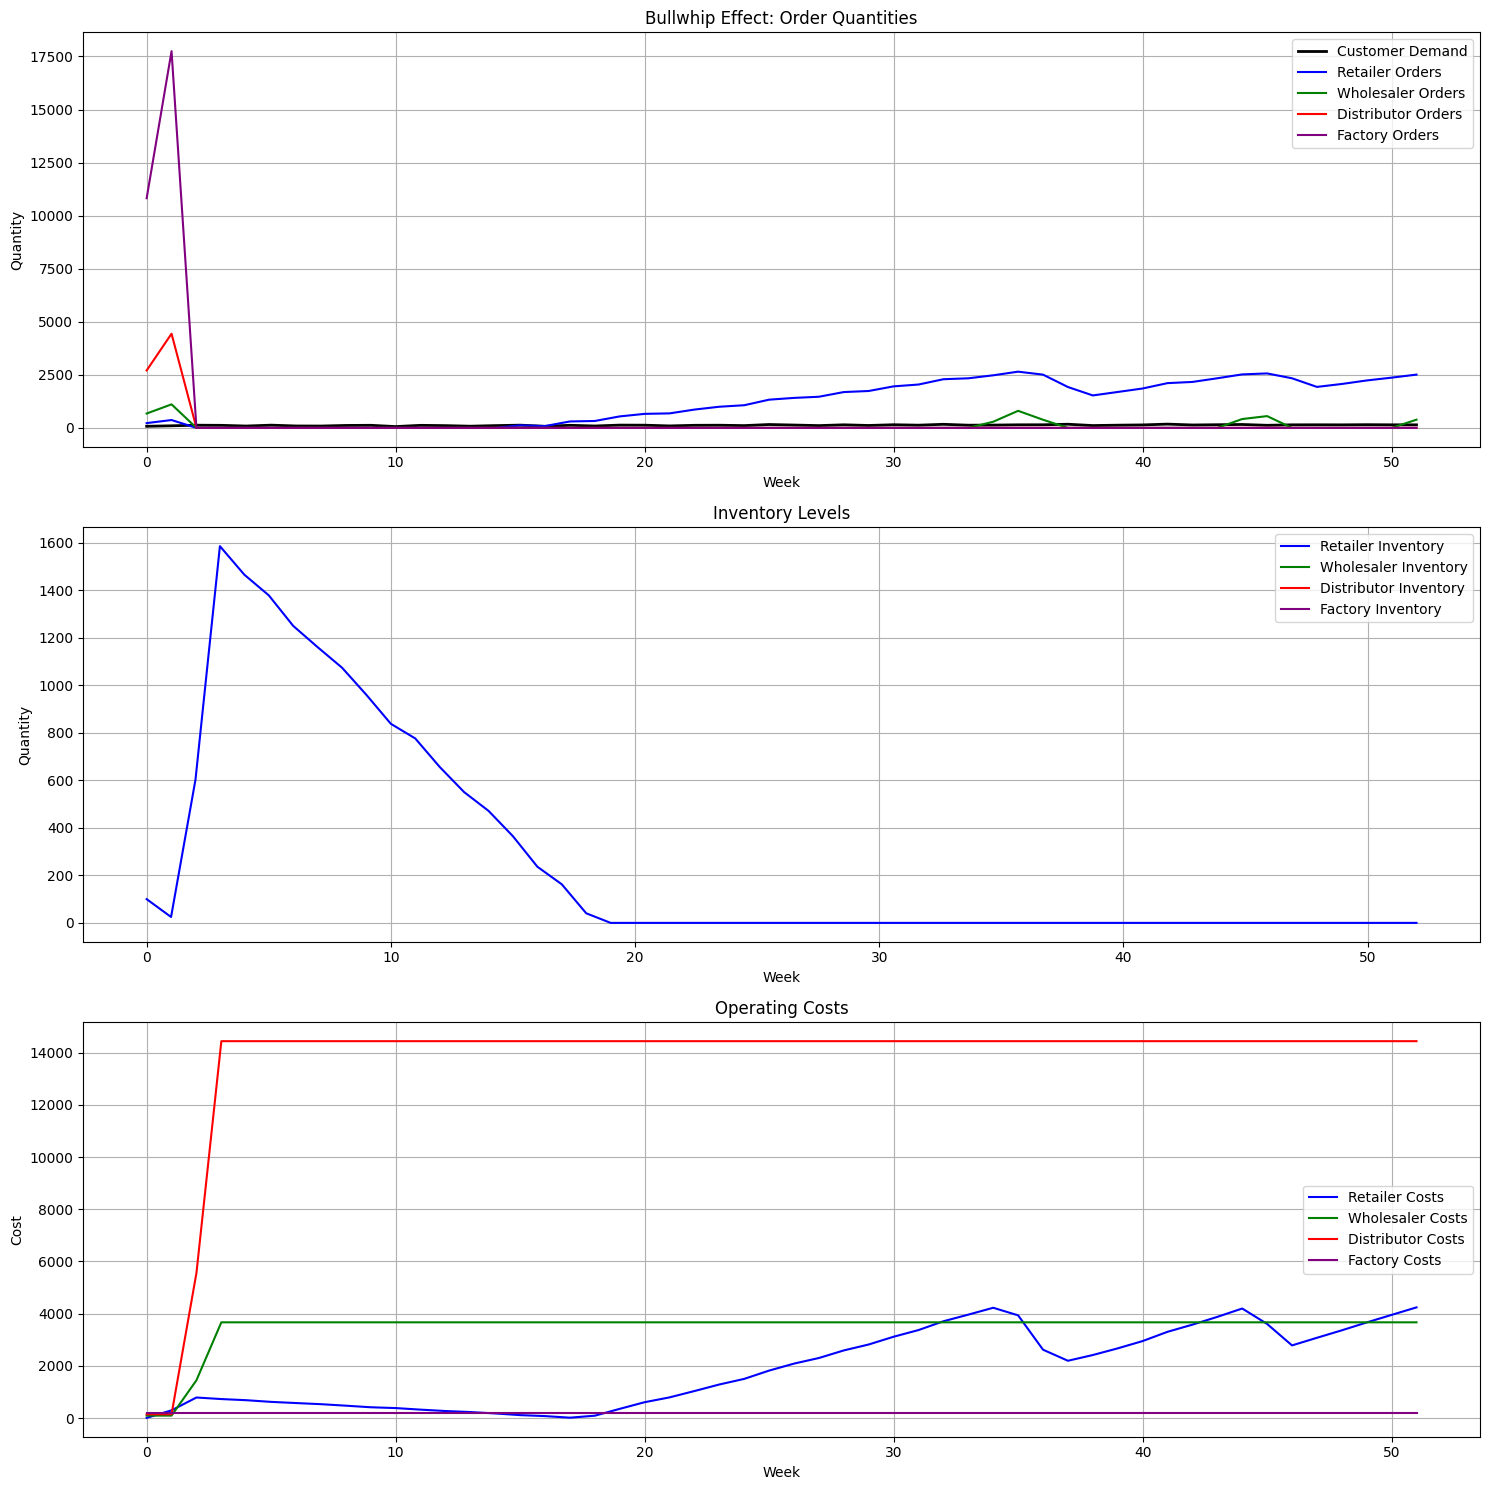


Running simulation: base scenario, trend demand, moving_average ordering

Quarter 1 Performance:
Customer Demand: 66.82
Orders: R=200.46, W=601.37, D=2405.50, F=9622.00
Stockouts: 0

Quarter 2 Performance:
Customer Demand: 116.58
Orders: R=282.17, W=0.00, D=0.00, F=0.00
Stockouts: 0

Quarter 3 Performance:
Customer Demand: 115.71
Orders: R=1726.93, W=0.00, D=0.00, F=0.00
Stockouts: 1

Quarter 4 Performance:
Customer Demand: 178.95
Orders: R=1402.08, W=0.00, D=0.00, F=0.00
Stockouts: 1

Simulation completed: 52 weeks
Average demand: 126.64
Demand variation: 24.97


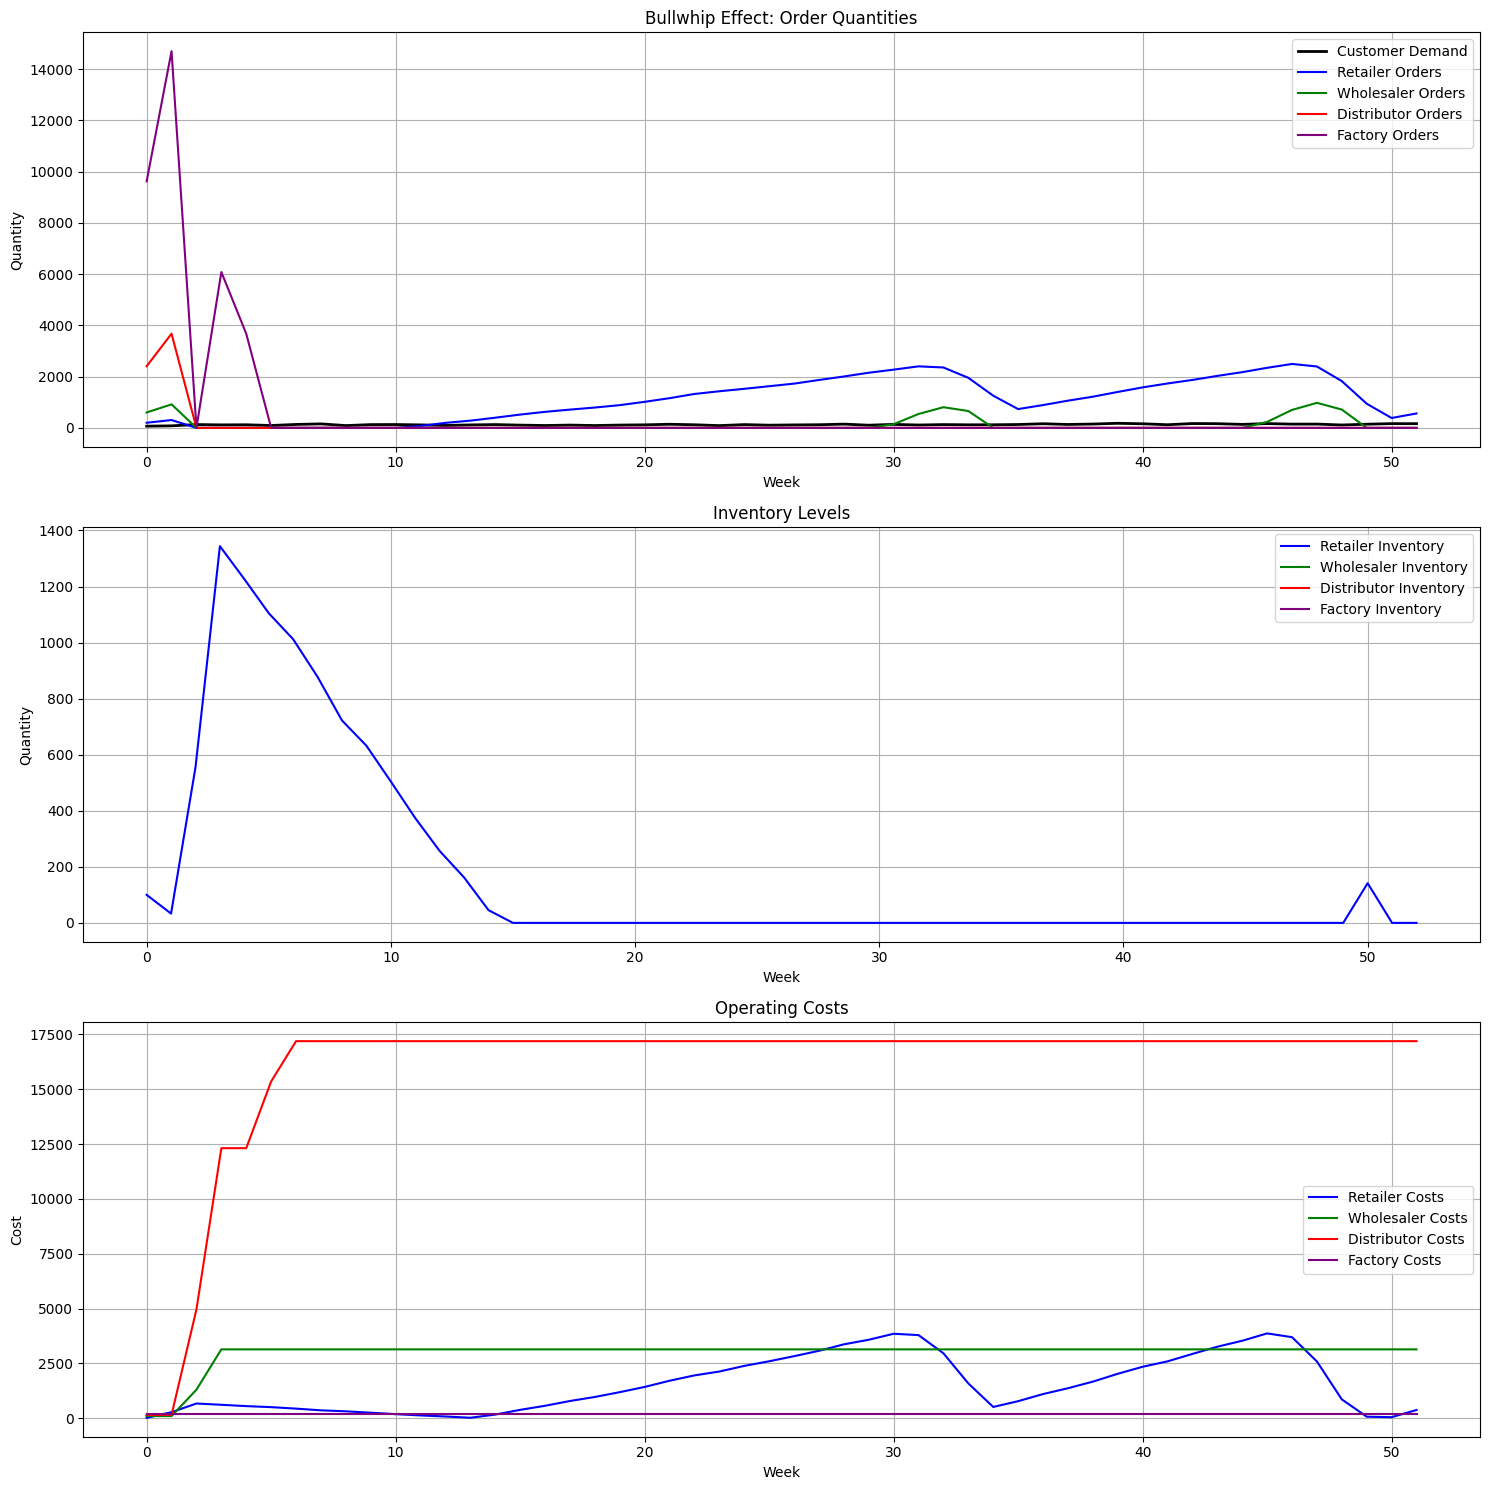


Running simulation: base scenario, trend demand, exponential_smoothing ordering

Quarter 1 Performance:
Customer Demand: 115.21
Orders: R=345.62, W=1036.87, D=4147.49, F=16589.95
Stockouts: 1

Quarter 2 Performance:
Customer Demand: 131.85
Orders: R=0.00, W=0.00, D=0.00, F=0.00
Stockouts: 0

Quarter 3 Performance:
Customer Demand: 122.43
Orders: R=397.36, W=0.00, D=0.00, F=0.00
Stockouts: 1

Quarter 4 Performance:
Customer Demand: 131.88
Orders: R=1978.79, W=0.00, D=0.00, F=0.00
Stockouts: 1

Simulation completed: 52 weeks
Average demand: 124.46
Demand variation: 21.96


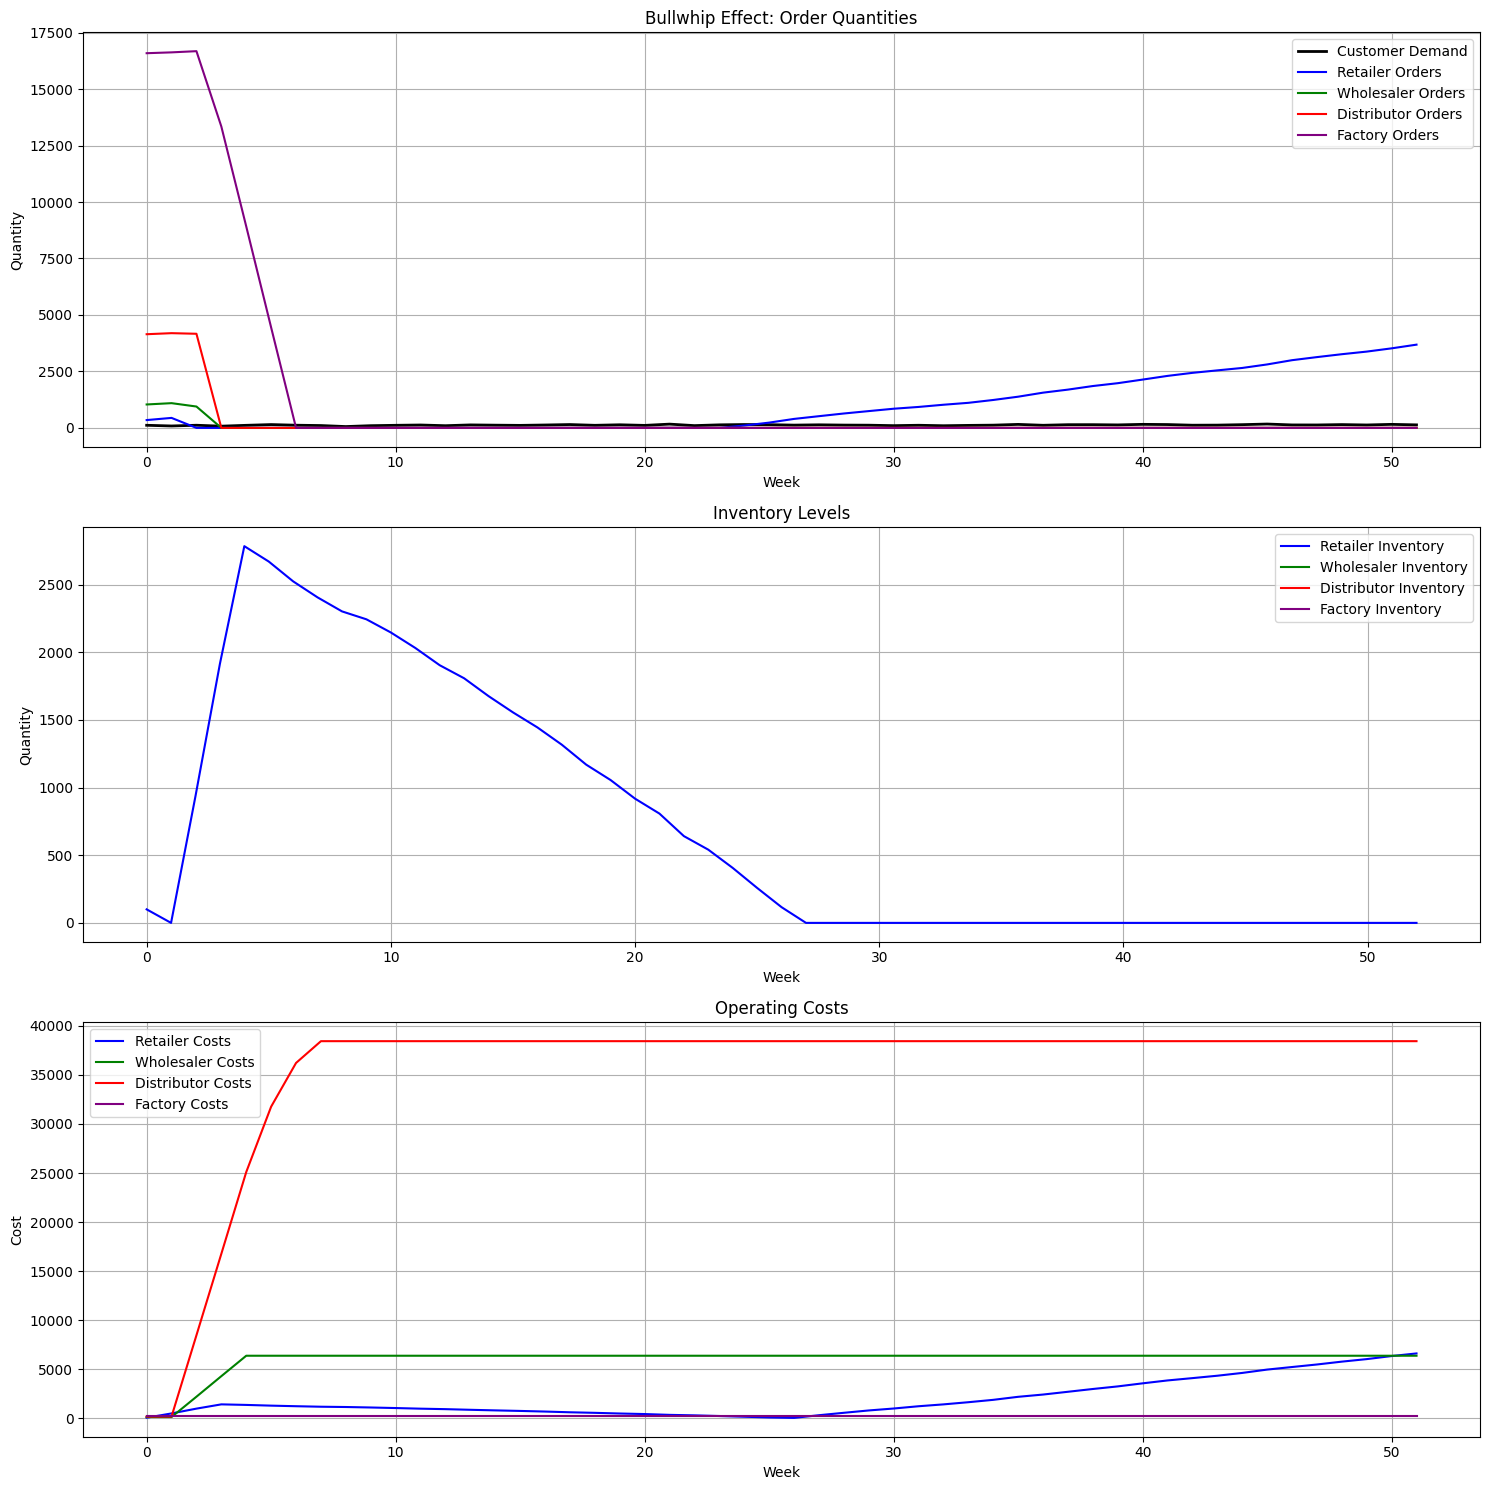


Running simulation: high_variability scenario, normal demand, simple ordering

Quarter 1 Performance:
Customer Demand: 117.73
Orders: R=470.93, W=1883.71, D=9418.56, F=47092.79
Stockouts: 0

Quarter 2 Performance:
Customer Demand: 77.39
Orders: R=0.00, W=0.00, D=0.00, F=0.00
Stockouts: 0

Quarter 3 Performance:
Customer Demand: 97.02
Orders: R=0.00, W=0.00, D=0.00, F=0.00
Stockouts: 0

Quarter 4 Performance:
Customer Demand: 71.92
Orders: R=0.00, W=0.00, D=0.00, F=0.00
Stockouts: 0

Simulation completed: 52 weeks
Average demand: 99.19
Demand variation: 22.19


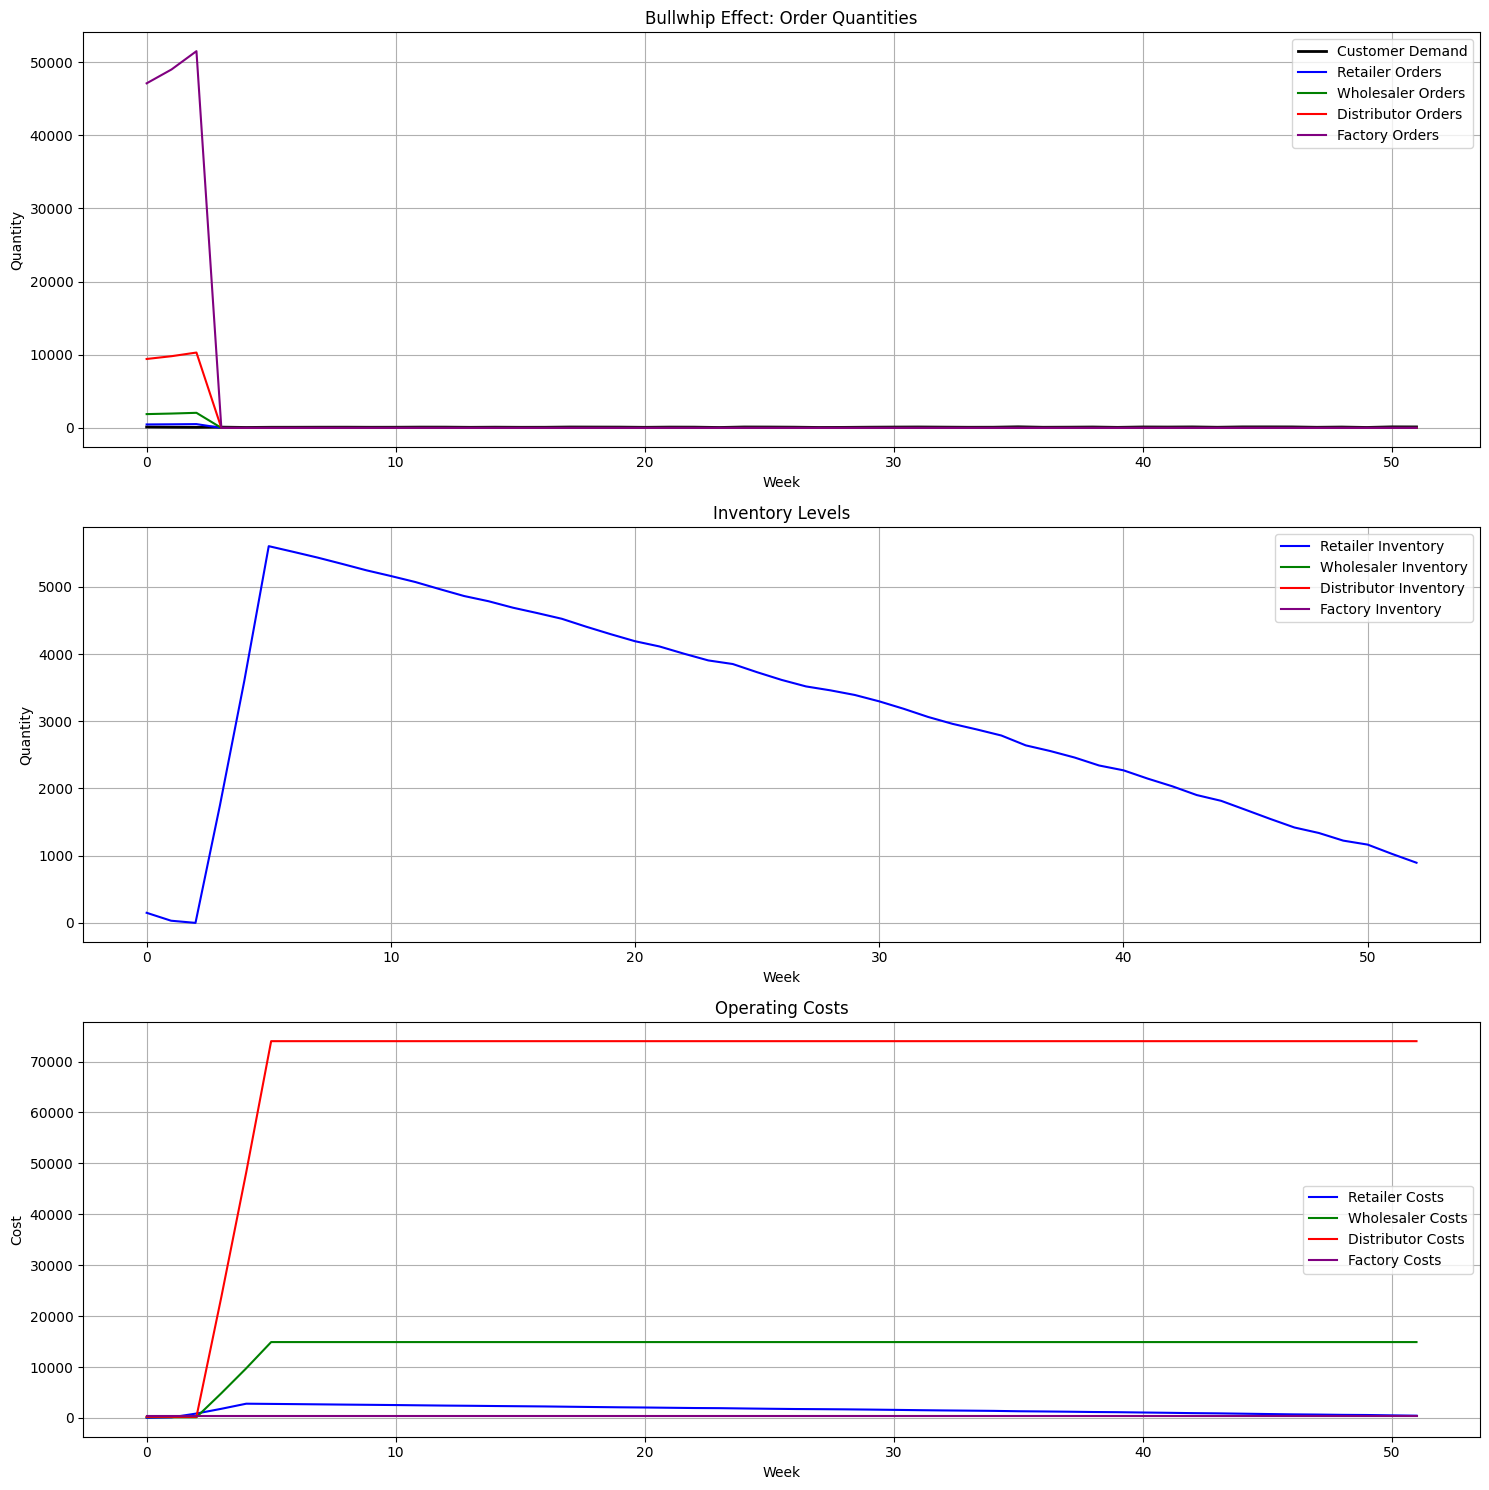


Running simulation: high_variability scenario, normal demand, moving_average ordering

Quarter 1 Performance:
Customer Demand: 118.61
Orders: R=474.44, W=1897.76, D=9488.78, F=47443.92
Stockouts: 0

Quarter 2 Performance:
Customer Demand: 84.58
Orders: R=0.00, W=0.00, D=0.00, F=0.00
Stockouts: 0

Quarter 3 Performance:
Customer Demand: 117.06
Orders: R=0.00, W=0.00, D=0.00, F=0.00
Stockouts: 0

Quarter 4 Performance:
Customer Demand: 99.53
Orders: R=0.00, W=0.00, D=0.00, F=0.00
Stockouts: 0

Simulation completed: 52 weeks
Average demand: 98.88
Demand variation: 19.43


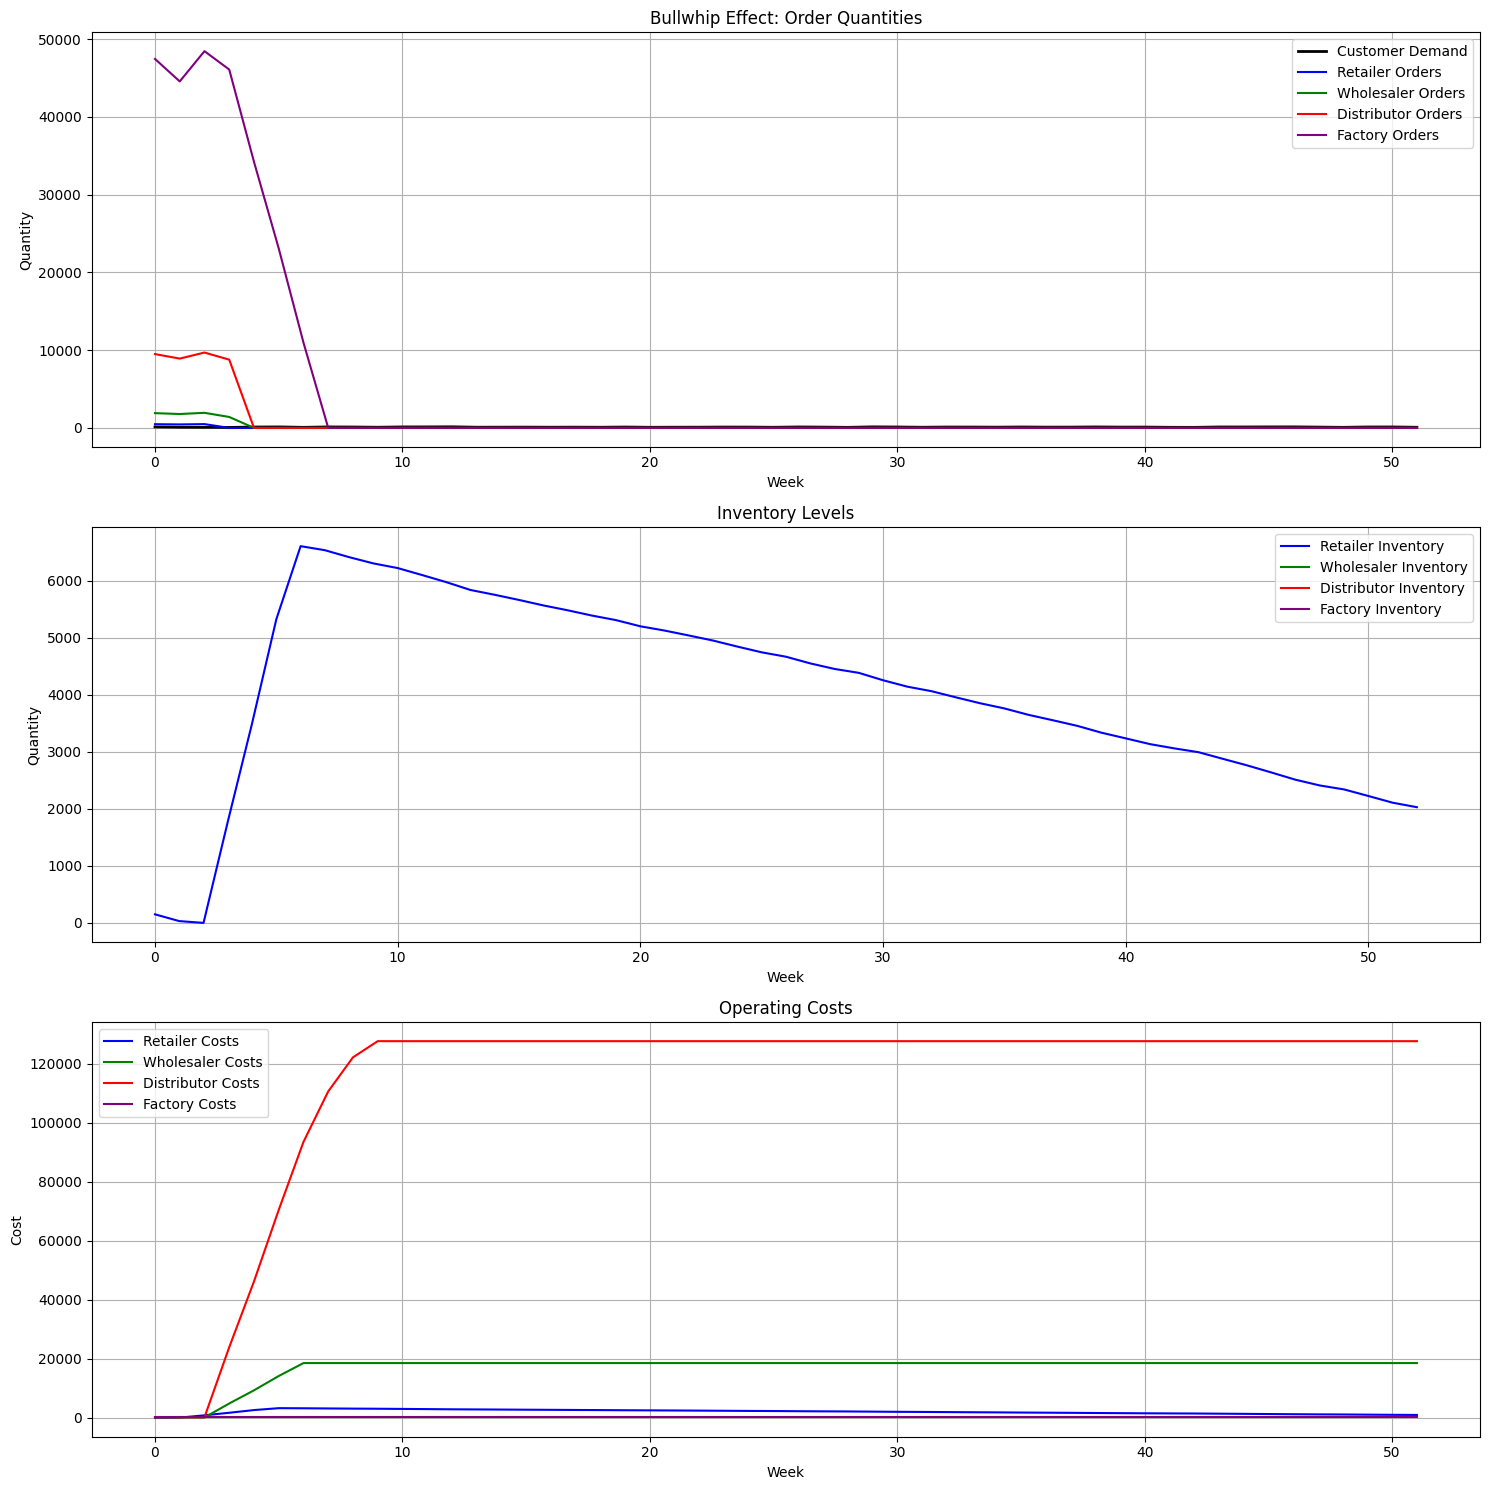


Running simulation: high_variability scenario, normal demand, exponential_smoothing ordering

Quarter 1 Performance:
Customer Demand: 108.76
Orders: R=435.03, W=1740.13, D=8700.64, F=43503.19
Stockouts: 0

Quarter 2 Performance:
Customer Demand: 105.92
Orders: R=0.00, W=0.00, D=0.00, F=0.00
Stockouts: 0

Quarter 3 Performance:
Customer Demand: 132.31
Orders: R=0.00, W=0.00, D=0.00, F=0.00
Stockouts: 0

Quarter 4 Performance:
Customer Demand: 103.75
Orders: R=0.00, W=0.00, D=0.00, F=0.00
Stockouts: 0

Simulation completed: 52 weeks
Average demand: 105.89
Demand variation: 20.66


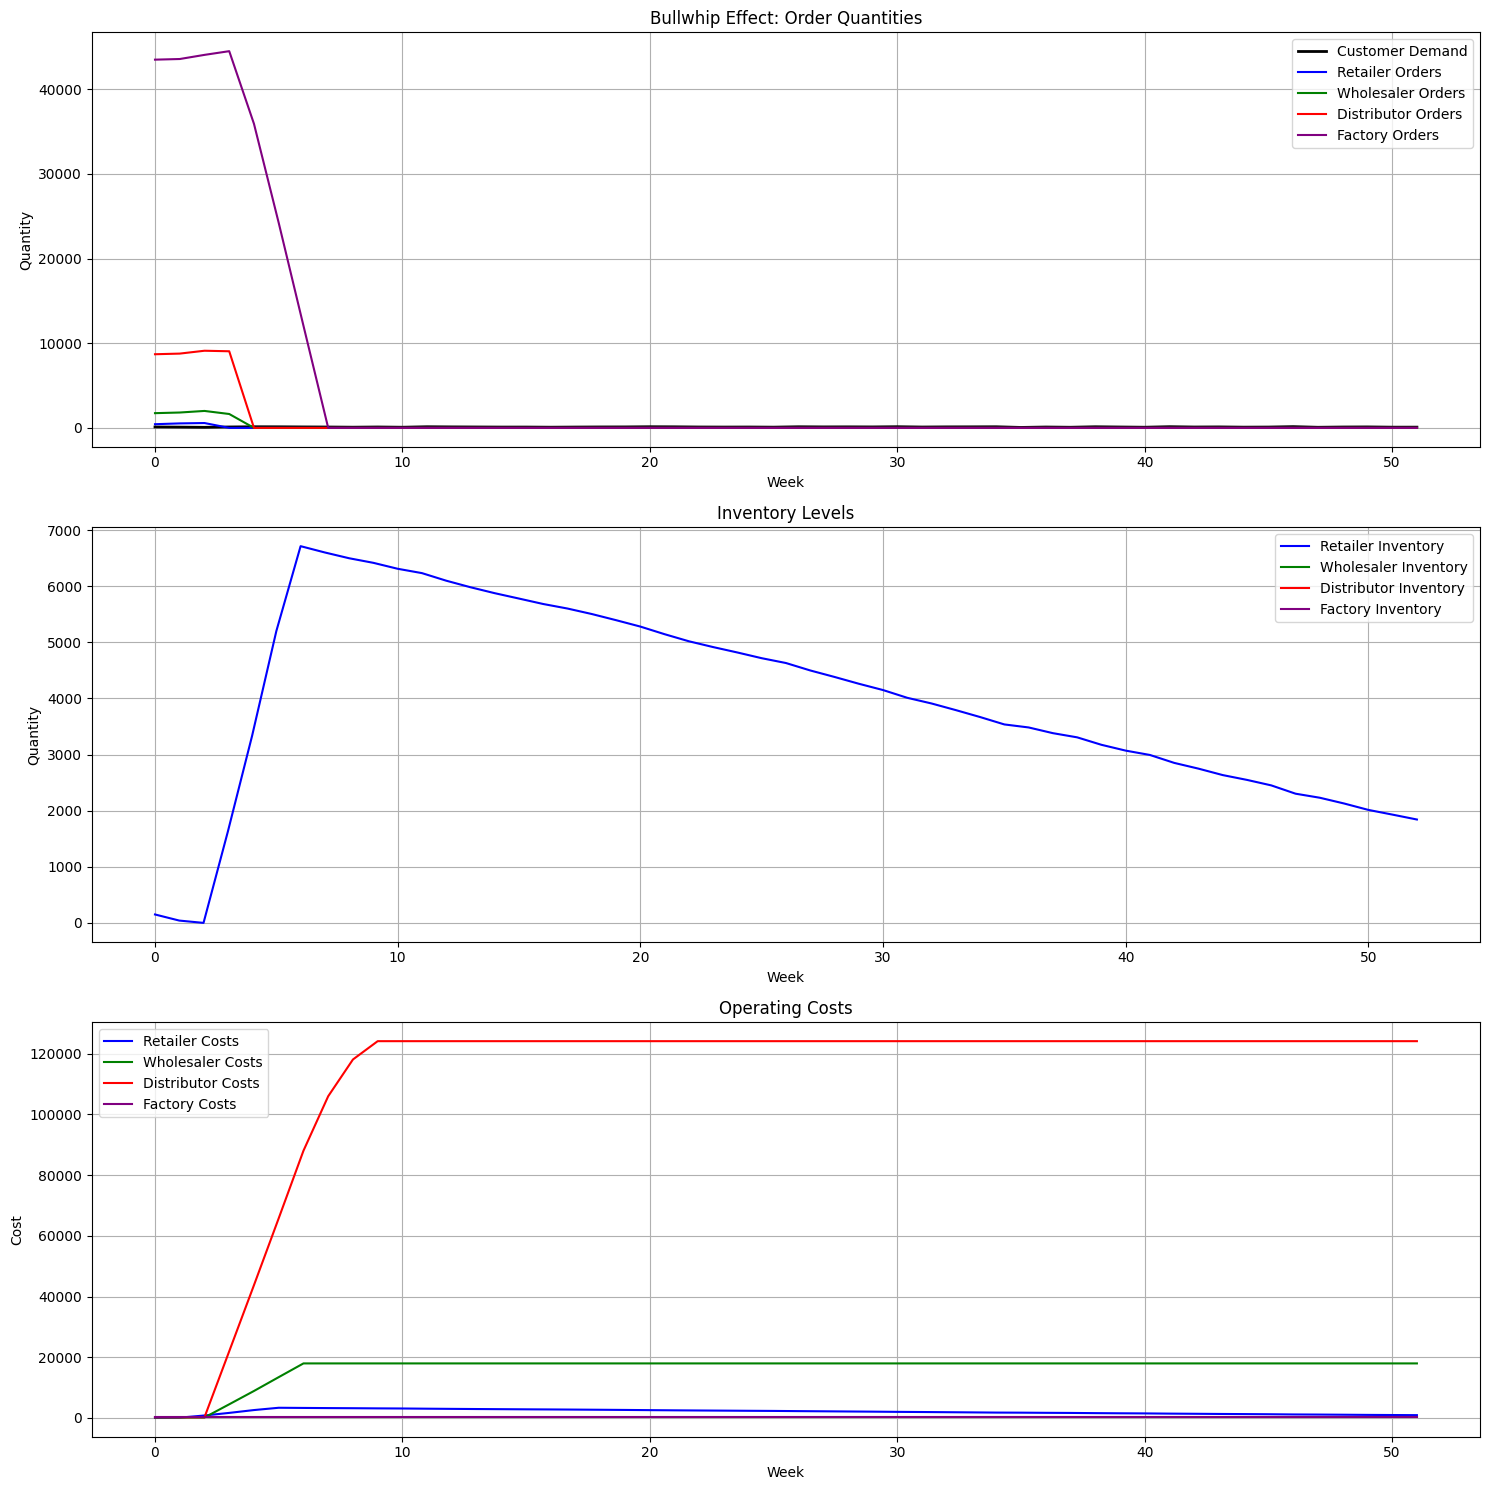


Running simulation: high_variability scenario, seasonal demand, simple ordering

Quarter 1 Performance:
Customer Demand: 103.10
Orders: R=412.41, W=1649.65, D=8248.27, F=41241.37
Stockouts: 0

Quarter 2 Performance:
Customer Demand: 119.20
Orders: R=0.00, W=0.00, D=0.00, F=0.00
Stockouts: 0

Quarter 3 Performance:
Customer Demand: 78.49
Orders: R=0.00, W=0.00, D=0.00, F=0.00
Stockouts: 0

Quarter 4 Performance:
Customer Demand: 76.10
Orders: R=0.00, W=0.00, D=0.00, F=0.00
Stockouts: 0

Simulation completed: 52 weeks
Average demand: 100.19
Demand variation: 25.92


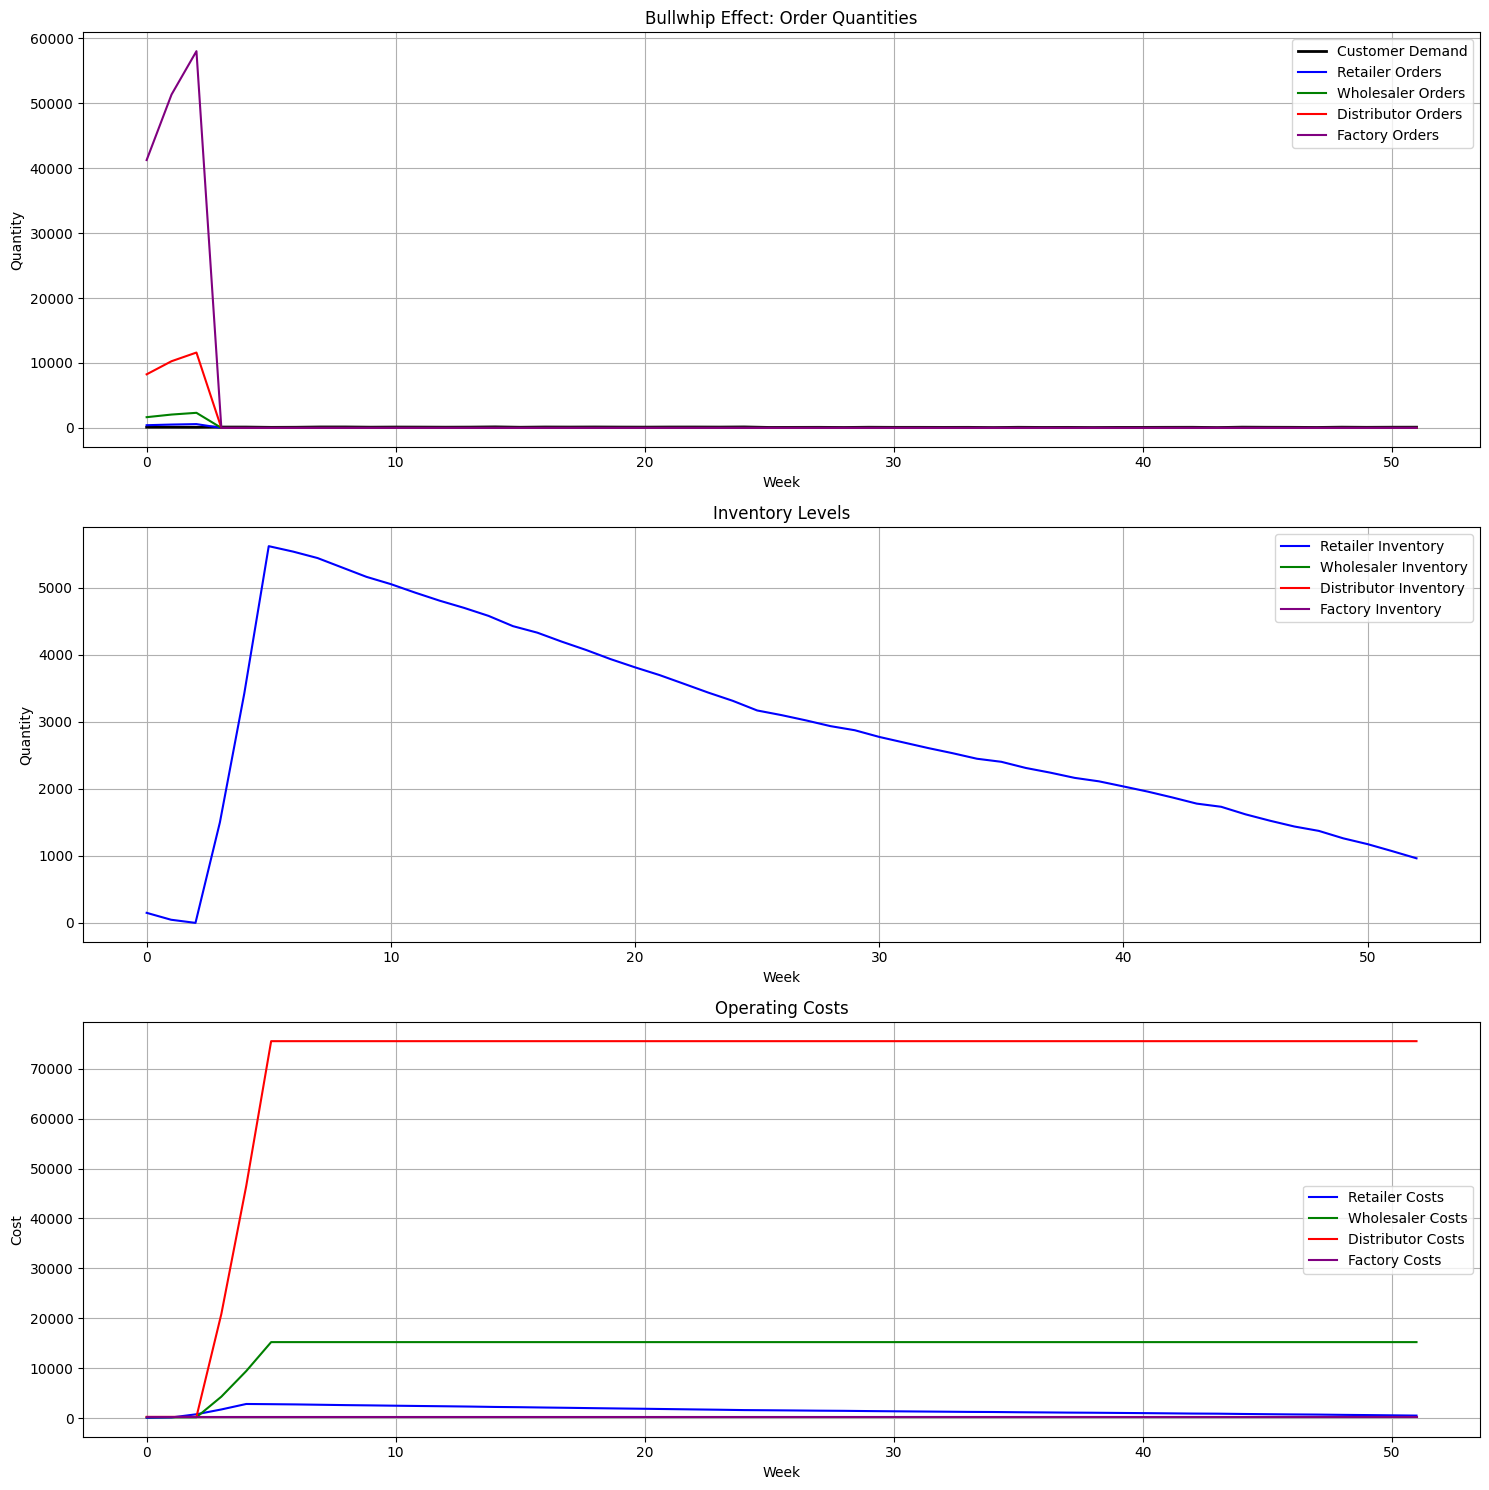


Running simulation: high_variability scenario, seasonal demand, moving_average ordering

Quarter 1 Performance:
Customer Demand: 80.36
Orders: R=321.42, W=1285.69, D=6428.43, F=32142.15
Stockouts: 0

Quarter 2 Performance:
Customer Demand: 138.21
Orders: R=0.00, W=0.00, D=0.00, F=0.00
Stockouts: 0

Quarter 3 Performance:
Customer Demand: 97.63
Orders: R=0.00, W=0.00, D=0.00, F=0.00
Stockouts: 0

Quarter 4 Performance:
Customer Demand: 83.34
Orders: R=0.00, W=0.00, D=0.00, F=0.00
Stockouts: 0

Simulation completed: 52 weeks
Average demand: 98.74
Demand variation: 29.75


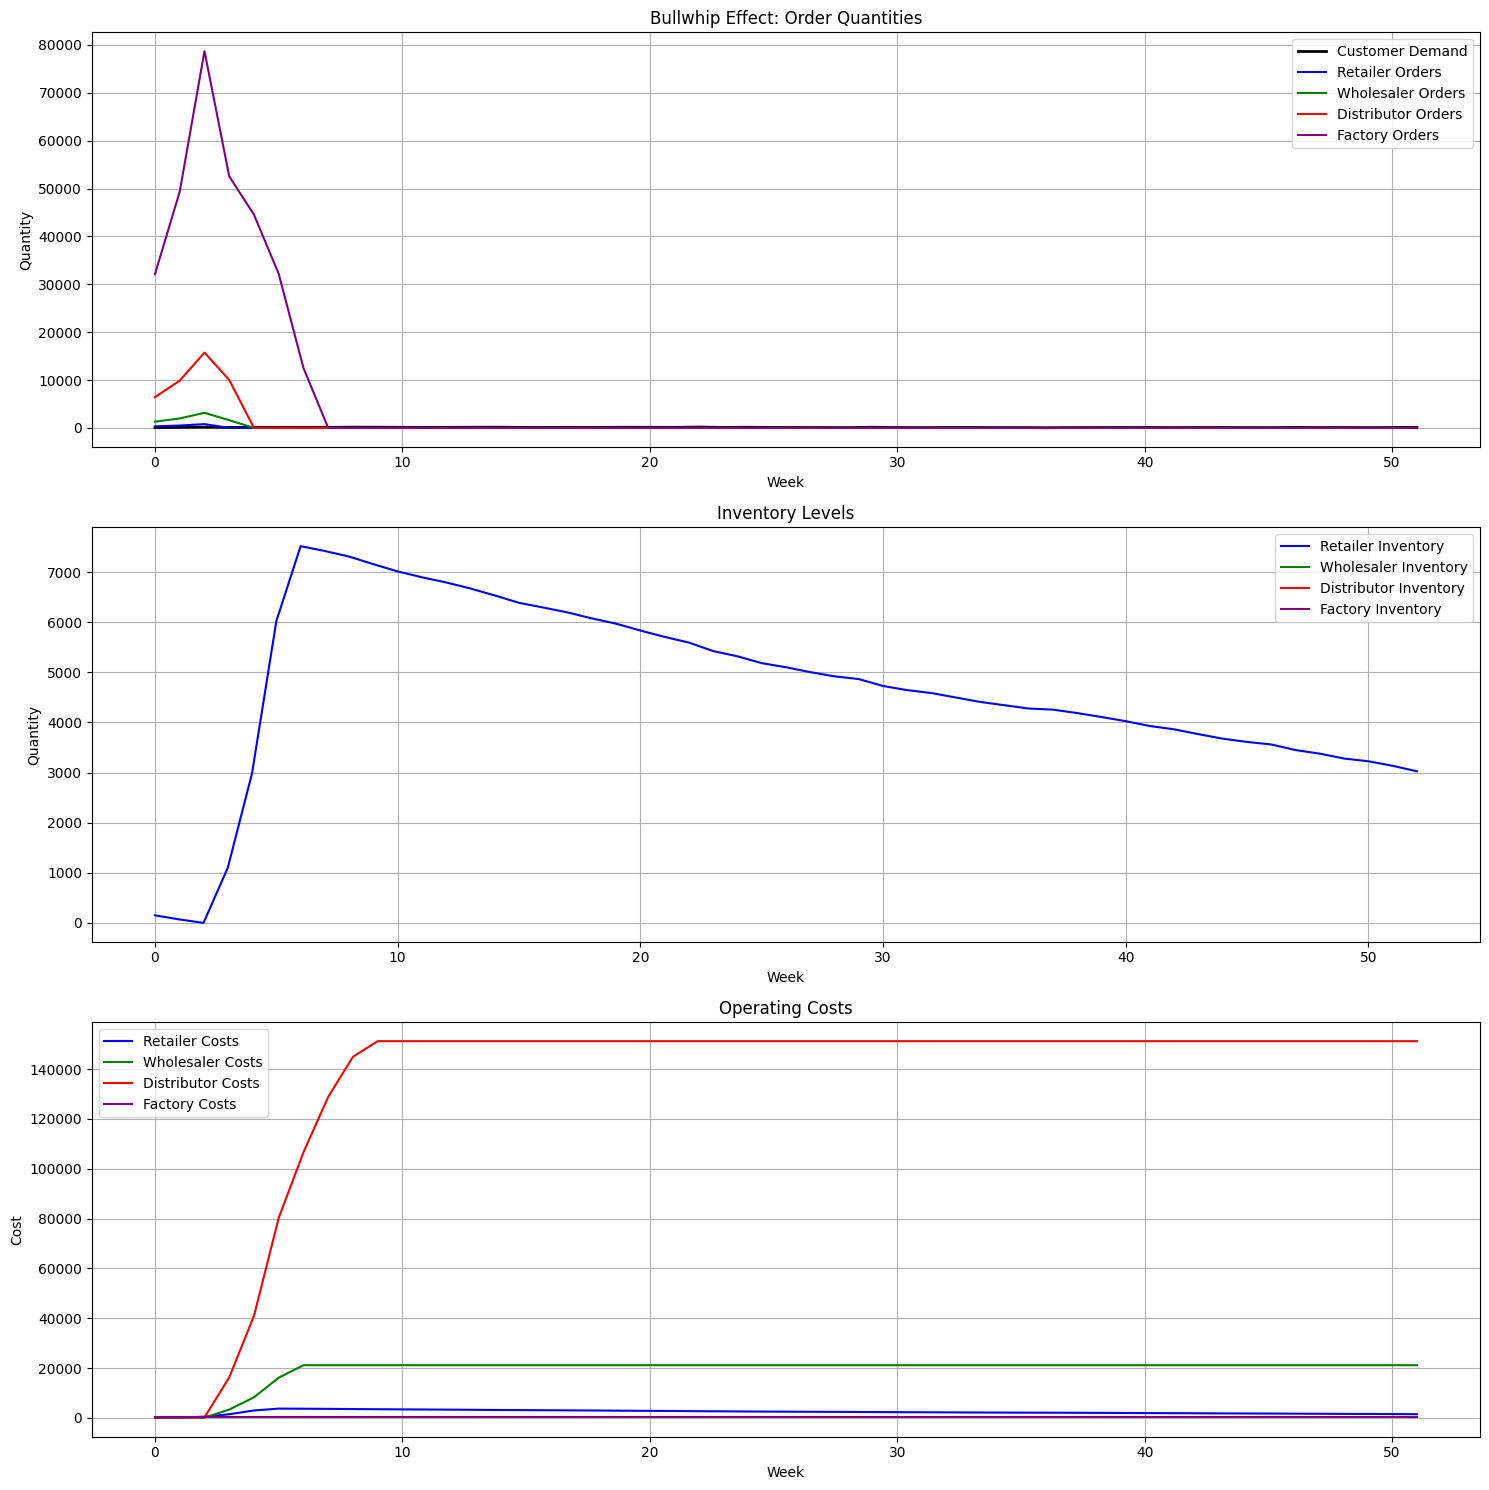


Running simulation: high_variability scenario, seasonal demand, exponential_smoothing ordering

Quarter 1 Performance:
Customer Demand: 85.00
Orders: R=340.02, W=1360.08, D=6800.38, F=34001.88
Stockouts: 0

Quarter 2 Performance:
Customer Demand: 95.73
Orders: R=0.00, W=0.00, D=0.00, F=0.00
Stockouts: 0

Quarter 3 Performance:
Customer Demand: 68.23
Orders: R=0.00, W=0.00, D=0.00, F=0.00
Stockouts: 0

Quarter 4 Performance:
Customer Demand: 96.69
Orders: R=0.00, W=0.00, D=0.00, F=0.00
Stockouts: 0

Simulation completed: 52 weeks
Average demand: 100.39
Demand variation: 29.19


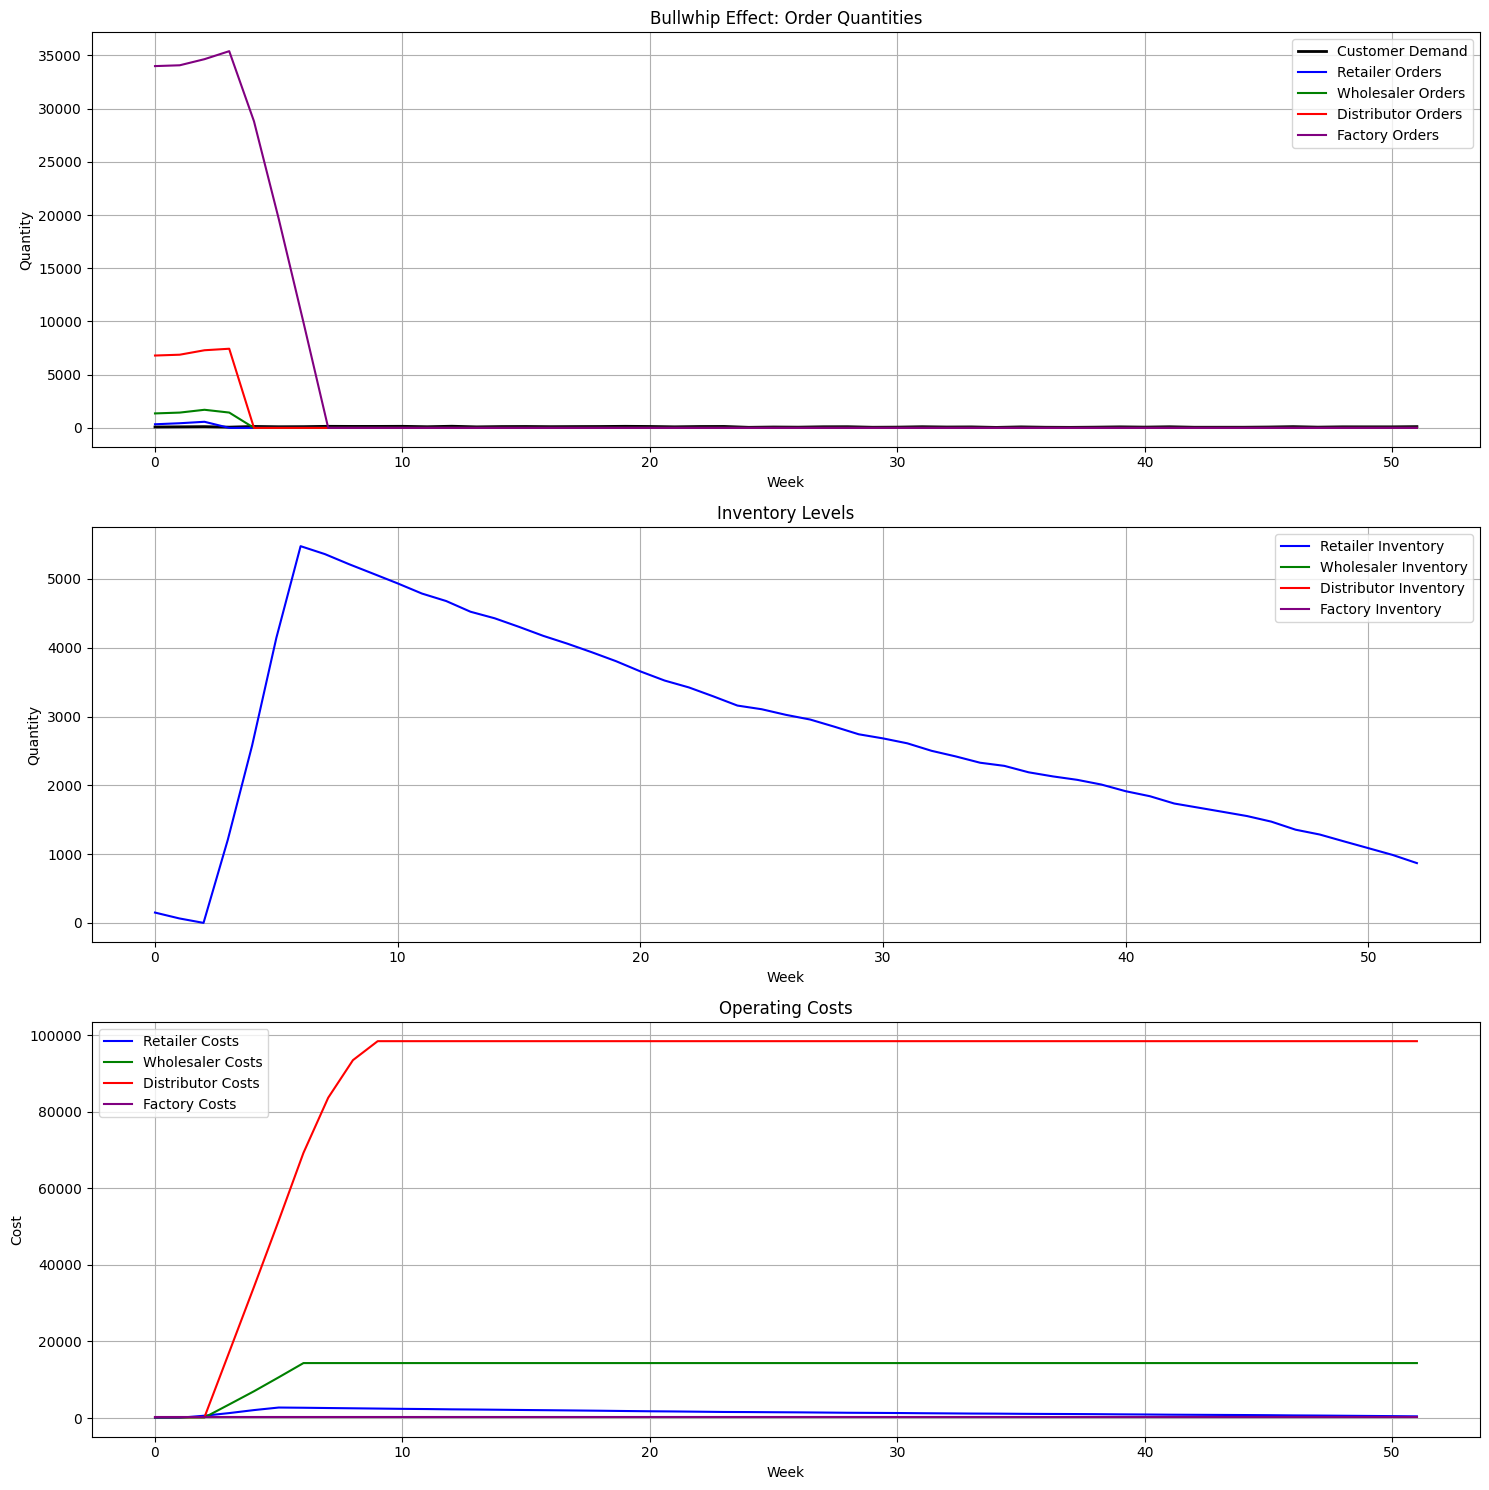


Running simulation: high_variability scenario, trend demand, simple ordering

Quarter 1 Performance:
Customer Demand: 132.00
Orders: R=528.01, W=2112.05, D=10560.23, F=52801.15
Stockouts: 0

Quarter 2 Performance:
Customer Demand: 103.30
Orders: R=0.00, W=0.00, D=0.00, F=0.00
Stockouts: 0

Quarter 3 Performance:
Customer Demand: 124.85
Orders: R=0.00, W=0.00, D=0.00, F=0.00
Stockouts: 0

Quarter 4 Performance:
Customer Demand: 126.27
Orders: R=0.00, W=0.00, D=0.00, F=0.00
Stockouts: 0

Simulation completed: 52 weeks
Average demand: 126.05
Demand variation: 25.34


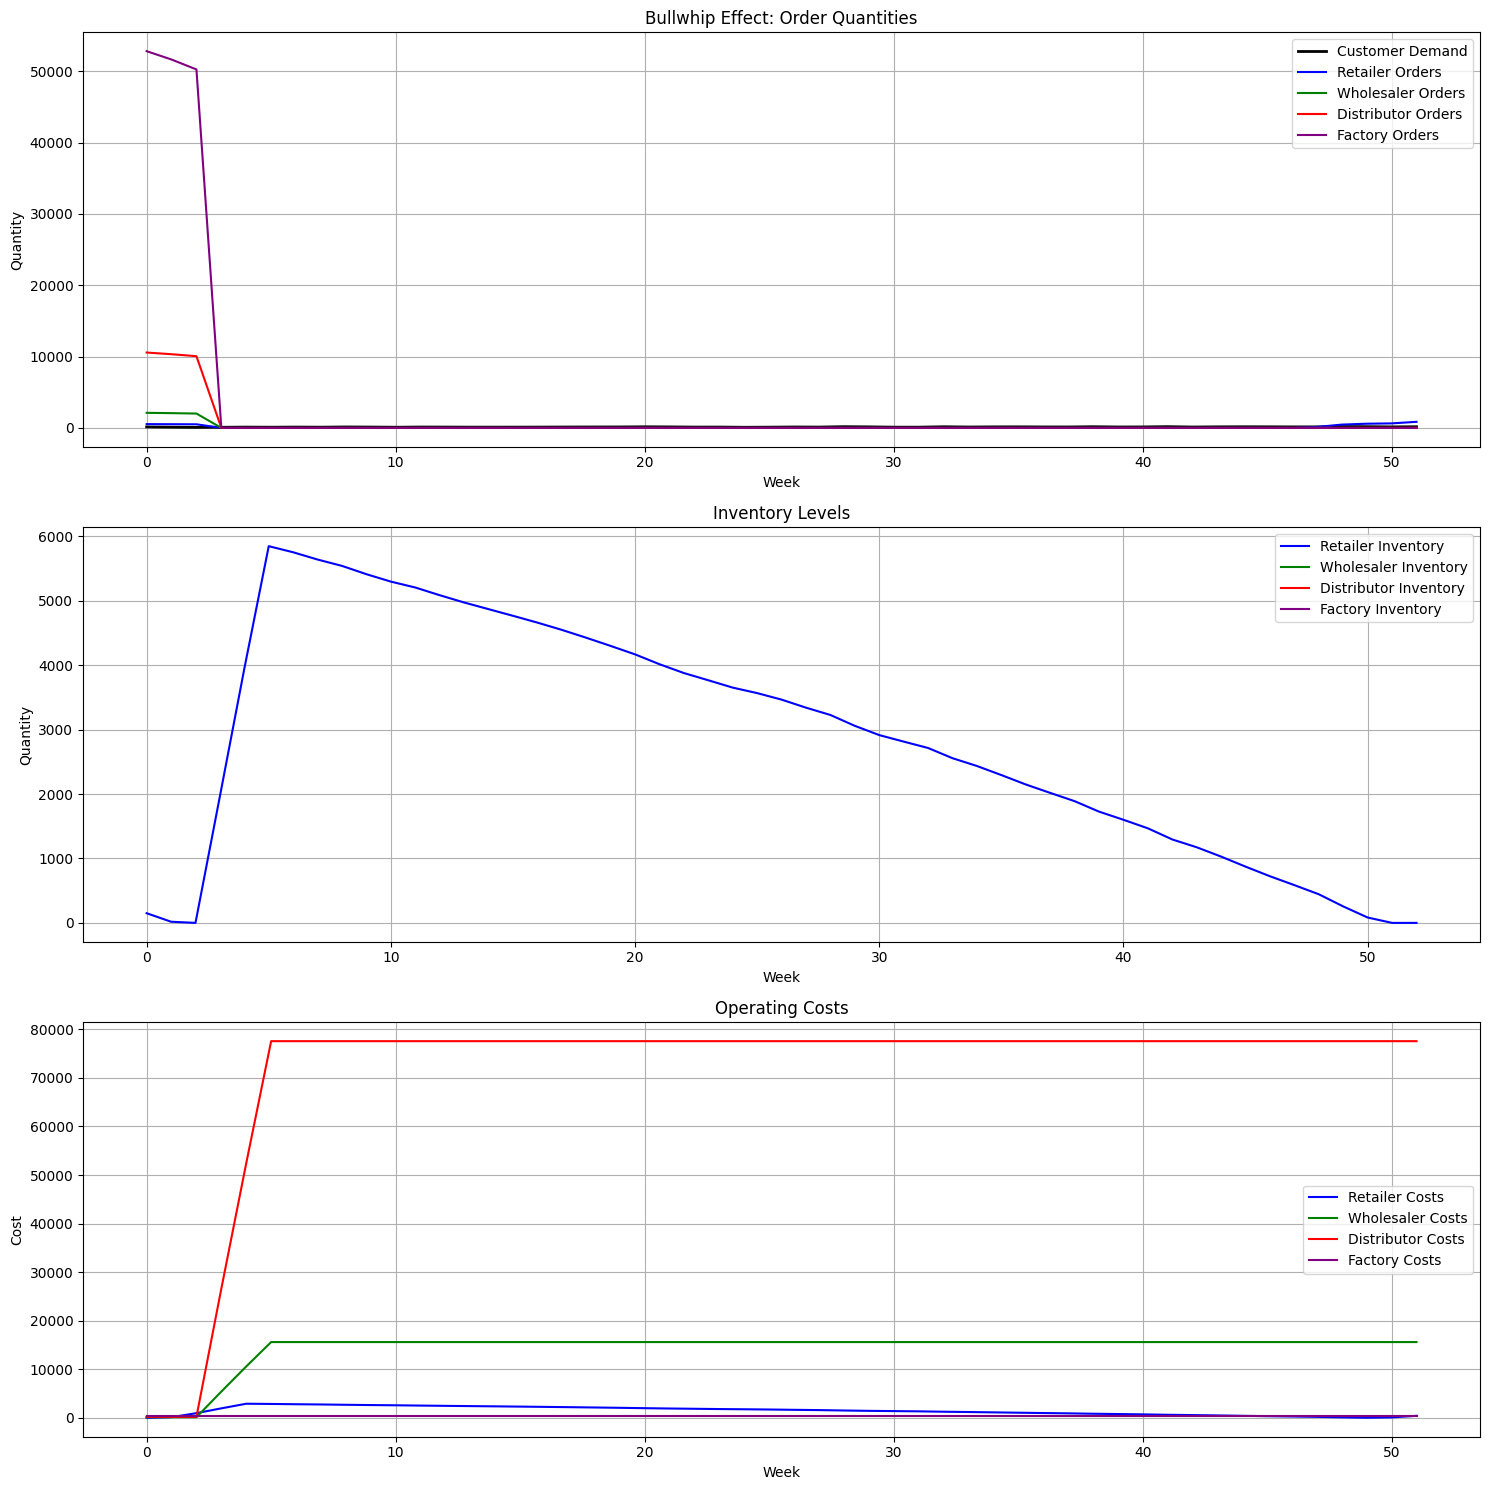


Running simulation: high_variability scenario, trend demand, moving_average ordering

Quarter 1 Performance:
Customer Demand: 103.61
Orders: R=414.43, W=1657.74, D=8288.68, F=41443.41
Stockouts: 0

Quarter 2 Performance:
Customer Demand: 117.18
Orders: R=0.00, W=0.00, D=0.00, F=0.00
Stockouts: 0

Quarter 3 Performance:
Customer Demand: 142.72
Orders: R=0.00, W=0.00, D=0.00, F=0.00
Stockouts: 0

Quarter 4 Performance:
Customer Demand: 101.58
Orders: R=0.00, W=0.00, D=0.00, F=0.00
Stockouts: 0

Simulation completed: 52 weeks
Average demand: 127.49
Demand variation: 21.05


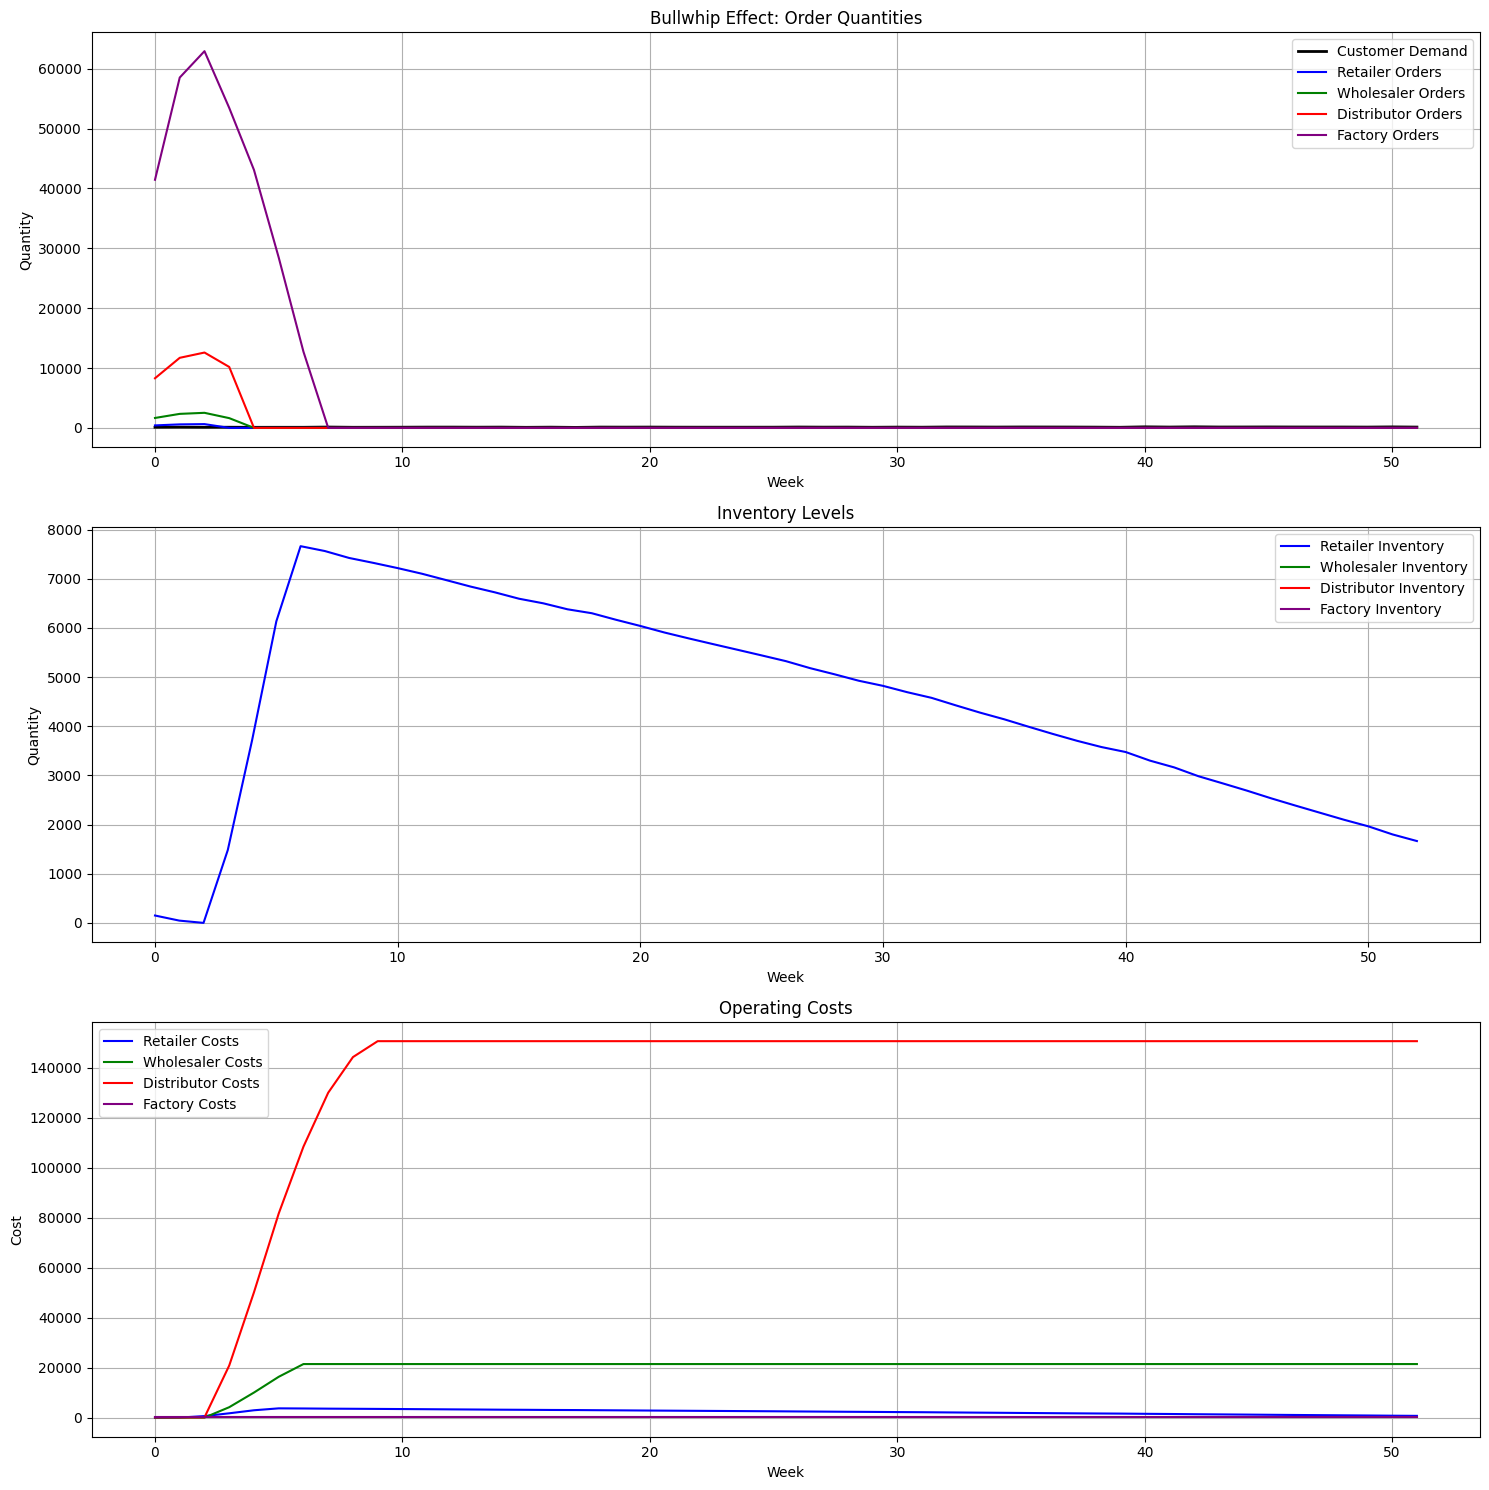


Running simulation: high_variability scenario, trend demand, exponential_smoothing ordering

Quarter 1 Performance:
Customer Demand: 74.88
Orders: R=299.54, W=1198.16, D=5990.79, F=29953.94
Stockouts: 0

Quarter 2 Performance:
Customer Demand: 123.40
Orders: R=0.00, W=0.00, D=0.00, F=0.00
Stockouts: 0

Quarter 3 Performance:
Customer Demand: 134.20
Orders: R=0.00, W=0.00, D=0.00, F=0.00
Stockouts: 0

Quarter 4 Performance:
Customer Demand: 132.12
Orders: R=0.00, W=0.00, D=0.00, F=0.00
Stockouts: 0

Simulation completed: 52 weeks
Average demand: 125.89
Demand variation: 22.71


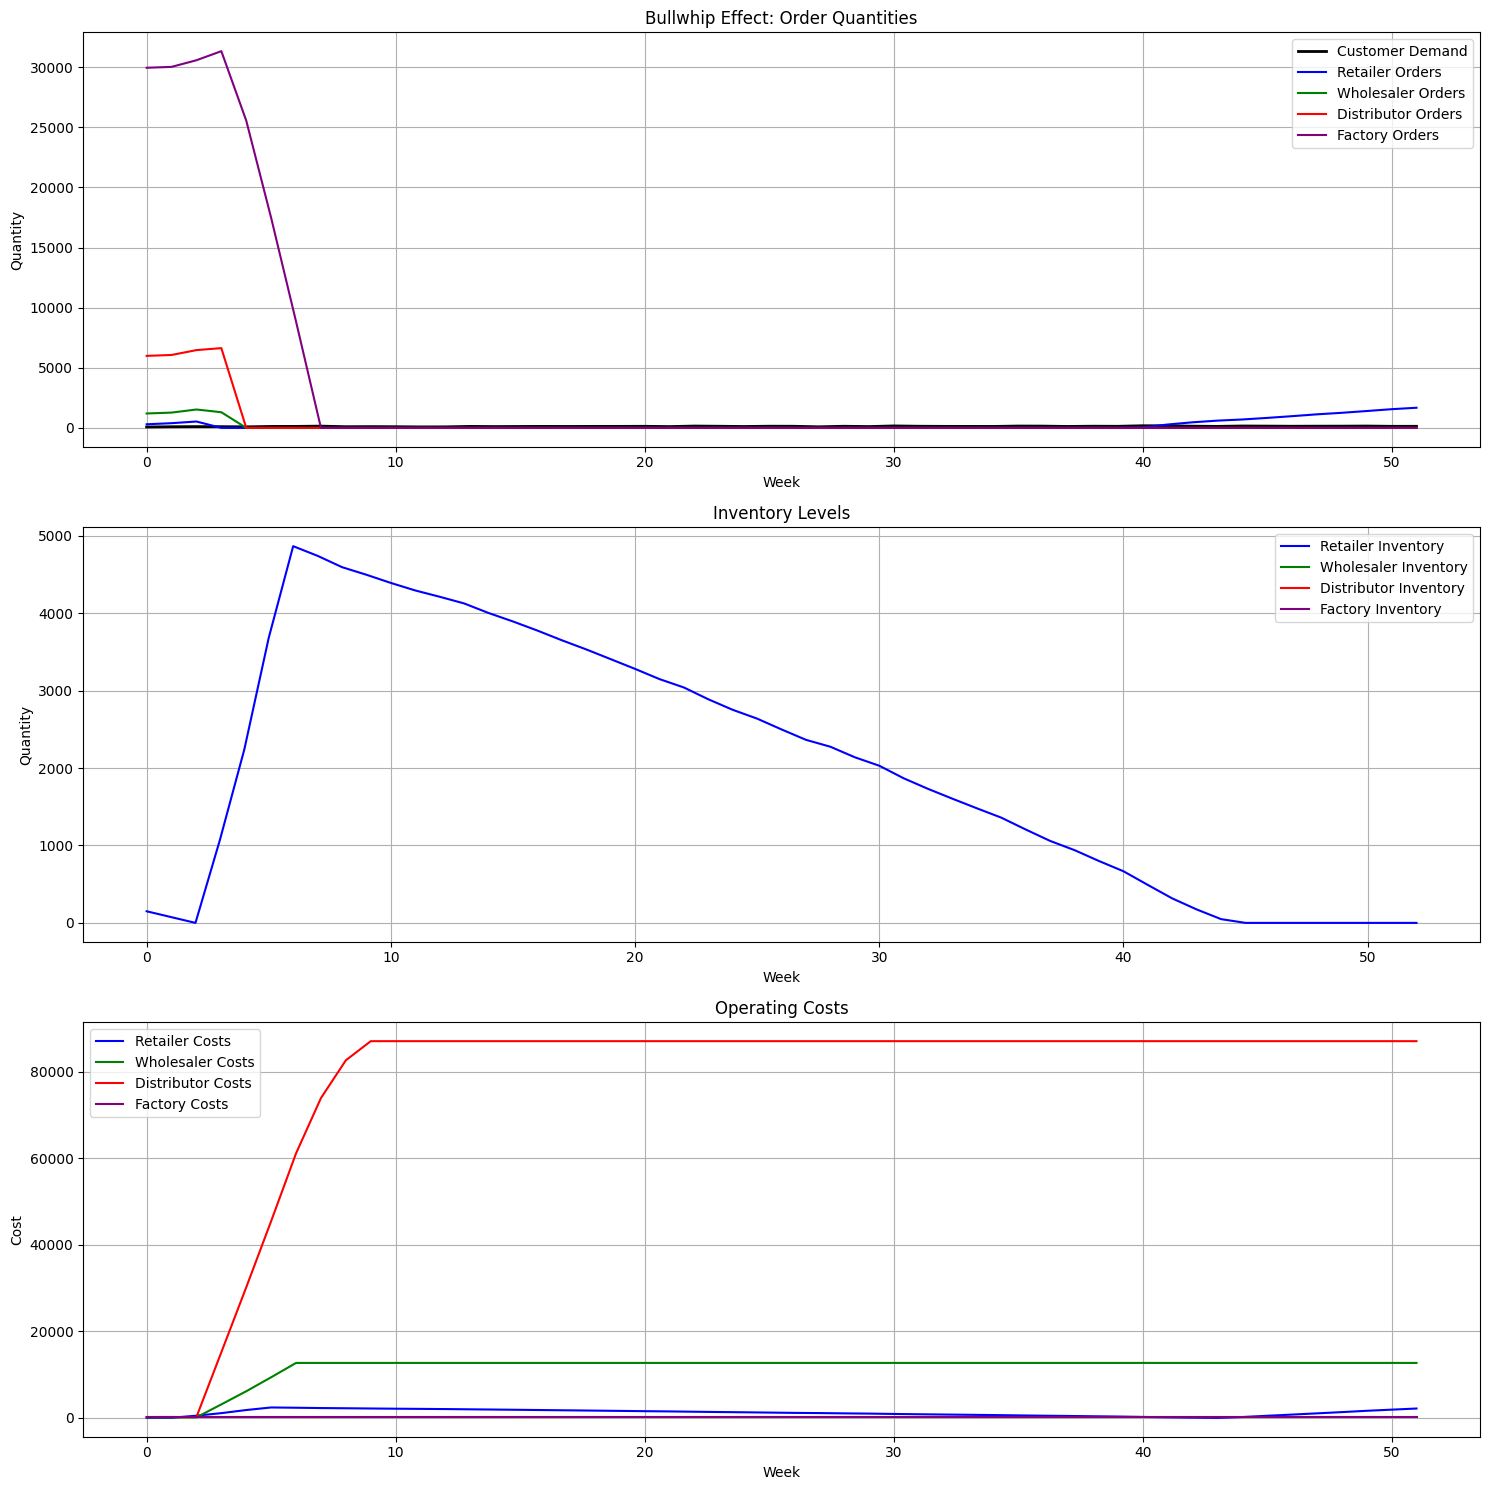


Running simulation: lean scenario, normal demand, simple ordering

Quarter 1 Performance:
Customer Demand: 81.01
Orders: R=162.03, W=324.05, D=972.16, F=2916.48
Stockouts: 0

Quarter 2 Performance:
Customer Demand: 77.69
Orders: R=497.84, W=18.65, D=0.00, F=0.00
Stockouts: 1

Quarter 3 Performance:
Customer Demand: 91.50
Orders: R=589.38, W=201.72, D=0.00, F=0.00
Stockouts: 1

Quarter 4 Performance:
Customer Demand: 56.60
Orders: R=460.42, W=0.00, D=0.00, F=0.00
Stockouts: 1

Simulation completed: 52 weeks
Average demand: 98.58
Demand variation: 20.49


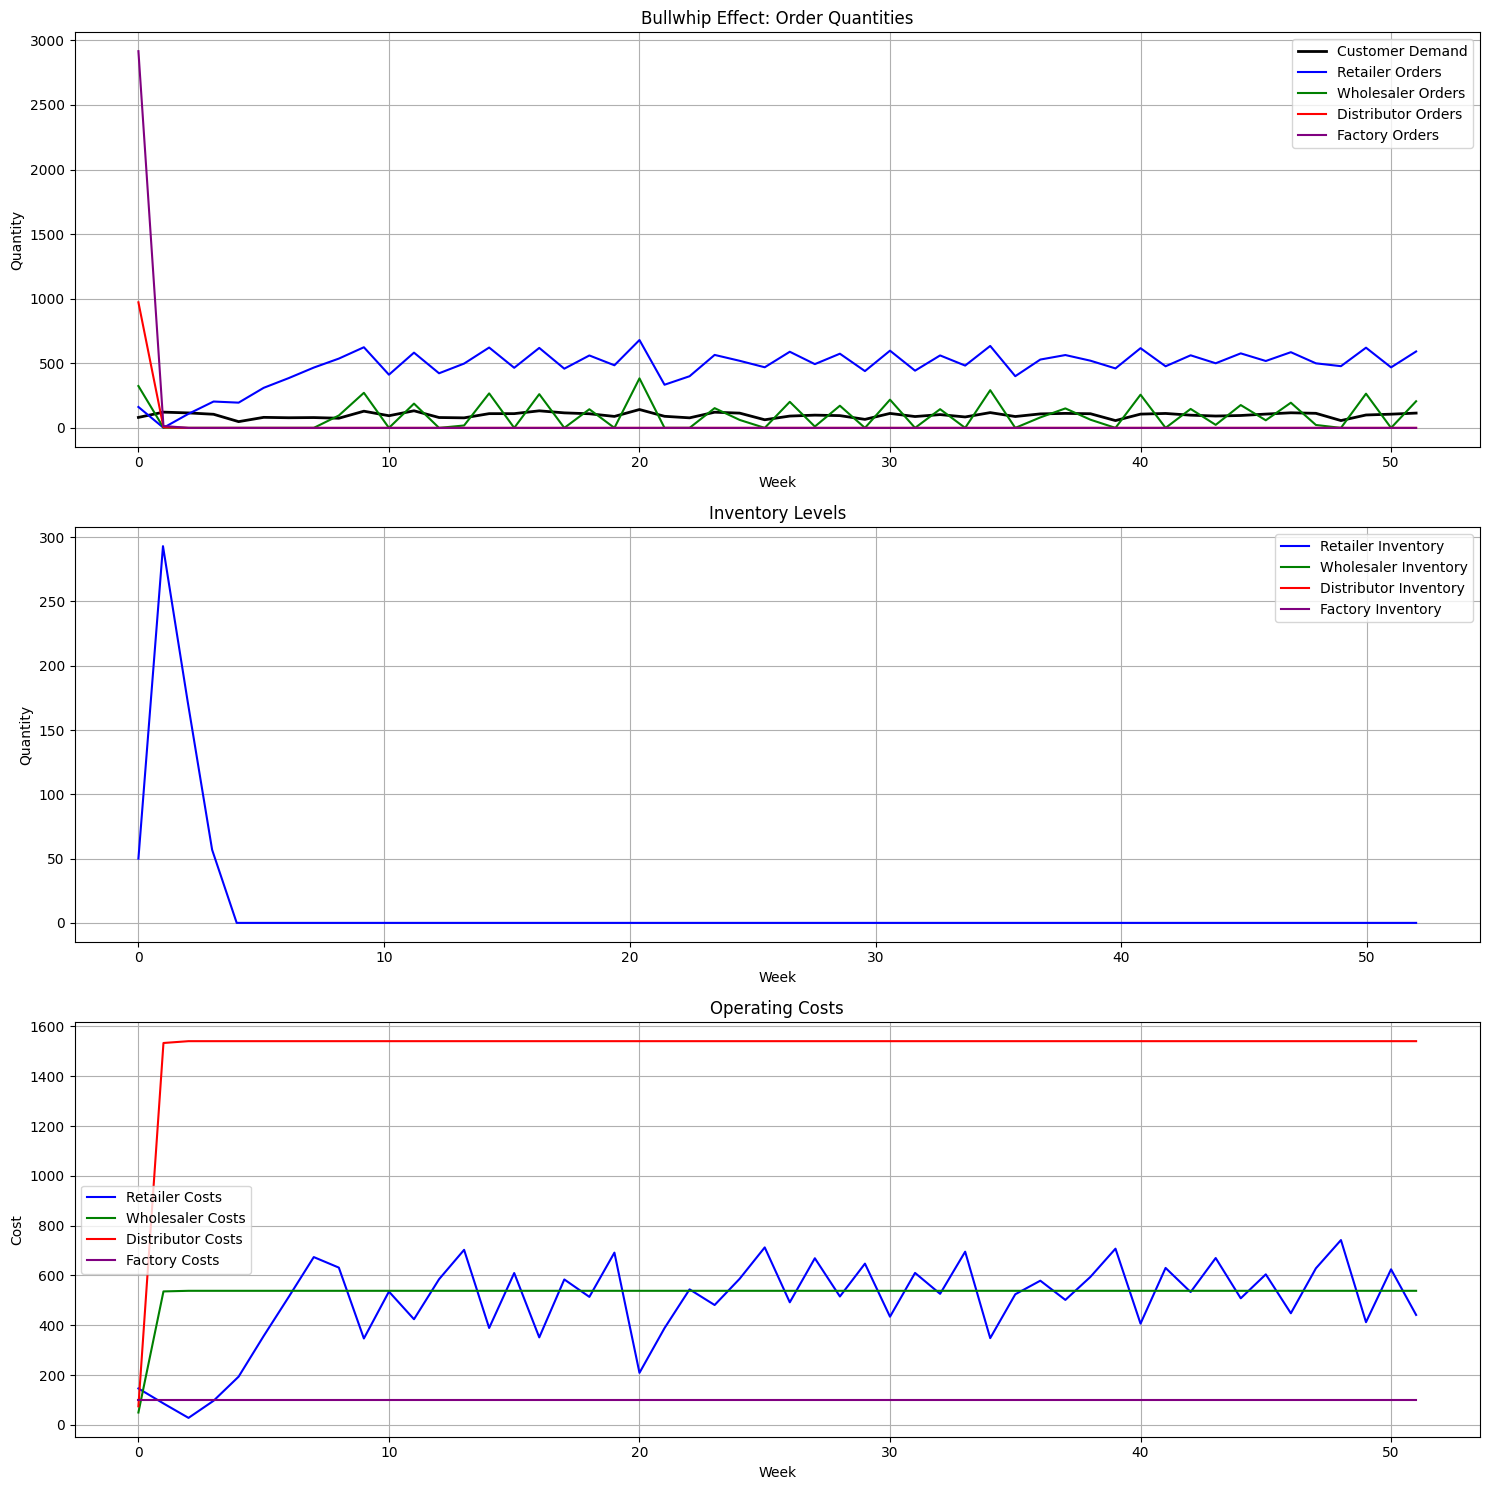


Running simulation: lean scenario, normal demand, moving_average ordering

Quarter 1 Performance:
Customer Demand: 91.25
Orders: R=182.49, W=364.99, D=1094.97, F=3284.91
Stockouts: 0

Quarter 2 Performance:
Customer Demand: 99.28
Orders: R=381.78, W=109.82, D=0.00, F=0.00
Stockouts: 1

Quarter 3 Performance:
Customer Demand: 119.61
Orders: R=724.13, W=260.39, D=0.00, F=0.00
Stockouts: 1

Quarter 4 Performance:
Customer Demand: 119.05
Orders: R=715.06, W=5.60, D=0.00, F=0.00
Stockouts: 1

Simulation completed: 52 weeks
Average demand: 100.12
Demand variation: 16.91


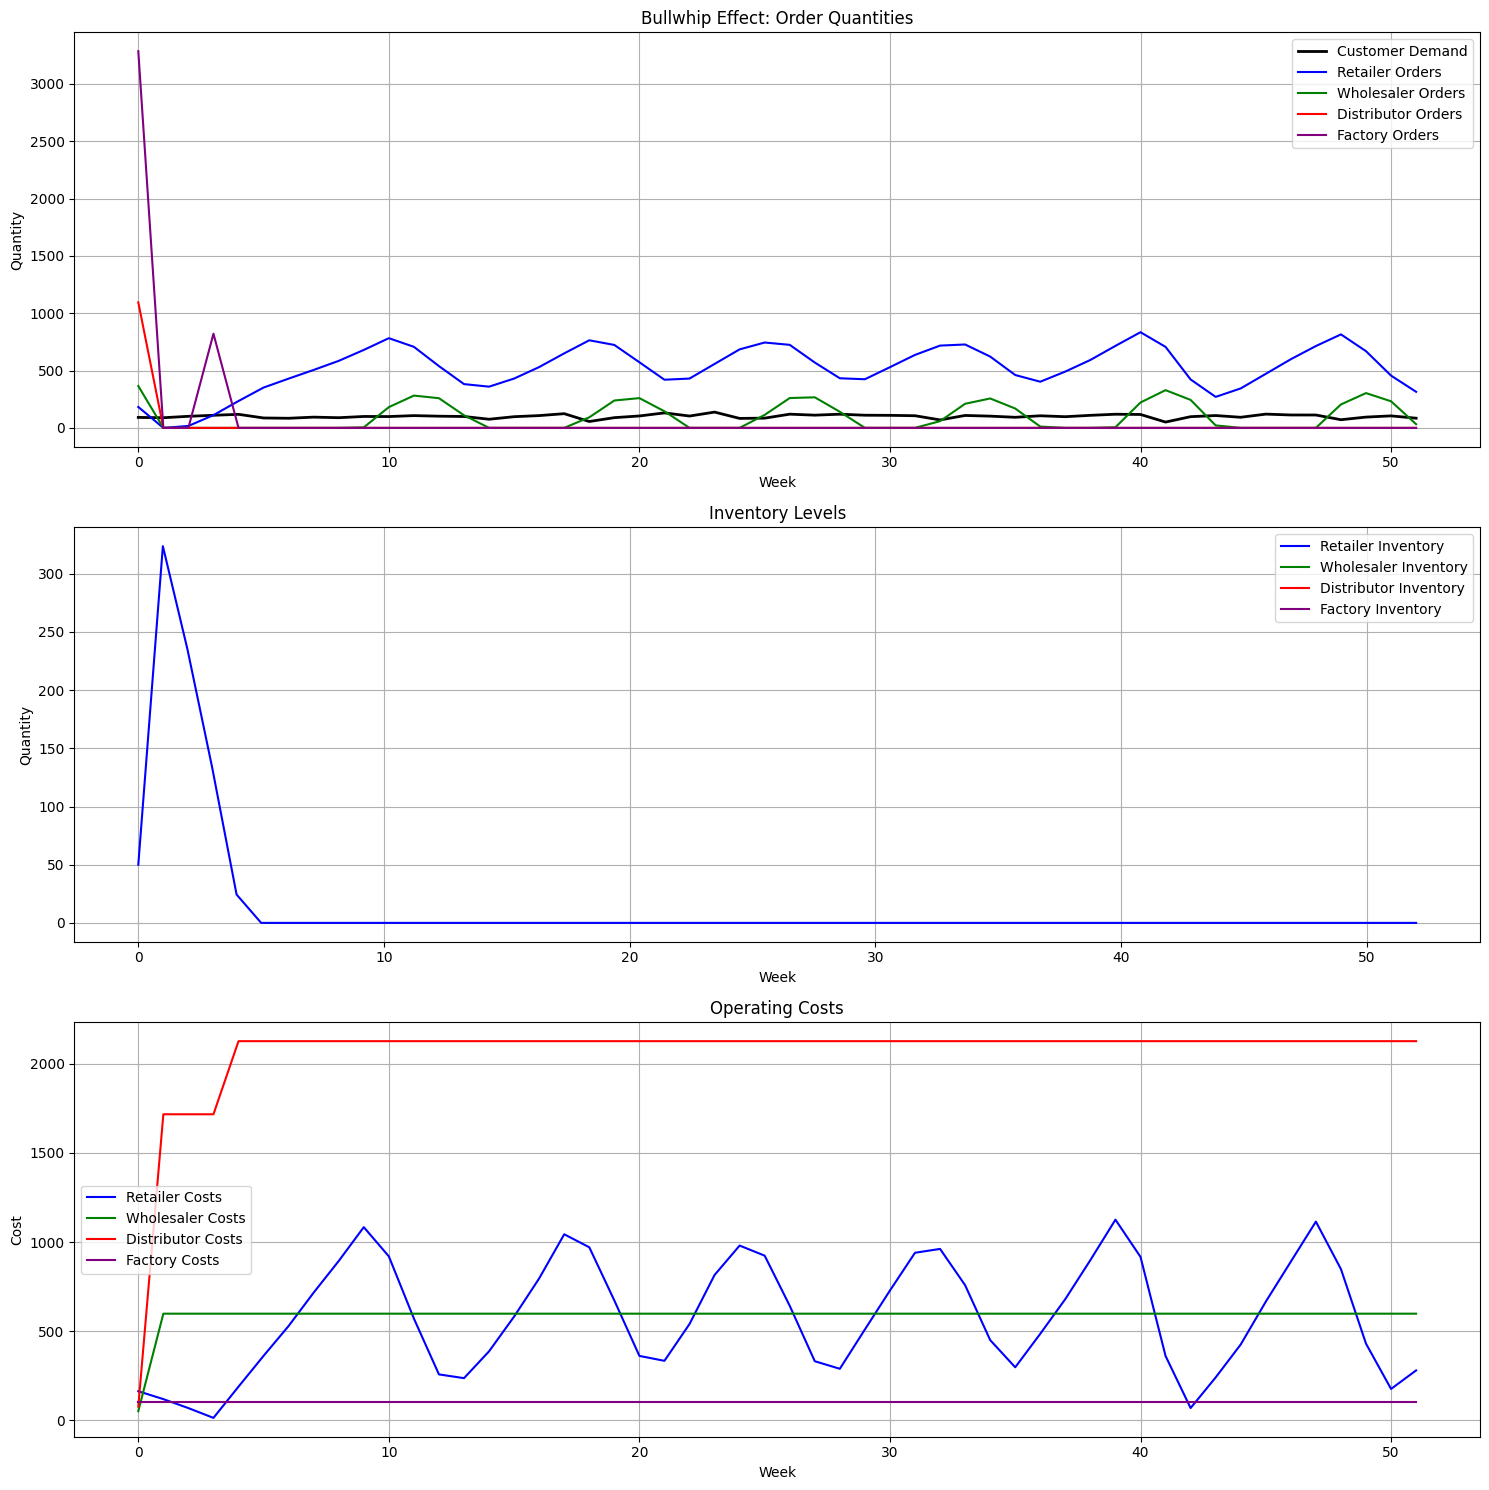


Running simulation: lean scenario, normal demand, exponential_smoothing ordering

Quarter 1 Performance:
Customer Demand: 92.25
Orders: R=184.50, W=369.00, D=1107.00, F=3320.99
Stockouts: 0

Quarter 2 Performance:
Customer Demand: 124.26
Orders: R=889.29, W=0.00, D=0.00, F=0.00
Stockouts: 1

Quarter 3 Performance:
Customer Demand: 109.24
Orders: R=1251.21, W=46.40, D=0.00, F=0.00
Stockouts: 1

Quarter 4 Performance:
Customer Demand: 81.50
Orders: R=628.10, W=0.00, D=0.00, F=0.00
Stockouts: 1

Simulation completed: 52 weeks
Average demand: 105.78
Demand variation: 23.13


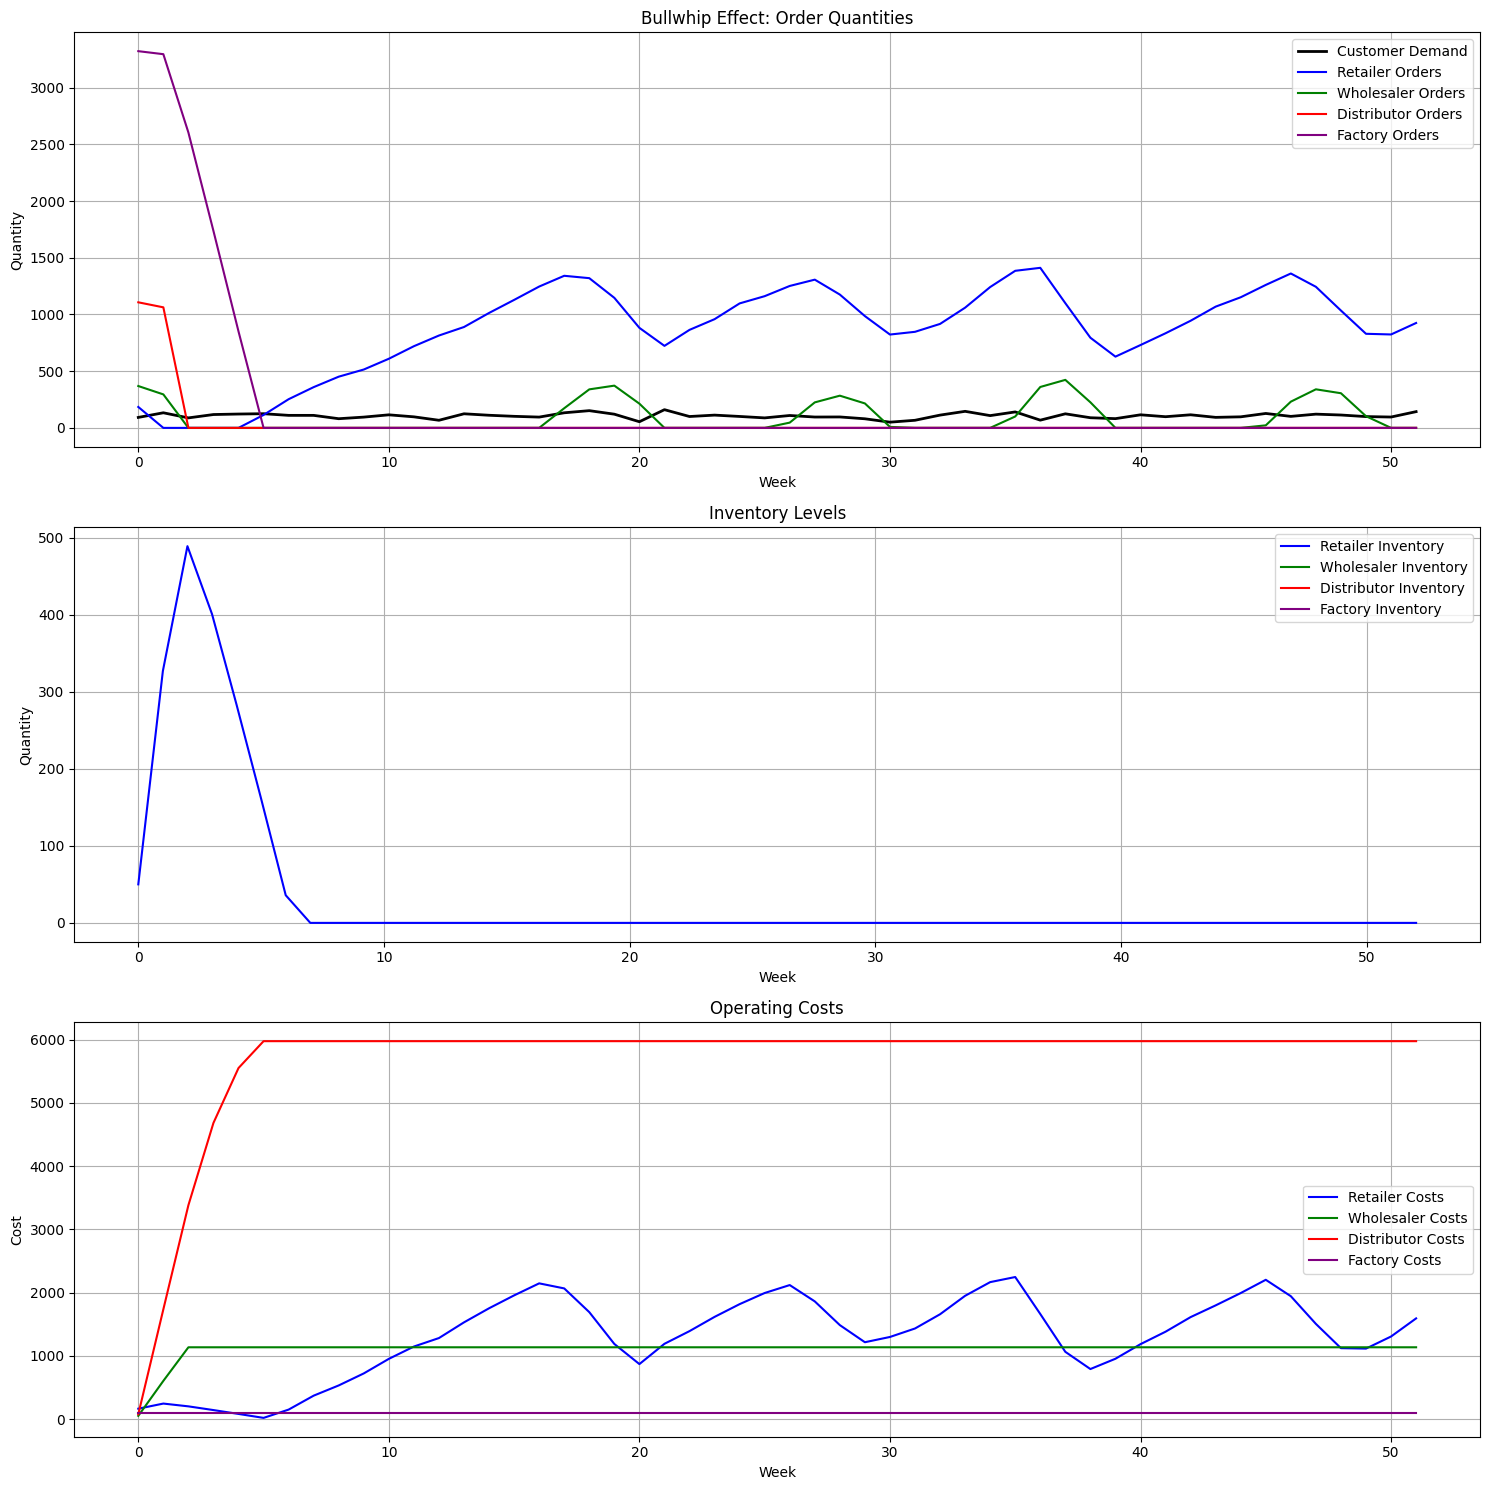


Running simulation: lean scenario, seasonal demand, simple ordering

Quarter 1 Performance:
Customer Demand: 82.55
Orders: R=165.10, W=330.19, D=990.58, F=2971.73
Stockouts: 0

Quarter 2 Performance:
Customer Demand: 136.98
Orders: R=611.95, W=233.33, D=0.00, F=0.00
Stockouts: 1

Quarter 3 Performance:
Customer Demand: 101.39
Orders: R=544.45, W=98.32, D=0.00, F=0.00
Stockouts: 1

Quarter 4 Performance:
Customer Demand: 63.82
Orders: R=469.33, W=0.00, D=0.00, F=0.00
Stockouts: 1

Simulation completed: 52 weeks
Average demand: 97.27
Demand variation: 26.05


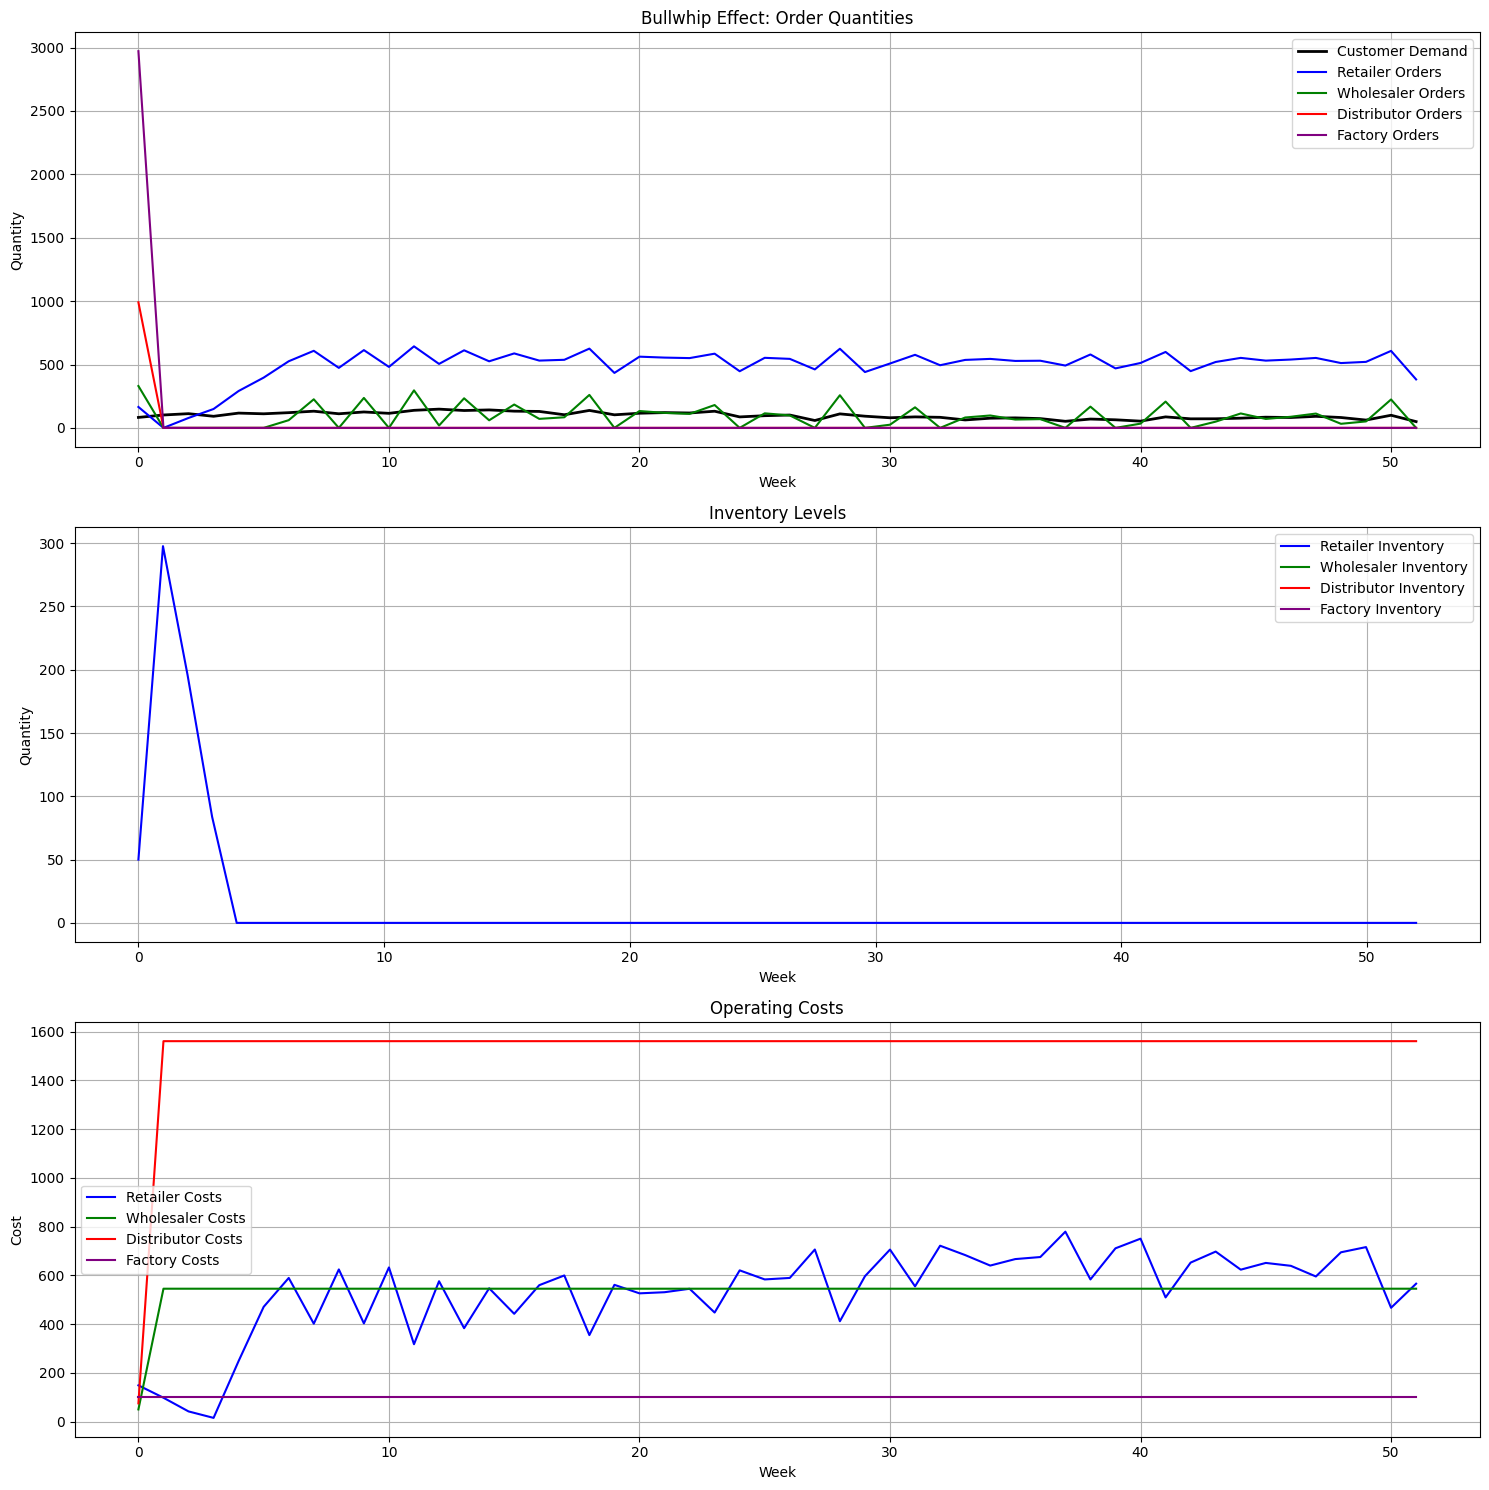


Running simulation: lean scenario, seasonal demand, moving_average ordering

Quarter 1 Performance:
Customer Demand: 75.46
Orders: R=150.93, W=301.86, D=905.58, F=2716.73
Stockouts: 0

Quarter 2 Performance:
Customer Demand: 158.09
Orders: R=569.99, W=0.00, D=0.00, F=0.00
Stockouts: 1

Quarter 3 Performance:
Customer Demand: 79.06
Orders: R=569.07, W=264.14, D=0.00, F=0.00
Stockouts: 1

Quarter 4 Performance:
Customer Demand: 83.75
Orders: R=578.96, W=0.00, D=0.00, F=0.00
Stockouts: 1

Simulation completed: 52 weeks
Average demand: 98.74
Demand variation: 29.48


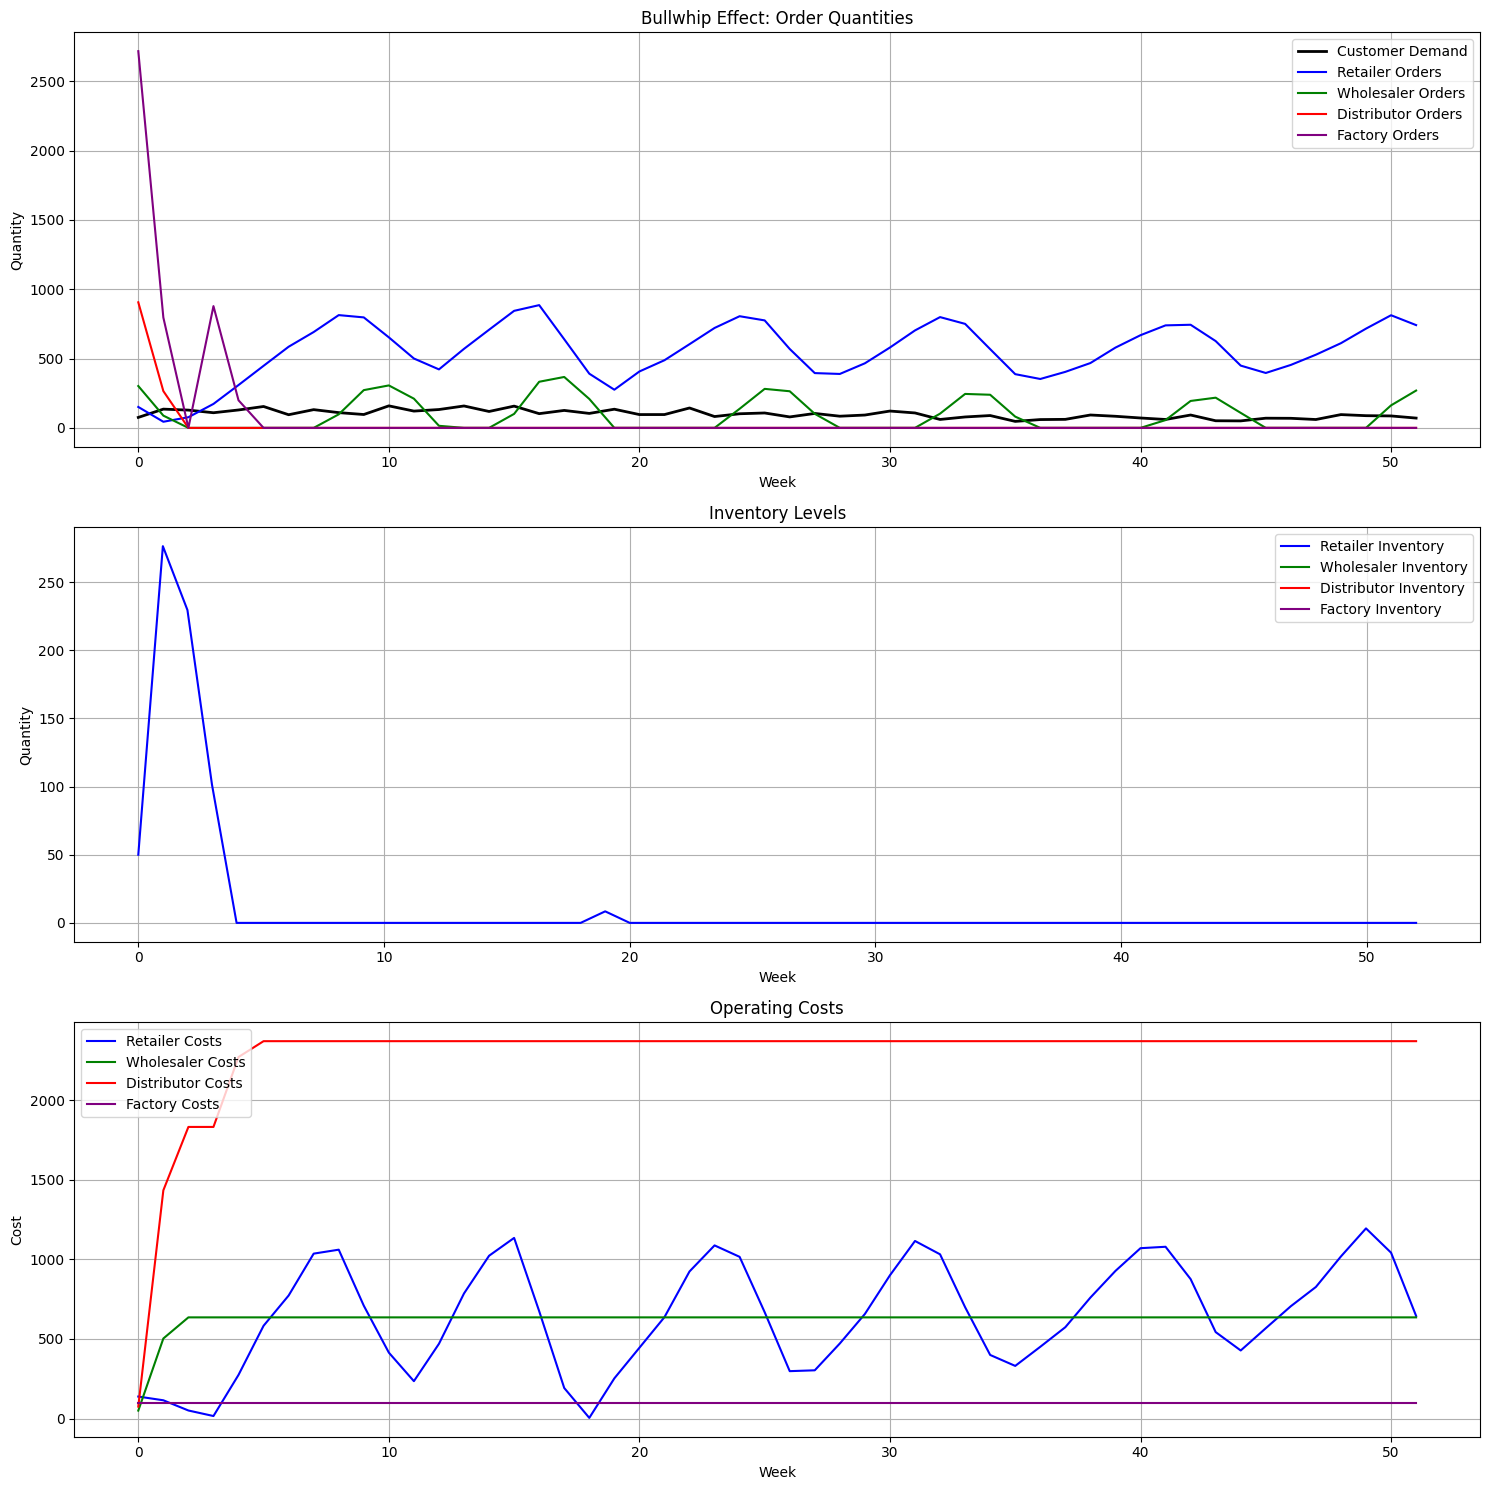


Running simulation: lean scenario, seasonal demand, exponential_smoothing ordering

Quarter 1 Performance:
Customer Demand: 80.66
Orders: R=161.32, W=322.64, D=967.91, F=2903.74
Stockouts: 0

Quarter 2 Performance:
Customer Demand: 96.58
Orders: R=1281.45, W=283.96, D=0.00, F=0.00
Stockouts: 1

Quarter 3 Performance:
Customer Demand: 73.23
Orders: R=709.96, W=0.00, D=0.00, F=0.00
Stockouts: 1

Quarter 4 Performance:
Customer Demand: 58.88
Orders: R=1072.35, W=78.21, D=0.00, F=0.00
Stockouts: 1

Simulation completed: 52 weeks
Average demand: 97.92
Demand variation: 34.23


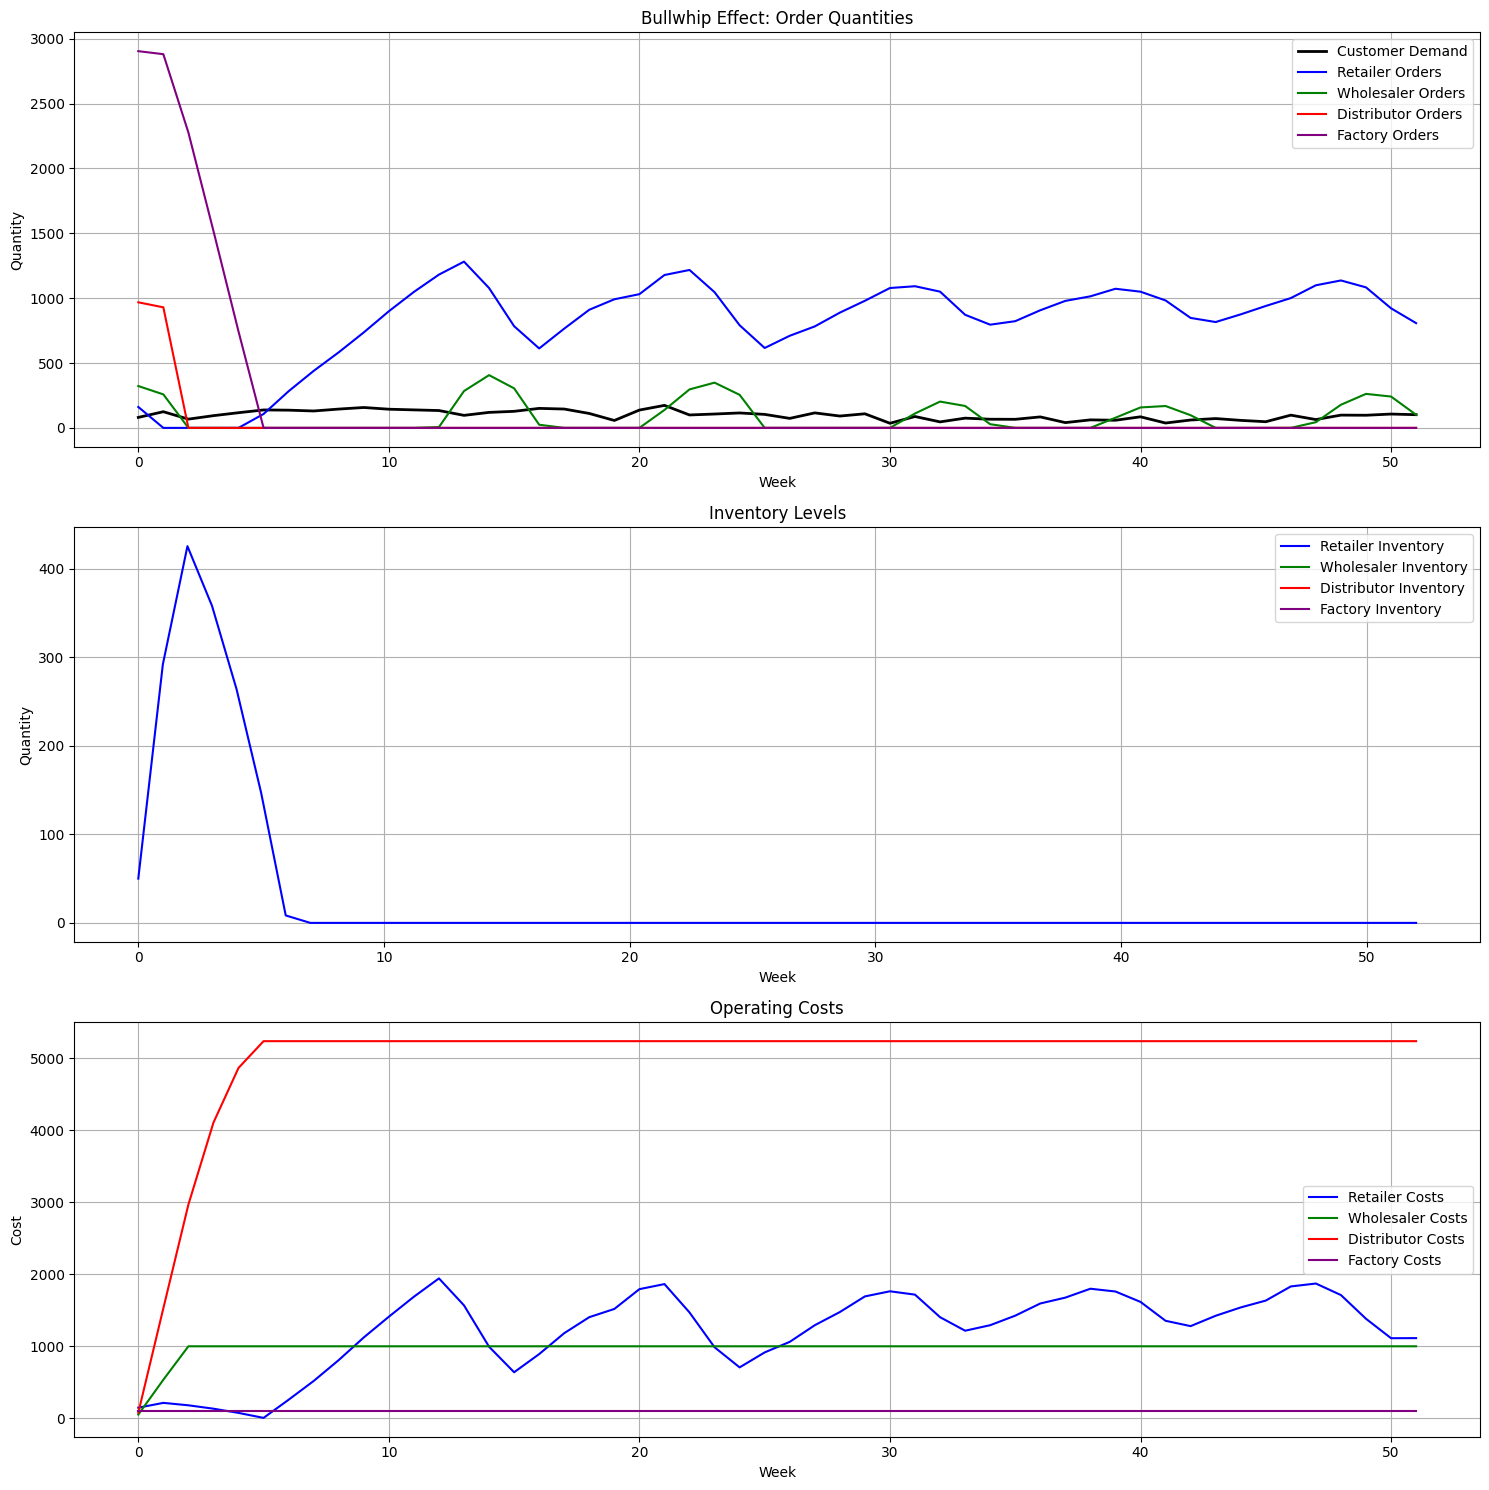


Running simulation: lean scenario, trend demand, simple ordering

Quarter 1 Performance:
Customer Demand: 121.07
Orders: R=242.14, W=484.28, D=1452.85, F=4358.55
Stockouts: 0

Quarter 2 Performance:
Customer Demand: 111.39
Orders: R=785.85, W=118.85, D=0.00, F=0.00
Stockouts: 1

Quarter 3 Performance:
Customer Demand: 129.91
Orders: R=830.91, W=208.97, D=0.00, F=0.00
Stockouts: 1

Quarter 4 Performance:
Customer Demand: 138.76
Orders: R=849.64, W=246.42, D=0.00, F=0.00
Stockouts: 1

Simulation completed: 52 weeks
Average demand: 126.58
Demand variation: 24.12


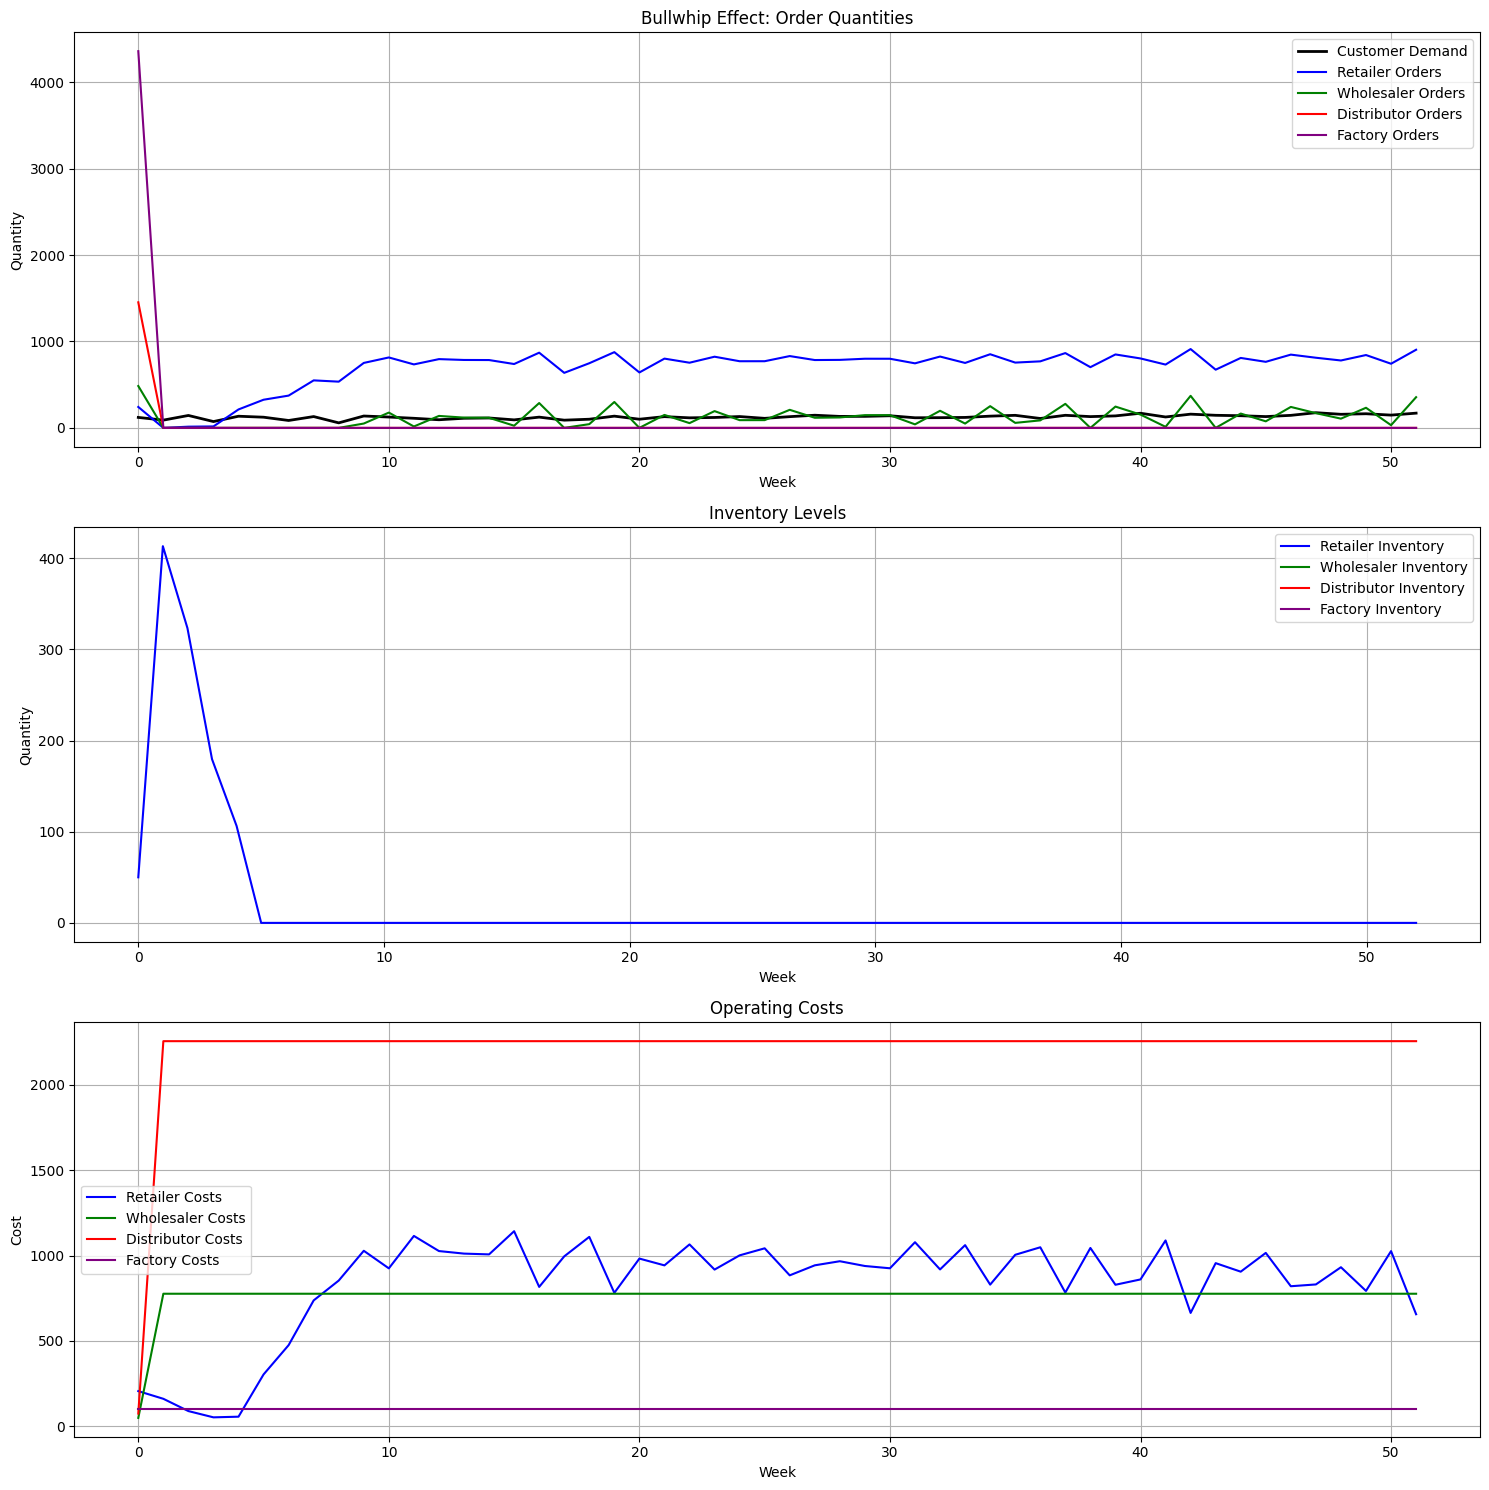


Running simulation: lean scenario, trend demand, moving_average ordering

Quarter 1 Performance:
Customer Demand: 96.32
Orders: R=192.65, W=385.29, D=1155.88, F=3467.64
Stockouts: 0

Quarter 2 Performance:
Customer Demand: 88.35
Orders: R=399.94, W=0.00, D=0.00, F=0.00
Stockouts: 1

Quarter 3 Performance:
Customer Demand: 176.48
Orders: R=897.58, W=177.98, D=0.00, F=0.00
Stockouts: 1

Quarter 4 Performance:
Customer Demand: 147.45
Orders: R=311.48, W=0.00, D=0.00, F=0.00
Stockouts: 1

Simulation completed: 52 weeks
Average demand: 132.26
Demand variation: 27.62


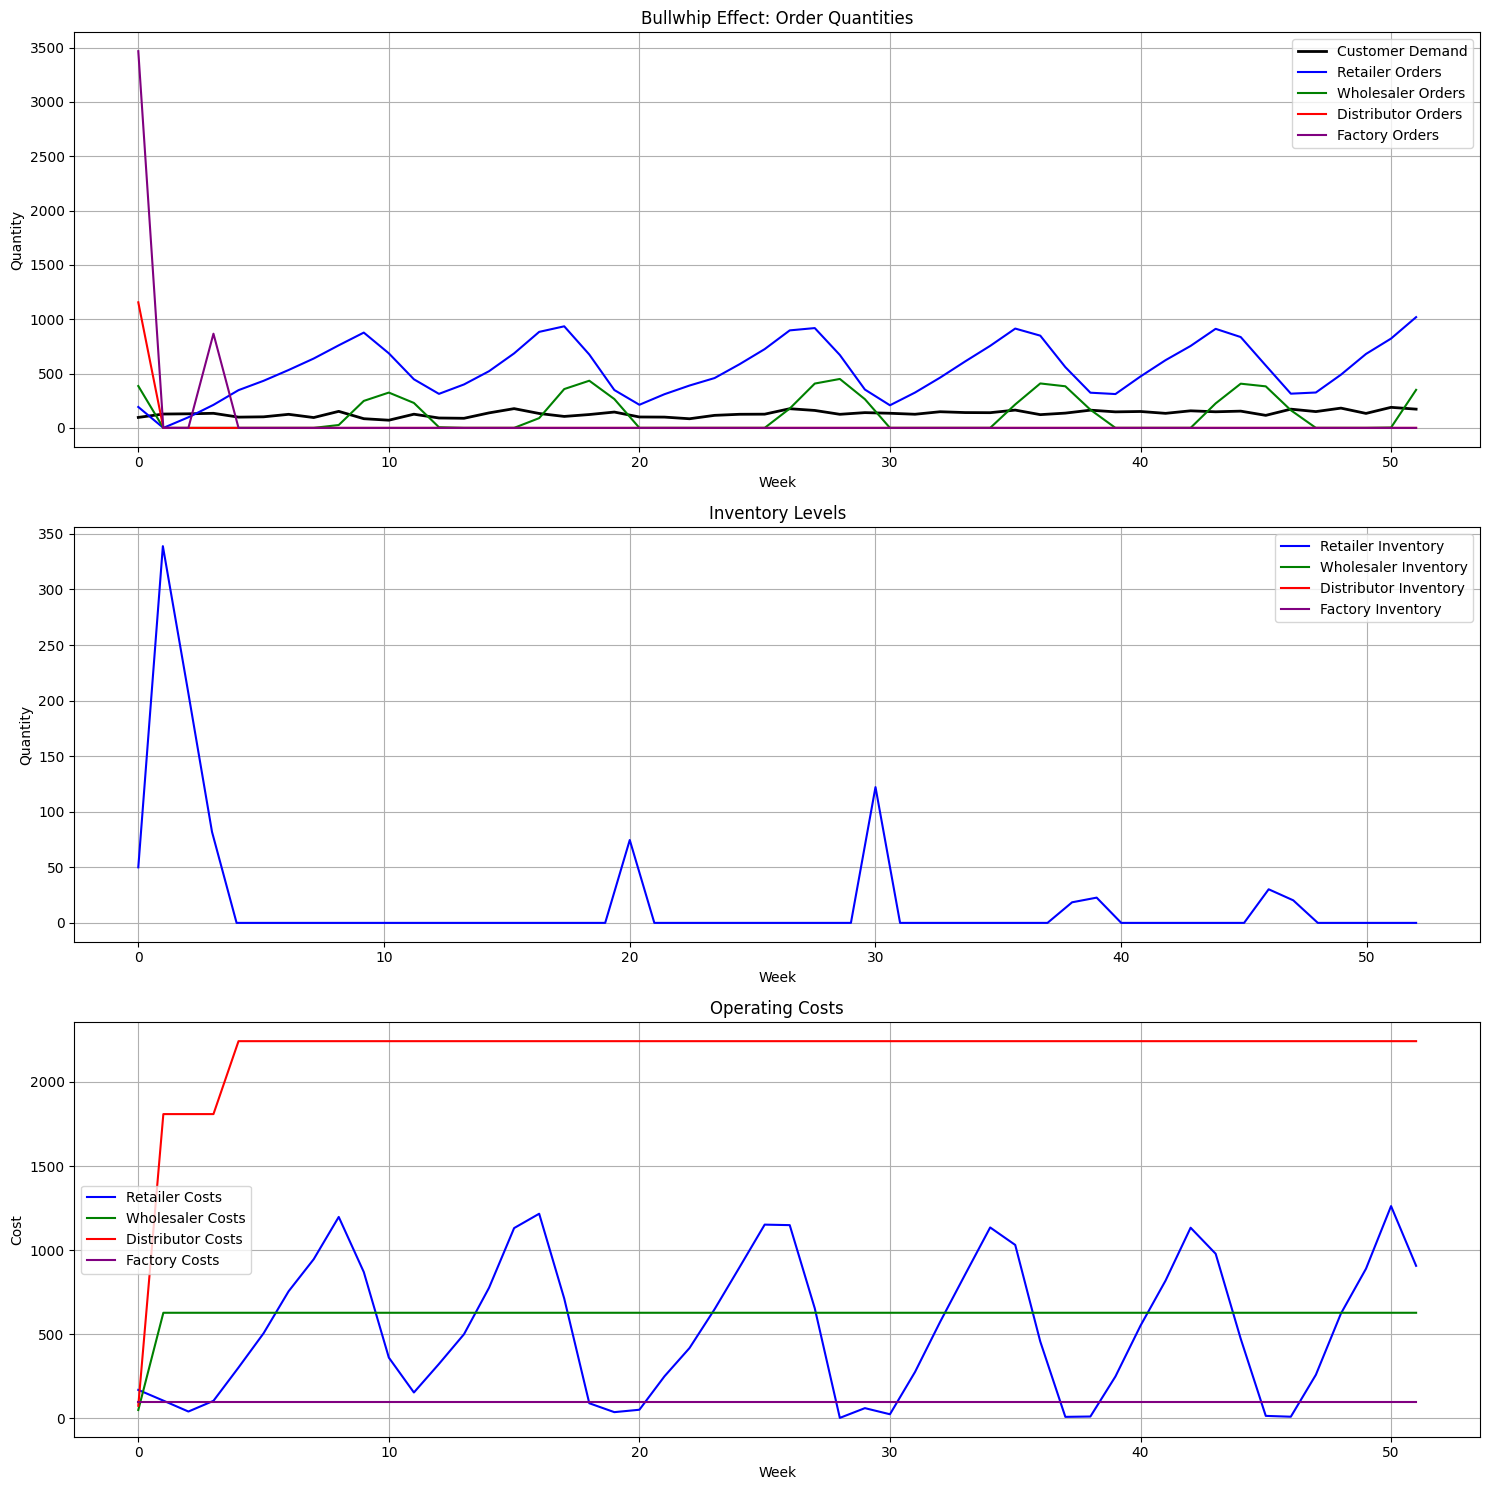


Running simulation: lean scenario, trend demand, exponential_smoothing ordering

Quarter 1 Performance:
Customer Demand: 105.40
Orders: R=210.80, W=421.61, D=1264.82, F=3794.47
Stockouts: 0

Quarter 2 Performance:
Customer Demand: 90.08
Orders: R=818.03, W=0.00, D=0.00, F=0.00
Stockouts: 1

Quarter 3 Performance:
Customer Demand: 116.41
Orders: R=1360.64, W=0.00, D=0.00, F=0.00
Stockouts: 1

Quarter 4 Performance:
Customer Demand: 165.64
Orders: R=762.71, W=90.63, D=0.00, F=0.00
Stockouts: 1

Simulation completed: 52 weeks
Average demand: 126.12
Demand variation: 28.43


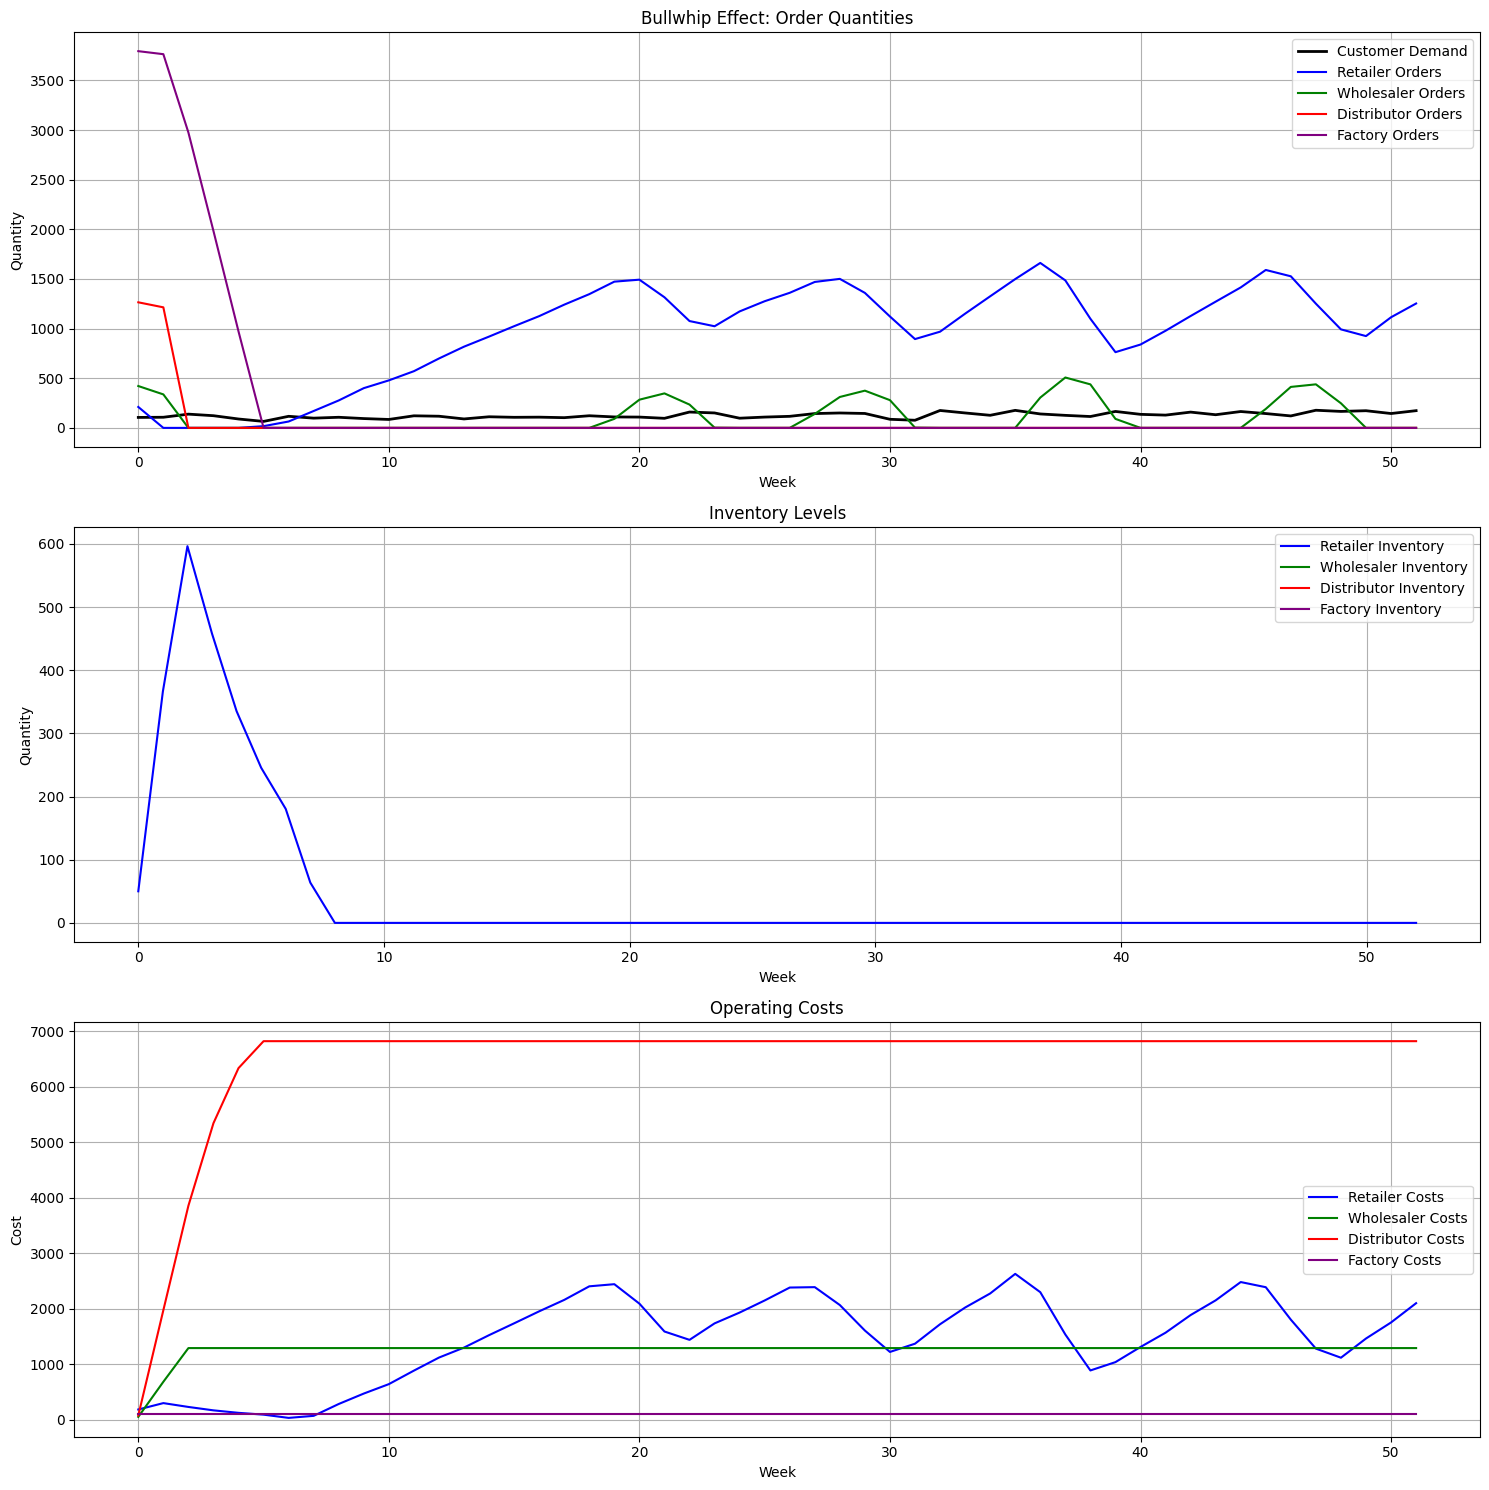

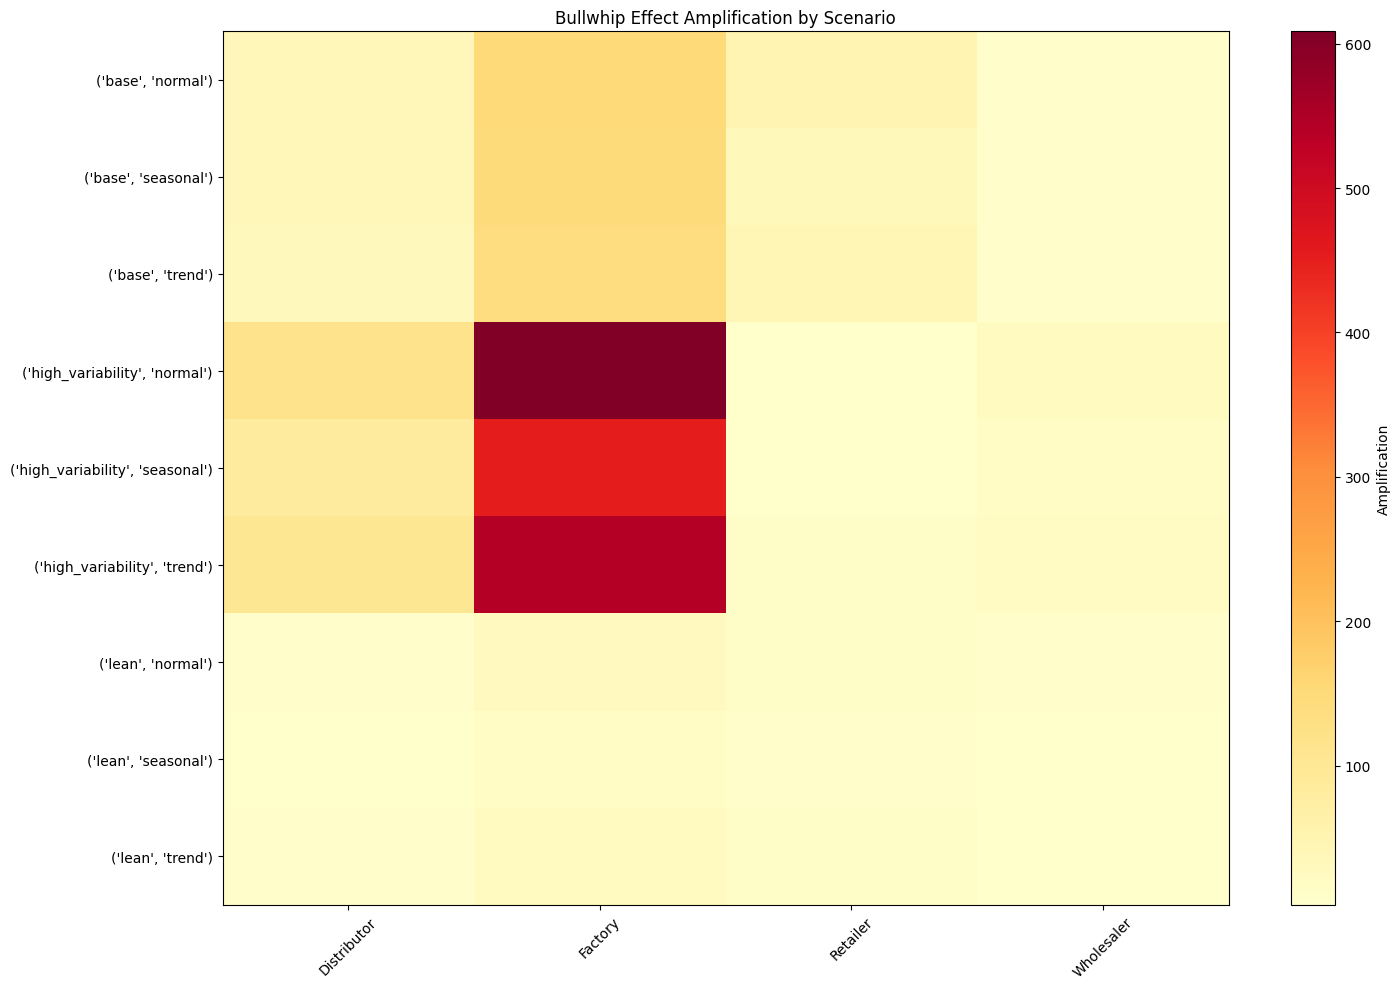

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import deque

class SupplyChainActor:
    def __init__(self, name, lead_time, safety_stock, order_delay=1, forecasting_period=4):
        """
        공급망 구성원 초기화

        Parameters:
        name (str): 구성원 이름
        lead_time (int): 리드타임
        safety_stock (float): 안전재고 수준
        order_delay (int): 주문 지연 시간
        forecasting_period (int): 수요 예측 기간
        """
        self.name = name
        self.lead_time = lead_time
        self.safety_stock = safety_stock
        self.order_delay = order_delay
        self.forecasting_period = forecasting_period

        # 상태 변수 초기화
        self.inventory = safety_stock
        self.backlog = 0

        # 이력 데이터 초기화
        self.incoming_orders = []
        self.outgoing_orders = []
        self.received_shipments = []
        self.inventory_history = [safety_stock]  # 초기 재고로 시작
        self.costs = []

        # 수요 예측을 위한 주문 이력
        self.order_history = deque(maxlen=forecasting_period)

    def calculate_costs(self, holding_cost=0.5, stockout_cost=2.0):
        """재고 유지 비용과 재고 부족 비용 계산"""
        holding = max(0, self.inventory) * holding_cost
        stockout = max(0, self.backlog) * stockout_cost
        total_cost = holding + stockout
        self.costs.append(total_cost)
        return total_cost

    def place_order(self, demand, order_strategy='moving_average'):
        """
        주문량 결정 및 발주

        Parameters:
        demand (float): 현재 수요
        order_strategy (str): 주문 전략 ('simple', 'moving_average', 'exponential_smoothing')

        Returns:
        float: 주문량
        """
        try:
            self.order_history.append(demand)

            # 수요 예측
            if order_strategy == 'moving_average':
                if len(self.order_history) >= self.forecasting_period:
                    forecasted_demand = np.mean(self.order_history)
                else:
                    forecasted_demand = demand
            elif order_strategy == 'exponential_smoothing':
                alpha = 0.2
                if len(self.order_history) < 2:
                    forecasted_demand = demand
                else:
                    prev_forecast = np.mean(list(self.order_history)[:-1])
                    forecasted_demand = alpha * demand + (1 - alpha) * prev_forecast
            else:  # simple
                forecasted_demand = demand

            # 필요 재고량 계산
            required_inventory = (forecasted_demand * (self.lead_time + self.order_delay)
                                + self.safety_stock)

            # 주문량 결정
            order_quantity = max(0, required_inventory - self.inventory + self.backlog)

            self.outgoing_orders.append(order_quantity)
            return order_quantity

        except Exception as e:
            print(f"Error in place_order for {self.name}: {str(e)}")
            return 0

    def receive_shipment(self, shipment):
        """배송 물량 수령"""
        try:
            self.received_shipments.append(shipment)
            self.inventory += shipment
        except Exception as e:
            print(f"Error in receive_shipment for {self.name}: {str(e)}")

    def fulfill_orders(self, demand):
        """
        주문 처리 및 배송

        Parameters:
        demand (float): 처리할 주문량

        Returns:
        float: 실제 처리된 주문량
        """
        try:
            fulfilled = min(demand + self.backlog, self.inventory)
            self.inventory -= fulfilled
            self.backlog = demand + self.backlog - fulfilled
            self.inventory_history.append(self.inventory)
            return fulfilled
        except Exception as e:
            print(f"Error in fulfill_orders for {self.name}: {str(e)}")
            return 0

class SupplyChain:
    def __init__(self, scenario='base'):
        """
        공급망 초기화

        Parameters:
        scenario (str): 시나리오 유형 ('base', 'high_variability', 'lean')
        """
        scenarios = {
            'base': {
                'retailer': {'lead_time': 2, 'safety_stock': 100},
                'wholesaler': {'lead_time': 2, 'safety_stock': 200},
                'distributor': {'lead_time': 3, 'safety_stock': 300},
                'factory': {'lead_time': 3, 'safety_stock': 400}
            },
            'high_variability': {
                'retailer': {'lead_time': 3, 'safety_stock': 150},
                'wholesaler': {'lead_time': 3, 'safety_stock': 300},
                'distributor': {'lead_time': 4, 'safety_stock': 450},
                'factory': {'lead_time': 4, 'safety_stock': 600}
            },
            'lean': {
                'retailer': {'lead_time': 1, 'safety_stock': 50},
                'wholesaler': {'lead_time': 1, 'safety_stock': 100},
                'distributor': {'lead_time': 2, 'safety_stock': 150},
                'factory': {'lead_time': 2, 'safety_stock': 200}
            }
        }

        selected_scenario = scenarios[scenario]

        # 공급망 구성원 초기화
        self.retailer = SupplyChainActor("Retailer", **selected_scenario['retailer'])
        self.wholesaler = SupplyChainActor("Wholesaler", **selected_scenario['wholesaler'])
        self.distributor = SupplyChainActor("Distributor", **selected_scenario['distributor'])
        self.factory = SupplyChainActor("Factory", **selected_scenario['factory'])

        self.customer_demand_history = []
        self.actors = [self.retailer, self.wholesaler, self.distributor, self.factory]


    def simulate(self, weeks, base_demand=100, demand_pattern='normal',
               demand_variation=10, seasonality_factor=0.3, order_strategy='moving_average'):
       """
       공급망 시뮬레이션 실행

       Parameters:
       weeks (int): 시뮬레이션 기간 (주)
       base_demand (float): 기본 수요량
       demand_pattern (str): 수요 패턴 ('normal', 'seasonal', 'trend')
       demand_variation (float): 수요 변동성
       seasonality_factor (float): 계절성 요인 (0~1)
       order_strategy (str): 주문 전략 ('simple', 'moving_average', 'exponential_smoothing')
       """
       # 이력 초기화
       self.customer_demand_history = []
       for actor in self.actors:
           actor.outgoing_orders = []
           actor.received_shipments = []
           actor.inventory_history = [actor.safety_stock]  # 초기 재고로 시작
           actor.costs = []
           actor.order_history.clear()

       # 주별 시뮬레이션
       for week in range(weeks):
           try:
               # 수요 패턴에 따른 고객 수요 생성
               if demand_pattern == 'normal':
                   # 정규 분포를 따르는 수요
                   customer_demand = max(0, base_demand + np.random.normal(0, demand_variation))

               elif demand_pattern == 'seasonal':
                   # 계절성을 포함한 수요
                   seasonal_component = base_demand * seasonality_factor * np.sin(2 * np.pi * week / 52)
                   customer_demand = max(0, base_demand + seasonal_component +
                                      np.random.normal(0, demand_variation))

               elif demand_pattern == 'trend':
                   # 증가 추세를 포함한 수요
                   trend_component = week * (base_demand * 0.01)  # 매주 1% 증가
                   customer_demand = max(0, base_demand + trend_component +
                                      np.random.normal(0, demand_variation))
               else:
                   raise ValueError(f"Unknown demand pattern: {demand_pattern}")

               self.customer_demand_history.append(customer_demand)

               # 각 단계별 주문 처리
               retailer_order = self.retailer.place_order(customer_demand, order_strategy)
               wholesaler_order = self.wholesaler.place_order(retailer_order, order_strategy)
               distributor_order = self.distributor.place_order(wholesaler_order, order_strategy)
               factory_order = self.factory.place_order(distributor_order, order_strategy)

               # 배송 처리 (리드타임 고려)
               # 공장 -> 유통업체 배송
               if len(self.factory.outgoing_orders) >= self.factory.lead_time:
                   factory_shipment = self.factory.outgoing_orders[-self.factory.lead_time]
                   self.distributor.receive_shipment(factory_shipment)

               # 유통업체 -> 도매업체 배송
               if len(self.distributor.outgoing_orders) >= self.distributor.lead_time:
                   distributor_shipment = self.distributor.outgoing_orders[-self.distributor.lead_time]
                   self.wholesaler.receive_shipment(distributor_shipment)

               # 도매업체 -> 소매업체 배송
               if len(self.wholesaler.outgoing_orders) >= self.wholesaler.lead_time:
                   wholesaler_shipment = self.wholesaler.outgoing_orders[-self.wholesaler.lead_time]
                   self.retailer.receive_shipment(wholesaler_shipment)

               # 주문 이행 및 비용 계산
               fulfilled_demand = self.retailer.fulfill_orders(customer_demand)

               # 각 단계별 운영 비용 계산
               for actor in self.actors:
                   actor.calculate_costs()

               # 분기별 리포트 (13주마다)
               if week % 13 == 0:
                   print(f"\nQuarter {week//13 + 1} Performance:")
                   print(f"Customer Demand: {customer_demand:.2f}")
                   print(f"Orders: R={retailer_order:.2f}, W={wholesaler_order:.2f}, "
                         f"D={distributor_order:.2f}, F={factory_order:.2f}")
                   print(f"Stockouts: {sum(1 for actor in self.actors if actor.inventory <= 0)}")

           except Exception as e:
               print(f"Error in simulation week {week}: {str(e)}")
               continue

       # 시뮬레이션 완료 후 통계
       print(f"\nSimulation completed: {len(self.customer_demand_history)} weeks")
       if len(self.customer_demand_history) > 0:
           print(f"Average demand: {np.mean(self.customer_demand_history):.2f}")
           print(f"Demand variation: {np.std(self.customer_demand_history):.2f}")

       # 데이터 유효성 검사
       self._validate_simulation_data()

    def _validate_simulation_data(self):
       """시뮬레이션 데이터 유효성 검사"""
       for actor in self.actors:
           if len(actor.inventory_history) == 0:
               print(f"Warning: {actor.name} has no inventory history")
           if len(actor.outgoing_orders) == 0:
               print(f"Warning: {actor.name} has no order history")
           if len(actor.costs) == 0:
               print(f"Warning: {actor.name} has no cost history")

    def plot_results(self, show_costs=True):
       """시뮬레이션 결과 시각화"""
       if show_costs:
           fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15))
       else:
           fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

       # 주문량 그래프
       ax1.plot(self.customer_demand_history, label='Customer Demand',
               linewidth=2, color='black')
       colors = ['blue', 'green', 'red', 'purple']
       for actor, color in zip(self.actors, colors):
           ax1.plot(actor.outgoing_orders, label=f'{actor.name} Orders', color=color)
       ax1.set_title('Bullwhip Effect: Order Quantities')
       ax1.set_xlabel('Week')
       ax1.set_ylabel('Quantity')
       ax1.legend()
       ax1.grid(True)

       # 재고 수준 그래프
       for actor, color in zip(self.actors, colors):
           ax2.plot(actor.inventory_history, label=f'{actor.name} Inventory', color=color)
       ax2.set_title('Inventory Levels')
       ax2.set_xlabel('Week')
       ax2.set_ylabel('Quantity')
       ax2.legend()
       ax2.grid(True)

       if show_costs:
           for actor, color in zip(self.actors, colors):
               ax3.plot(actor.costs, label=f'{actor.name} Costs', color=color)
           ax3.set_title('Operating Costs')
           ax3.set_xlabel('Week')
           ax3.set_ylabel('Cost')
           ax3.legend()
           ax3.grid(True)

       plt.tight_layout()
       plt.show()

    def print_statistics(self):
       """성과 통계 출력"""
       print("\n=== Performance Statistics ===")

       if len(self.customer_demand_history) > 0:
           base_std = np.std(self.customer_demand_history)
           print(f"\nVariability Analysis:")
           print(f"Customer Demand Std Dev: {base_std:.2f}")
           for actor in self.actors:
               if len(actor.outgoing_orders) > 0:
                   actor_std = np.std(actor.outgoing_orders)
                   amplification = actor_std / base_std
                   print(f"{actor.name:12} Order Std Dev: {actor_std:8.2f} "
                         f"(Amplification: {amplification:6.2f}x)")
               else:
                   print(f"{actor.name:12} No order history available")
       else:
           print("\nNo customer demand history available")

       print("\nInventory Statistics:")
       for actor in self.actors:
           if len(actor.inventory_history) > 0:
               avg_inventory = np.mean(actor.inventory_history)
               stockout_count = sum(1 for inv in actor.inventory_history if inv <= 0)
               stockout_rate = stockout_count / len(actor.inventory_history)
               print(f"{actor.name:12} Average Inventory: {avg_inventory:8.2f} "
                     f"Stockout Rate: {stockout_rate:6.2%}")
           else:
               print(f"{actor.name:12} No inventory history available")

       print("\nCost Analysis:")
       for actor in self.actors:
           if len(actor.costs) > 0:
               total_cost = sum(actor.costs)
               avg_cost = np.mean(actor.costs)
               print(f"{actor.name:12} Total Cost: {total_cost:10.2f} "
                     f"Average Cost: {avg_cost:8.2f}")
           else:
               print(f"{actor.name:12} No cost history available")

def run_scenario_comparison():
   """다양한 시나리오 실행 및 비교"""
   scenarios = ['base', 'high_variability', 'lean']
   demand_patterns = ['normal', 'seasonal', 'trend']
   order_strategies = ['simple', 'moving_average', 'exponential_smoothing']

   results = []

   for scenario in scenarios:
       for pattern in demand_patterns:
           for strategy in order_strategies:
               print(f"\nRunning simulation: {scenario} scenario, {pattern} demand, {strategy} ordering")

               supply_chain = SupplyChain(scenario=scenario)
               supply_chain.simulate(weeks=52, base_demand=100, demand_pattern=pattern,
                                  demand_variation=20, order_strategy=strategy)

               # 결과 수집
               if len(supply_chain.customer_demand_history) > 0:
                   base_std = np.std(supply_chain.customer_demand_history)
                   for actor in supply_chain.actors:
                       if len(actor.outgoing_orders) > 0:
                           actor_std = np.std(actor.outgoing_orders)
                           amplification = actor_std / base_std
                           avg_inventory = np.mean(actor.inventory_history)
                           total_cost = sum(actor.costs)

                           results.append({
                               'Scenario': scenario,
                               'Demand Pattern': pattern,
                               'Order Strategy': strategy,
                               'Actor': actor.name,
                               'Amplification': amplification,
                               'Avg Inventory': avg_inventory,
                               'Total Cost': total_cost
                           })

               supply_chain.plot_results()

   # 결과 분석 및 시각화
   if results:
       results_df = pd.DataFrame(results)
       plt.figure(figsize=(15, 10))
       pivot_amp = results_df.pivot_table(
           values='Amplification',
           index=['Scenario', 'Demand Pattern'],
           columns='Actor',
           aggfunc='mean'
       )

       plt.imshow(pivot_amp, cmap='YlOrRd', aspect='auto')
       plt.colorbar(label='Amplification')
       plt.xticks(range(len(pivot_amp.columns)), pivot_amp.columns, rotation=45)
       plt.yticks(range(len(pivot_amp.index)), pivot_amp.index)
       plt.title('Bullwhip Effect Amplification by Scenario')
       plt.tight_layout()
       plt.show()

if __name__ == "__main__":
   run_scenario_comparison()